In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


# JPK qi data to text file in .xyzc format conversion program
# command format: qi2txt input_file output_file
# input_file: name of the input file (including its path if necessary)
# output_file: name of the output file (including its path if necessary)

import zipfile
import io
import numpy as np
import struct
import matplotlib.pyplot as plt
import re
import time
import sys
import pandas as pd
from scipy import interpolate


# 入出力ファイルのパスを取得
QI_FILES = ["qi1.jpk-qi-data", "qi2.jpk-qi-data", "qi3.jpk-qi-data", "qi4.jpk-qi-data", "qi5.jpk-qi-data", "qi6.jpk-qi-data", "qi7.jpk-qi-data", "qi8.jpk-qi-data"]
ANS_FILES = ["qi1.txt", "qi2.txt", "qi3.txt", "qi4.txt", "qi5.txt", "qi6.txt", "qi7.txt", "qi8.txt"]
N_Z_PTS = 256
fcs = []
ans = []
n_pts_max = 0

start_time = time.perf_counter()

for f_num, file in enumerate(QI_FILES):
    print("Reading data from " + file)

    with zipfile.ZipFile(file) as zf:
        # shared-data/header.propertiesからのパラメータの読み込み
        with zf.open("shared-data/header.properties") as f:
            f.readline()
            sh_param = {}
            for b_line in f:
                s_line = b_line.decode("utf-8")
                m = re.search("=",s_line)
                sh_param[s_line[:m.end()-1]]=s_line[m.end():]

        # channelの名前と番号の辞書を作成
        ch = {}
        i = 0
        while True:
            try:
                ch_name=sh_param["lcd-info."+str(i)+".channel.name"][:-1]
                ch[ch_name]= i
                i += 1
            except KeyError:
                break

        # z data（measuredHeight）のスケーリングパラメータの取得
        ch_num = ch["measuredHeight"]
        z_offset1 = float(sh_param["lcd-info."+str(ch_num)+".encoder.scaling.offset"])
        z_multi1 = float(sh_param["lcd-info."+str(ch_num)+".encoder.scaling.multiplier"])
        z_offset2 = float(sh_param["lcd-info."+str(ch_num)+".conversion-set.conversion.nominal.scaling.offset"])
        z_multi2 = float(sh_param["lcd-info."+str(ch_num)+".conversion-set.conversion.nominal.scaling.multiplier"])

        # force data (vDeflection)のスケーリングパラメータの取得
        ch_num = ch["vDeflection"]
        f_offset1 = float(sh_param["lcd-info."+str(ch_num)+".encoder.scaling.offset"])
        f_multi1 = float(sh_param["lcd-info."+str(ch_num)+".encoder.scaling.multiplier"])
        f_offset2 = float(sh_param["lcd-info."+str(ch_num)+".conversion-set.conversion.distance.scaling.offset"])
        f_multi2 = float(sh_param["lcd-info."+str(ch_num)+".conversion-set.conversion.distance.scaling.multiplier"])
        f_offset3 = float(sh_param["lcd-info."+str(ch_num)+".conversion-set.conversion.force.scaling.offset"])
        f_multi3 = float(sh_param["lcd-info."+str(ch_num)+".conversion-set.conversion.force.scaling.multiplier"])

        # root folderのheader.propertiesファイルからイメージングパラメータの読み込み
        with zf.open("header.properties") as f:
            f.readline()
            qi_param = {}
            for b_line in f:
                s_line = b_line.decode("utf-8")
                m = re.search("=",s_line)
                qi_param[s_line[:m.end()-1]]=s_line[m.end():]

        # QI imagingに関するパラメータ変数の設定
        x_pix = int(qi_param["quantitative-imaging-map.position-pattern.grid.ilength"])
        y_pix = int(qi_param["quantitative-imaging-map.position-pattern.grid.jlength"])
        xy_pix = x_pix*y_pix
        
        z_pix = 0
        for i in range(xy_pix):
            with zf.open("index/"+str(i)+"/header.properties") as f:
                for b_line in f:
                    s_line = b_line.decode("utf-8")
                    m = re.search("quantitative-imaging-series.header.quantitative-imaging-settings.extend.num-points=",s_line)
                    if m != None:
                        z_pix = max(z_pix,int(s_line[m.end():]))
        #z_pix = int(sh_param["force-segment-header-info."+str(ch["vDeflection"])+".settings.segment-settings.num-points"])

        # force map dataとその分類エータを格納する変数の作成
        fmap = np.empty((x_pix,y_pix,z_pix,2))

        # xy scannerのイメージング開始位置とイメージの走査範囲を取得
        x_start = float(qi_param["quantitative-imaging-map.environment.xy-scanner-position-map.xy-scanner.tip-scanner.start-position.x"])
        y_start = float(qi_param["quantitative-imaging-map.environment.xy-scanner-position-map.xy-scanner.tip-scanner.start-position.y"])
        x_range = float(qi_param["quantitative-imaging-map.position-pattern.grid.ulength"])
        y_range = float(qi_param["quantitative-imaging-map.position-pattern.grid.vlength"])
        x_step = x_range/x_pix
        y_step = y_range/y_pix

        # ANS_FILESからクラス分類の正解情報を得る
        df = pd.read_csv("qi"+str(f_num+1)+".txt", sep="\t")
        df = df.dropna()
        
        # z (measuredHeight) dataの読み込み
        for j in range(y_pix):
            for i in range(x_pix):
                with zf.open("index/"+str(i+j*x_pix)+"/segments/0/channels/measuredHeight.dat") as f:
                    b = f.read()
                    fh=io.BytesIO(b)
                    n_pts = int(len(b)/4)
                    for k in range(n_pts):
                        byte=fh.read(4)
                        z = float(struct.unpack('>i',byte)[0])
                        z = z_multi1*z + z_offset1
                        z = z_multi2*z + z_offset2
                        fmap[i,j,k,0] = z
                    if n_pts<z_pix:
                        fmap[i,j,n_pts:,0] = None

        # force (vDeflection) dataの読み込み
        for j in range(y_pix):
            for i in range(x_pix):
                with zf.open("index/"+str(i+j*x_pix)+"/segments/0/channels/vDeflection.dat") as f:
                    b = f.read()
                    fh=io.BytesIO(b)
                    n_pts = int(len(b)/4)
                    for k in range(n_pts):
                        byte=fh.read(4)
                        force = float(struct.unpack('>i',byte)[0])
                        force = f_multi1*force + f_offset1
                        force = f_multi2*force + f_offset2
                        force = f_multi3*force + f_offset3
                        fmap[i,j,k,1] = force
                    if n_pts<z_pix:
                        fmap[i,j,n_pts:,1] = None
                    n_pts_max = max(n_pts_max,n_pts)
                    
                # fcsとansへの値の代入
                x = fmap[i,j,:,0]
                y = fmap[i,j,:,1]
                f = interpolate.interp1d(x,y, kind="linear")
                x1 = np.linspace(min(x), max(x), N_Z_PTS)
                y1 = f(x1)
#                y1 -= y1[-1]
                fcs.append(y1)
                ans.append(df.iloc[i*x_pix+j,2])

end_time = time.perf_counter()
time_lapse = end_time - start_time
print (f"Conversion was finished in {time_lapse:.1f} sec.")


Reading data from qi1.jpk-qi-data
Reading data from qi2.jpk-qi-data
Reading data from qi3.jpk-qi-data
Reading data from qi4.jpk-qi-data
Reading data from qi5.jpk-qi-data
Reading data from qi6.jpk-qi-data
Reading data from qi7.jpk-qi-data
Reading data from qi8.jpk-qi-data
Conversion was finished in 10.7 sec.


In [17]:
master_df[1]

0            0
1            0
2            0
3            0
4            0
          ... 
524283    2047
524284    2047
524285    2047
524286    2047
524287    2047
Name: 1, Length: 524288, dtype: int32

# Prepairing Training Dataset

In [2]:
df=pd.DataFrame(fcs)
n_fcs=len(fcs)
master_df = pd.DataFrame({0: df.values.flatten(),
                          1: np.arange(n_fcs).repeat(df.shape[1])})

In [3]:
df

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,7.832858e-10,7.729383e-10,7.534507e-10,7.251567e-10,7.103801e-10,7.009100e-10,6.719359e-10,6.721705e-10,6.637684e-10,6.760108e-10,...,3.155795e-10,3.150504e-10,3.134506e-10,3.157812e-10,3.150300e-10,3.173137e-10,3.170801e-10,3.156410e-10,3.154465e-10,3.148783e-10
1,7.880491e-10,7.801493e-10,7.705119e-10,7.784050e-10,7.689812e-10,7.696894e-10,7.693597e-10,7.591307e-10,7.509405e-10,7.488643e-10,...,3.500182e-10,3.520648e-10,3.447448e-10,3.475891e-10,3.467576e-10,3.488556e-10,3.452302e-10,3.490975e-10,3.478367e-10,3.421390e-10
2,7.896684e-10,7.822149e-10,7.711277e-10,7.543878e-10,7.499592e-10,7.440264e-10,7.249406e-10,7.244395e-10,7.086282e-10,7.040188e-10,...,3.394439e-10,3.374413e-10,3.383992e-10,3.361878e-10,3.381539e-10,3.374274e-10,3.351388e-10,3.341671e-10,3.377339e-10,3.344953e-10
3,7.940685e-10,7.755309e-10,7.654367e-10,7.647056e-10,7.546104e-10,7.520232e-10,7.366106e-10,7.224314e-10,7.143091e-10,7.094749e-10,...,3.402593e-10,3.404180e-10,3.339875e-10,3.377917e-10,3.357687e-10,3.410306e-10,3.374647e-10,3.378818e-10,3.397940e-10,3.335785e-10
4,7.847049e-10,7.720664e-10,7.694508e-10,7.652461e-10,7.666373e-10,7.581939e-10,7.645378e-10,7.564073e-10,7.608758e-10,7.539007e-10,...,3.332306e-10,3.368389e-10,3.359956e-10,3.350166e-10,3.343235e-10,3.367683e-10,3.350851e-10,3.354222e-10,3.309394e-10,3.331412e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,2.078473e-09,2.066668e-09,2.046441e-09,2.044147e-09,2.057872e-09,2.047388e-09,2.053096e-09,2.043243e-09,2.036027e-09,2.027922e-09,...,1.114194e-09,1.113062e-09,1.116121e-09,1.118669e-09,1.120281e-09,1.115066e-09,1.118098e-09,1.111945e-09,1.107416e-09,1.101944e-09
2044,2.077151e-09,2.054104e-09,2.031252e-09,2.031610e-09,2.028266e-09,2.019397e-09,2.021417e-09,1.998138e-09,1.968330e-09,1.961326e-09,...,1.101821e-09,1.104334e-09,1.108962e-09,1.113999e-09,1.115530e-09,1.118524e-09,1.119757e-09,1.117745e-09,1.113050e-09,1.116695e-09
2045,2.075548e-09,2.048884e-09,2.012952e-09,1.995388e-09,2.001120e-09,1.970875e-09,1.969344e-09,1.962931e-09,1.959229e-09,1.951466e-09,...,1.104767e-09,1.105697e-09,1.108028e-09,1.112608e-09,1.115318e-09,1.109600e-09,1.113795e-09,1.115732e-09,1.118044e-09,1.121770e-09
2046,2.071634e-09,2.050224e-09,2.034136e-09,2.003638e-09,2.009715e-09,2.006856e-09,2.015638e-09,1.998954e-09,1.994640e-09,1.984476e-09,...,1.119610e-09,1.119937e-09,1.113303e-09,1.112684e-09,1.112815e-09,1.108399e-09,1.102259e-09,1.101626e-09,1.097402e-09,1.098936e-09


# Preparing tesing Dataset y(pandas series). Pandas data series purpose: rest of the algorithm training data should pass as pd.dataseries 

In [4]:
y= pd.Series(ans)
y

0       0
1       0
2       1
3       1
4       0
       ..
2043    0
2044    0
2045    0
2046    0
2047    0
Length: 2048, dtype: int64

# Using XGboost

In [4]:
X= fcs
len(X)

2048

C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:33:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Data:
1.0
Test Data
0.6658536585365854
==confusion Matrix==
[[ 72  39  15]
 [ 23 112  33]
 [  7  20  89]]
==classification Report==
              precision    recall  f1-score   support

           0       0.71      0.57      0.63       126
           1       0.65      0.67      0.66       168
           2       0.65      0.77      0.70       116

    accuracy                           0.67       410
   macro avg       0.67      0.67      0.67       410
weighted avg       0.67      0.67      0.66       410



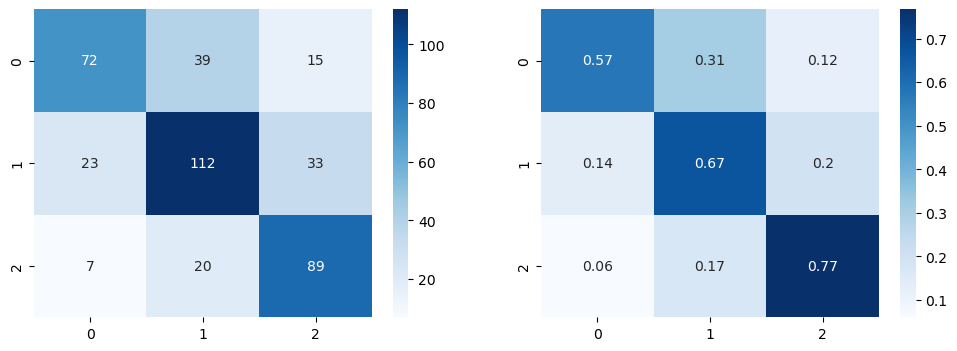

In [5]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2,random_state=1)

xgb_clf=xgb.XGBClassifier(booster='dart')
xgb_clf.fit(X_train,y_train)

xgb_pred_train=xgb_clf.predict(X_train)
xgb_pred_test=xgb_clf.predict(X_test)

Y_pred = xgb_pred_test

cm0 = confusion_matrix(y_test, Y_pred, normalize="true")
cm1 = confusion_matrix(y_test, Y_pred)

fig = plt.figure(figsize=(12,4))
plt.subplot(121)
sns.heatmap(cm1, annot=True, cmap='Blues',fmt='g')
plt.subplot(122)
sns.heatmap(cm0, annot=True, cmap='Blues')

print('Training Data:')
print(accuracy_score(y_train,xgb_pred_train))
print('Test Data')
print(accuracy_score(y_test,xgb_pred_test))
print('==confusion Matrix==')

print(confusion_matrix(y_test,xgb_pred_test))

print('==classification Report==')

print(classification_report(y_test,xgb_pred_test))

# KNN 


==confusion Matrix==
0.6560975609756098
[[ 61  35  24]
 [ 27  95  39]
 [  5  11 113]]
==classification Report==
              precision    recall  f1-score   support

           0       0.66      0.51      0.57       120
           1       0.67      0.59      0.63       161
           2       0.64      0.88      0.74       129

    accuracy                           0.66       410
   macro avg       0.66      0.66      0.65       410
weighted avg       0.66      0.66      0.65       410



C:\Users\Fahim\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


<AxesSubplot:>

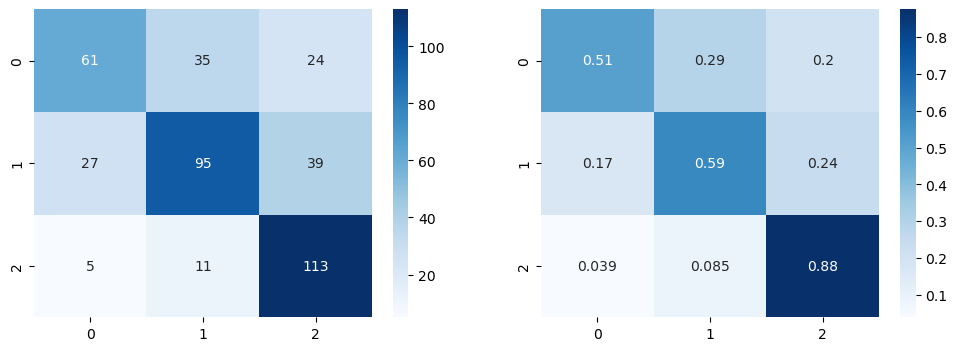

In [20]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import seaborn as sns

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 2)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Training the K-NN model on the Training set
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test, y_pred)
cm0 = confusion_matrix(y_test, y_pred, normalize="true")
cm1 = confusion_matrix(y_test, y_pred)
print('==confusion Matrix==')
print(ac)
print(confusion_matrix(y_test,y_pred))

print('==classification Report==')

print(classification_report(y_test, y_pred))

fig = plt.figure(figsize=(12,4))
plt.subplot(121)
sns.heatmap(cm1, annot=True, cmap='Blues',fmt='g')
plt.subplot(122)
sns.heatmap(cm0, annot=True, cmap='Blues')

In [9]:
X.shape

AttributeError: 'list' object has no attribute 'shape'

# SVM

==confusion Matrix==
[[81 30 15]
 [45 93 30]
 [11 19 86]]
==classification Report==
              precision    recall  f1-score   support

           0       0.59      0.64      0.62       126
           1       0.65      0.55      0.60       168
           2       0.66      0.74      0.70       116

    accuracy                           0.63       410
   macro avg       0.63      0.65      0.64       410
weighted avg       0.64      0.63      0.63       410



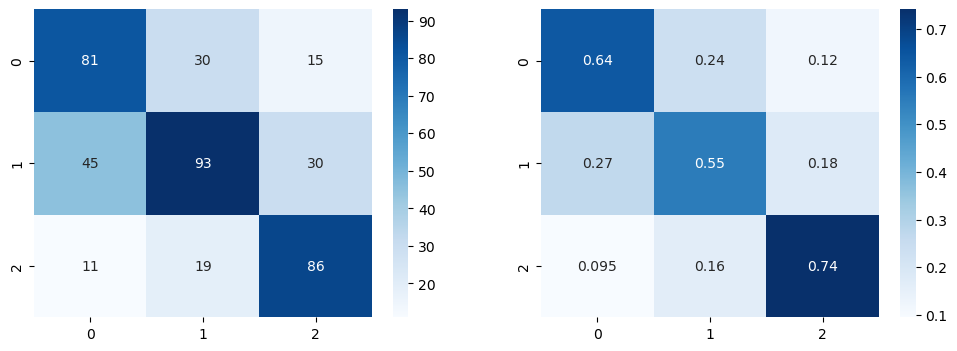

In [21]:
#Import svm model
from sklearn import svm

X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2,random_state=1)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
ac = accuracy_score(y_test, y_pred)
cm0 = confusion_matrix(y_test,y_pred, normalize="true")
cm1 = confusion_matrix(y_test,y_pred)

fig = plt.figure(figsize=(12,4))
plt.subplot(121)
sns.heatmap(cm1, annot=True, cmap='Blues',fmt='g')
plt.subplot(122)
sns.heatmap(cm0, annot=True, cmap='Blues')


print('==confusion Matrix==')

print(confusion_matrix(y_test,y_pred))

print('==classification Report==')

print(classification_report(y_test, y_pred))

# Random Forest

Accuracy: 0.7097560975609756
==confusion Matrix==
[[ 72  39  15]
 [ 17 122  29]
 [  7  12  97]]
==classification Report==
              precision    recall  f1-score   support

           0       0.75      0.57      0.65       126
           1       0.71      0.73      0.72       168
           2       0.69      0.84      0.75       116

    accuracy                           0.71       410
   macro avg       0.71      0.71      0.71       410
weighted avg       0.71      0.71      0.71       410



<AxesSubplot:>

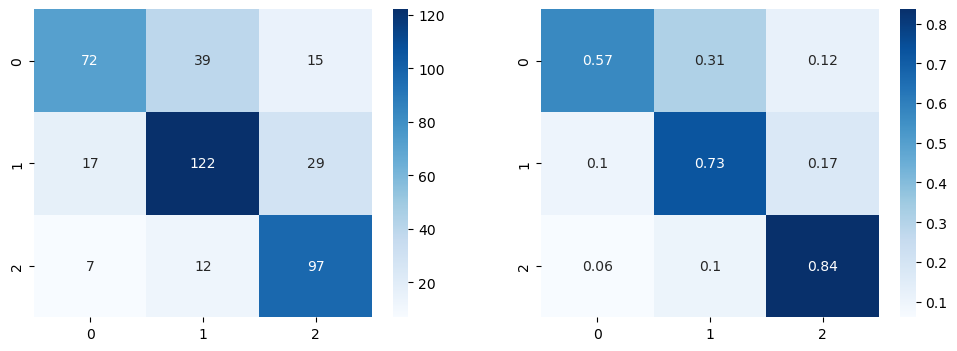

In [22]:
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

# prediction on test set
y_pred=clf.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

print('==confusion Matrix==')

print(confusion_matrix(y_test,y_pred))

print('==classification Report==')

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test,y_pred)
ac = accuracy_score(y_test, y_pred)
cm0 = confusion_matrix(y_test,y_pred, normalize="true")
cm1 = confusion_matrix(y_test,y_pred)

fig = plt.figure(figsize=(12,4))
plt.subplot(121)
sns.heatmap(cm1, annot=True, cmap='Blues',fmt='g')
plt.subplot(122)
sns.heatmap(cm0, annot=True, cmap='Blues')

# Decision Tree

==Confusion Matrix==
[[ 25  45  57]
 [  2  89  64]
 [  1  20 107]]
==Classification Report==
              precision    recall  f1-score   support

           0       0.89      0.20      0.32       127
           1       0.58      0.57      0.58       155
           2       0.47      0.84      0.60       128

    accuracy                           0.54       410
   macro avg       0.65      0.54      0.50       410
weighted avg       0.64      0.54      0.51       410



<AxesSubplot:>

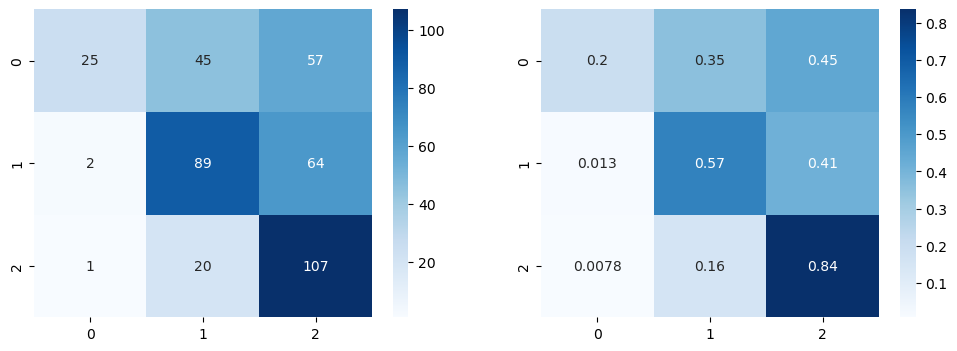

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

dtree = DecisionTreeClassifier(max_depth=2)
dtree.fit(X_train, y_train)
y_pred = dtree.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print('==Confusion Matrix==')

print(confusion_matrix(y_test,y_pred))

print('==Classification Report==')

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test,y_pred)
ac = accuracy_score(y_test, y_pred)
cm0 = confusion_matrix(y_test,y_pred, normalize="true")
cm1 = confusion_matrix(y_test,y_pred)

fig = plt.figure(figsize=(12,4))
plt.subplot(121)
sns.heatmap(cm1, annot=True, cmap='Blues',fmt='g')
plt.subplot(122)
sns.heatmap(cm0, annot=True, cmap='Blues')

In [13]:
master_df.index=pd.MultiIndex.from_tuples(
    [(str(level1), level2) for level1, level2 in df.index],
    names=[master_df.index.names[0], master_df.index.names[1]])

TypeError: cannot unpack non-iterable int object

#  tsfresh

In [4]:
import pandas as pd
from tsfresh.examples.har_dataset import download_har_dataset, load_har_dataset, load_har_classes
from tsfresh import extract_features, extract_relevant_features, select_features

#X.index = pd.MultiIndex.from_tuples([str(index) for index in X.index])

X = extract_features(master_df, column_id=1) 


Feature Extraction: 100%|██████████| 20/20 [01:21<00:00,  4.05s/it]


TypeError: Setting a MultiIndex dtype to anything other than object is not supported

In [4]:
master_df


,0,1
0,7.832858e-10,0
1,7.729383e-10,0
2,7.534507e-10,0
3,7.251567e-10,0
4,7.103801e-10,0
...,...,...
524283,1.110288e-09,2047
524284,1.110887e-09,2047
524285,1.116513e-09,2047
524286,1.121015e-09,2047


In [12]:
import pandas as pd
from tsfresh import extract_features


# if isinstance(df.columns, pd.core.indexes.multi.MultiIndex)
master_df.columns = ['.'.join(c) for c in master_df.columns]
# master_df.columns = master_df.columns.astype("str")

# Extract features using tsfresh
X = extract_features(master_df, column_id=1)

TypeError: can only join an iterable

In [16]:

from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

impute(X)
features_filtered = select_features(X, y)

C:\Users\Fahim\anaconda3\lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['0__autocorrelation__lag_0' '0__autocorrelation__lag_1'
 '0__autocorrelation__lag_2' '0__autocorrelation__lag_3'
 '0__autocorrelation__lag_4' '0__autocorrelation__lag_5'
 '0__autocorrelation__lag_6' '0__autocorrelation__lag_7'
 '0__autocorrelation__lag_8' '0__autocorrelation__lag_9'
 '0__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


In [10]:
from tsfresh import extract_relevant_features

X = extract_relevant_features(master_df, y, column_id=1)

Feature Extraction: 100%|██████████| 20/20 [01:20<00:00,  4.03s/it]


TypeError: Setting a MultiIndex dtype to anything other than object is not supported

In [8]:
X.shape

AttributeError: 'list' object has no attribute 'shape'

C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:34:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Data:
1.0
Test Data
0.7365853658536585
==cousion Matrix==
[[ 76  39  11]
 [ 19 126  23]
 [  7   9 100]]
==classsification Report==
              precision    recall  f1-score   support

           0       0.75      0.60      0.67       126
           1       0.72      0.75      0.74       168
           2       0.75      0.86      0.80       116

    accuracy                           0.74       410
   macro avg       0.74      0.74      0.73       410
weighted avg       0.74      0.74      0.73       410



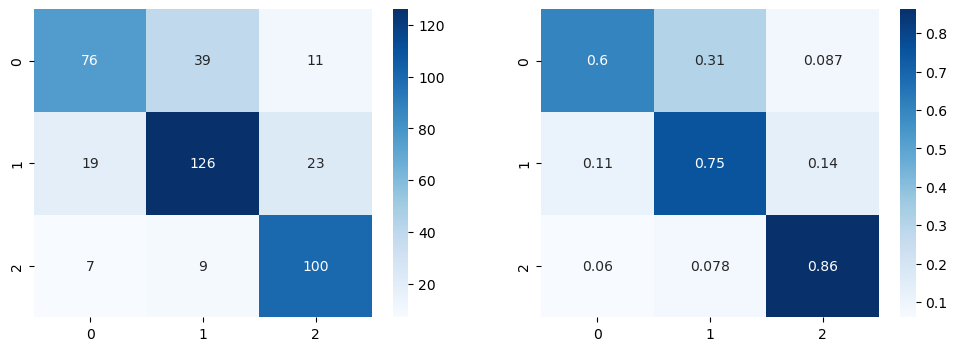

In [14]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2,random_state=1)

xgb_clf=xgb.XGBClassifier()
xgb_clf.fit(X_train,y_train)

xgb_pred_train=xgb_clf.predict(X_train)
xgb_pred_test=xgb_clf.predict(X_test)

Y_pred = xgb_pred_test

cm0 = confusion_matrix(y_test, Y_pred, normalize="true")
cm1 = confusion_matrix(y_test, Y_pred)

fig = plt.figure(figsize=(12,4))
plt.subplot(121)
sns.heatmap(cm1, annot=True, cmap='Blues',fmt='g')
plt.subplot(122)
sns.heatmap(cm0, annot=True, cmap='Blues')

print('Training Data:')
print(accuracy_score(y_train,xgb_pred_train))
print('Test Data')
print(accuracy_score(y_test,xgb_pred_test))
print('==cousion Matrix==')

print(confusion_matrix(y_test,xgb_pred_test))

print('==classsification Report==')

print(classification_report(y_test,xgb_pred_test))

# Optuna


In [31]:
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate, StratifiedKFold


def objective(trial):
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
    max_depth = trial.suggest_int('max_depth', 2, 11)
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    gamma = trial.suggest_uniform('gamma', 0.01, 5)
    clf1 = XGBClassifier(learning_rate=learning_rate,
                         max_depth=max_depth,
                         n_estimators=n_estimators,
                         min_child_weight=min_child_weight,
                         gamma=gamma,
                         use_label_encoder=False)
    for i in range(3):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=y, random_state=i)
        clf1.fit(X_train, y_train)
        y_pred = clf1.predict(X_test)
        cm = confusion_matrix(y_test, y_pred, normalize="true")
        score = cm[2,2]*0.4+(1-cm[1,2])*0.2+(1-cm[0,2])*0.4
    return score

#2.Create an Optuna Object
study = optuna.create_study(direction='maximize')
#3.Parameter search in Optuna
study.optimize(objective, n_trials=300)



[I 2023-05-19 14:59:18,743] A new study created in memory with name: no-name-20bf55f8-824c-450b-b55a-d2a49c39a897
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:59:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:59:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:59:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 14:59:56,765] Trial 0 finished with value: 0.8378674336716927 and parameters: {'learning_rate': 0.6872371482567824, 'max_depth': 5, 'n_estimators': 177, 'min_child_weight': 1, 'gamma': 3.484222537627386}. Best is trial 0 with value: 0.8378674336716927.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:59:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:00:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:00:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:00:36,335] Trial 1 finished with value: 0.8375789469158573 and parameters: {'learning_rate': 0.9271351272907077, 'max_depth': 7, 'n_estimators': 167, 'min_child_weight': 7, 'gamma': 3.615178478497237}. Best is trial 0 with value: 0.8378674336716927.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:00:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:00:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:01:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:01:28,943] Trial 2 finished with value: 0.8088334558649659 and parameters: {'learning_rate': 0.7832832602048728, 'max_depth': 11, 'n_estimators': 132, 'min_child_weight': 1, 'gamma': 1.9541323655834564}. Best is trial 0 with value: 0.8378674336716927.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:01:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:01:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:01:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:01:45,754] Trial 3 finished with value: 0.831764068566122 and parameters: {'learning_rate': 0.2877631671172808, 'max_depth': 4, 'n_estimators': 108, 'min_child_weight': 8, 'gamma': 2.786362538045292}. Best is trial 0 with value: 0.8378674336716927.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:01:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:01:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:01:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:01:57,259] Trial 4 finished with value: 0.8110609519633007 and parameters: {'learning_rate': 0.8541875256409496, 'max_depth': 5, 'n_estimators': 59, 'min_child_weight': 5, 'gamma': 2.3119783928838946}. Best is trial 0 with value: 0.8378674336716927.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:01:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:02:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:02:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:02:59,563] Trial 5 finished with value: 0.836765938785776 and parameters: {'learning_rate': 0.30577556099886927, 'max_depth': 8, 'n_estimators': 193, 'min_child_weight': 1, 'gamma': 1.7180060722072572}. Best is trial 0 with value: 0.8378674336716927.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:02:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:03:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:03:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:03:21,375] Trial 6 finished with value: 0.8465400936399634 and parameters: {'learning_rate': 0.5712905921847078, 'max_depth': 4, 'n_estimators': 128, 'min_child_weight': 3, 'gamma': 4.617991907195514}. Best is trial 6 with value: 0.8465400936399634.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:03:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:03:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:04:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:04:25,709] Trial 7 finished with value: 0.8023530372797119 and parameters: {'learning_rate': 0.9537473128966084, 'max_depth': 10, 'n_estimators': 163, 'min_child_weight': 1, 'gamma': 3.1543867860586285}. Best is trial 6 with value: 0.8465400936399634.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:04:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:04:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:04:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:04:47,885] Trial 8 finished with value: 0.8352521357048579 and parameters: {'learning_rate': 0.8718680228026412, 'max_depth': 7, 'n_estimators': 93, 'min_child_weight': 6, 'gamma': 2.4655771632245047}. Best is trial 6 with value: 0.8465400936399634.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:04:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:04:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:05:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:05:14,925] Trial 9 finished with value: 0.8350694130949771 and parameters: {'learning_rate': 0.45527820633348237, 'max_depth': 8, 'n_estimators': 114, 'min_child_weight': 9, 'gamma': 2.451907607851324}. Best is trial 6 with value: 0.8465400936399634.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:05:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:05:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:05:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:05:27,428] Trial 10 finished with value: 0.8205934830368928 and parameters: {'learning_rate': 0.03942095446673477, 'max_depth': 2, 'n_estimators': 140, 'min_child_weight': 4, 'gamma': 4.635668365200264}. Best is trial 6 with value: 0.8465400936399634.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:05:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:05:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:05:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:05:57,141] Trial 11 finished with value: 0.8380854109968916 and parameters: {'learning_rate': 0.6047518370483547, 'max_depth': 4, 'n_estimators': 199, 'min_child_weight': 3, 'gamma': 0.3877897646635695}. Best is trial 6 with value: 0.8465400936399634.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:05:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:06:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:06:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:06:14,101] Trial 12 finished with value: 0.8338023930212861 and parameters: {'learning_rate': 0.5864929688547169, 'max_depth': 2, 'n_estimators': 200, 'min_child_weight': 3, 'gamma': 0.21416264588708533}. Best is trial 6 with value: 0.8465400936399634.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:06:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:06:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:06:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:06:25,410] Trial 13 finished with value: 0.8429815170705912 and parameters: {'learning_rate': 0.49187786651504317, 'max_depth': 4, 'n_estimators': 75, 'min_child_weight': 3, 'gamma': 0.04470810841216072}. Best is trial 6 with value: 0.8465400936399634.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:06:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:06:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:06:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:06:34,295] Trial 14 finished with value: 0.8418800221846745 and parameters: {'learning_rate': 0.4512217977817246, 'max_depth': 3, 'n_estimators': 68, 'min_child_weight': 3, 'gamma': 1.2185617402606328}. Best is trial 6 with value: 0.8465400936399634.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:06:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:06:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:06:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:06:50,819] Trial 15 finished with value: 0.859619593023006 and parameters: {'learning_rate': 0.3202396009327445, 'max_depth': 5, 'n_estimators': 80, 'min_child_weight': 5, 'gamma': 4.720903501582102}. Best is trial 15 with value: 0.859619593023006.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:06:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:06:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:07:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:07:12,760] Trial 16 finished with value: 0.8429995743638029 and parameters: {'learning_rate': 0.22995042431280682, 'max_depth': 6, 'n_estimators': 91, 'min_child_weight': 5, 'gamma': 4.958700761458025}. Best is trial 15 with value: 0.859619593023006.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:07:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:07:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:07:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:07:44,891] Trial 17 finished with value: 0.8482194219086558 and parameters: {'learning_rate': 0.14195498926704014, 'max_depth': 6, 'n_estimators': 148, 'min_child_weight': 10, 'gamma': 4.205965580415185}. Best is trial 15 with value: 0.859619593023006.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:07:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:07:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:08:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:08:28,808] Trial 18 finished with value: 0.85174274376271 and parameters: {'learning_rate': 0.09568851046815308, 'max_depth': 9, 'n_estimators': 154, 'min_child_weight': 9, 'gamma': 4.076229517043733}. Best is trial 15 with value: 0.859619593023006.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:08:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:08:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:08:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:08:45,225] Trial 19 finished with value: 0.8398885607047505 and parameters: {'learning_rate': 0.0676547811354458, 'max_depth': 9, 'n_estimators': 53, 'min_child_weight': 7, 'gamma': 3.9617454662180047}. Best is trial 15 with value: 0.859619593023006.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:08:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:08:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:09:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:09:11,783] Trial 20 finished with value: 0.836765938785776 and parameters: {'learning_rate': 0.3570171032605552, 'max_depth': 11, 'n_estimators': 90, 'min_child_weight': 10, 'gamma': 4.150690345409807}. Best is trial 15 with value: 0.859619593023006.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:09:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:09:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:09:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:09:43,666] Trial 21 finished with value: 0.8672965222513146 and parameters: {'learning_rate': 0.17331272253138102, 'max_depth': 6, 'n_estimators': 145, 'min_child_weight': 10, 'gamma': 4.264584691053778}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:09:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:09:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:10:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:10:24,494] Trial 22 finished with value: 0.8436298598840034 and parameters: {'learning_rate': 0.1368586647083087, 'max_depth': 8, 'n_estimators': 153, 'min_child_weight': 9, 'gamma': 4.867225389456094}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:10:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:10:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:10:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:10:56,011] Trial 23 finished with value: 0.8455443629000012 and parameters: {'learning_rate': 0.1701154233250217, 'max_depth': 9, 'n_estimators': 115, 'min_child_weight': 9, 'gamma': 4.336331526773224}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:10:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:11:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:11:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:11:29,958] Trial 24 finished with value: 0.8594785741617332 and parameters: {'learning_rate': 0.38917774479827044, 'max_depth': 5, 'n_estimators': 178, 'min_child_weight': 7, 'gamma': 3.5753852566220146}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:11:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:11:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:11:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:12:04,247] Trial 25 finished with value: 0.8390991990300655 and parameters: {'learning_rate': 0.3836191470852444, 'max_depth': 5, 'n_estimators': 177, 'min_child_weight': 6, 'gamma': 3.653375834183493}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:12:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:12:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:12:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:12:43,985] Trial 26 finished with value: 0.8384272097612568 and parameters: {'learning_rate': 0.23124350537999042, 'max_depth': 6, 'n_estimators': 180, 'min_child_weight': 7, 'gamma': 3.039485648055516}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:12:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:12:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:12:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:13:01,132] Trial 27 finished with value: 0.8338729024519225 and parameters: {'learning_rate': 0.37515987462670486, 'max_depth': 3, 'n_estimators': 142, 'min_child_weight': 8, 'gamma': 4.498190315093463}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:13:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:13:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:13:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:13:22,285] Trial 28 finished with value: 0.8319403421427128 and parameters: {'learning_rate': 0.2326731121792102, 'max_depth': 5, 'n_estimators': 104, 'min_child_weight': 4, 'gamma': 3.8462805276845495}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:13:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:13:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:13:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:13:55,128] Trial 29 finished with value: 0.8242462154922978 and parameters: {'learning_rate': 0.7233868629251523, 'max_depth': 5, 'n_estimators': 178, 'min_child_weight': 8, 'gamma': 3.314576664556754}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:13:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:14:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:14:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:14:37,727] Trial 30 finished with value: 0.8310568245819951 and parameters: {'learning_rate': 0.2974128112156932, 'max_depth': 7, 'n_estimators': 168, 'min_child_weight': 6, 'gamma': 3.4425970203201515}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:14:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:14:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:15:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:15:11,381] Trial 31 finished with value: 0.8564380699333171 and parameters: {'learning_rate': 0.10306381972232598, 'max_depth': 6, 'n_estimators': 157, 'min_child_weight': 10, 'gamma': 3.965068130509136}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:15:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:15:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:15:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:15:46,645] Trial 32 finished with value: 0.8563323057873625 and parameters: {'learning_rate': 0.18432619132511907, 'max_depth': 6, 'n_estimators': 163, 'min_child_weight': 10, 'gamma': 4.450206607955127}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:15:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:16:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:16:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:16:29,918] Trial 33 finished with value: 0.8461810974534918 and parameters: {'learning_rate': 0.3351348510645644, 'max_depth': 7, 'n_estimators': 186, 'min_child_weight': 10, 'gamma': 3.8151557366463553}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:16:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:16:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:16:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:16:59,962] Trial 34 finished with value: 0.8384977191918932 and parameters: {'learning_rate': 0.4161381885148769, 'max_depth': 6, 'n_estimators': 138, 'min_child_weight': 7, 'gamma': 2.8673749478465367}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:17:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:17:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:17:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:17:21,953] Trial 35 finished with value: 0.8288473857768721 and parameters: {'learning_rate': 0.011067088555019727, 'max_depth': 3, 'n_estimators': 168, 'min_child_weight': 5, 'gamma': 3.577028662251692}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:17:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:17:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:17:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:17:45,914] Trial 36 finished with value: 0.8441010692497195 and parameters: {'learning_rate': 0.2579357293611788, 'max_depth': 5, 'n_estimators': 125, 'min_child_weight': 8, 'gamma': 4.742257397900688}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:17:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:17:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:18:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:18:12,188] Trial 37 finished with value: 0.850693701014218 and parameters: {'learning_rate': 0.10547232589513209, 'max_depth': 4, 'n_estimators': 157, 'min_child_weight': 4, 'gamma': 4.333044785949163}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:18:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:18:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:18:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:18:36,668] Trial 38 finished with value: 0.8489266658927828 and parameters: {'learning_rate': 0.537620903125644, 'max_depth': 6, 'n_estimators': 123, 'min_child_weight': 9, 'gamma': 2.0218396873503615}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:18:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:18:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:19:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:19:12,250] Trial 39 finished with value: 0.8427635397453922 and parameters: {'learning_rate': 0.6518630552206766, 'max_depth': 5, 'n_estimators': 188, 'min_child_weight': 8, 'gamma': 4.982658600806629}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:19:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:19:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:19:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:19:54,644] Trial 40 finished with value: 0.8473359043479383 and parameters: {'learning_rate': 0.1844801078126057, 'max_depth': 7, 'n_estimators': 146, 'min_child_weight': 2, 'gamma': 3.743584685702556}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:19:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:20:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:20:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:20:28,400] Trial 41 finished with value: 0.8514714544289812 and parameters: {'learning_rate': 0.1870676442858976, 'max_depth': 6, 'n_estimators': 159, 'min_child_weight': 10, 'gamma': 4.460335986527536}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:20:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:20:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:20:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:20:59,540] Trial 42 finished with value: 0.8410317593392751 and parameters: {'learning_rate': 0.2911840973573713, 'max_depth': 5, 'n_estimators': 169, 'min_child_weight': 10, 'gamma': 4.054301510062234}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:20:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:21:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:21:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:21:33,610] Trial 43 finished with value: 0.8555545523725994 and parameters: {'learning_rate': 0.1960790975924861, 'max_depth': 6, 'n_estimators': 161, 'min_child_weight': 10, 'gamma': 4.672372020082053}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:21:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:21:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:22:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:22:17,455] Trial 44 finished with value: 0.8443543012902366 and parameters: {'learning_rate': 0.3302968508986627, 'max_depth': 8, 'n_estimators': 171, 'min_child_weight': 9, 'gamma': 3.330509344790613}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:22:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:22:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:22:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:22:38,558] Trial 45 finished with value: 0.8476949005344099 and parameters: {'learning_rate': 0.11716500826028024, 'max_depth': 4, 'n_estimators': 131, 'min_child_weight': 7, 'gamma': 4.506086791519536}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:22:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:22:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:23:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:23:11,377] Trial 46 finished with value: 0.8482546766239741 and parameters: {'learning_rate': 0.061934212014531205, 'max_depth': 7, 'n_estimators': 134, 'min_child_weight': 9, 'gamma': 4.326350590681194}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:23:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:23:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:23:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:23:41,026] Trial 47 finished with value: 0.843682312021428 and parameters: {'learning_rate': 0.4267707691592692, 'max_depth': 5, 'n_estimators': 149, 'min_child_weight': 5, 'gamma': 3.942737220604552}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:23:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:23:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:23:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:23:57,583] Trial 48 finished with value: 0.8489619206081009 and parameters: {'learning_rate': 0.5016202804284015, 'max_depth': 7, 'n_estimators': 76, 'min_child_weight': 10, 'gamma': 2.7411648903086654}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:23:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:24:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:24:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:24:28,989] Trial 49 finished with value: 0.8429815170705912 and parameters: {'learning_rate': 0.2689632802163389, 'max_depth': 4, 'n_estimators': 193, 'min_child_weight': 6, 'gamma': 4.624397632773772}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:24:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:24:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:24:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:25:01,798] Trial 50 finished with value: 0.8405777473956655 and parameters: {'learning_rate': 0.2183451081750643, 'max_depth': 6, 'n_estimators': 163, 'min_child_weight': 8, 'gamma': 1.1663775203167455}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:25:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:25:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:25:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:25:37,159] Trial 51 finished with value: 0.8458156522337302 and parameters: {'learning_rate': 0.15940035403430117, 'max_depth': 6, 'n_estimators': 164, 'min_child_weight': 10, 'gamma': 4.675092093625191}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:25:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:25:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:26:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:26:13,863] Trial 52 finished with value: 0.844301849152812 and parameters: {'learning_rate': 0.20136013231132685, 'max_depth': 6, 'n_estimators': 172, 'min_child_weight': 10, 'gamma': 4.832240942102442}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:26:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:26:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:26:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:26:46,149] Trial 53 finished with value: 0.8476949005344099 and parameters: {'learning_rate': 0.06869763404904086, 'max_depth': 5, 'n_estimators': 159, 'min_child_weight': 10, 'gamma': 4.213286107555619}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:26:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:26:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:27:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:27:20,906] Trial 54 finished with value: 0.8299553296960785 and parameters: {'learning_rate': 0.262635942180707, 'max_depth': 7, 'n_estimators': 144, 'min_child_weight': 9, 'gamma': 4.470026347624451}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:27:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:27:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:27:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:28:06,110] Trial 55 finished with value: 0.8484373992338549 and parameters: {'learning_rate': 0.31905149120170906, 'max_depth': 8, 'n_estimators': 175, 'min_child_weight': 9, 'gamma': 4.137967636283737}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:28:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:28:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:28:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:28:45,989] Trial 56 finished with value: 0.8525557518927913 and parameters: {'learning_rate': 0.13503604534943098, 'max_depth': 6, 'n_estimators': 184, 'min_child_weight': 10, 'gamma': 4.768779791207985}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:28:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:28:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:29:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:29:12,233] Trial 57 finished with value: 0.8466639150791297 and parameters: {'learning_rate': 0.02792288131326029, 'max_depth': 4, 'n_estimators': 154, 'min_child_weight': 4, 'gamma': 3.965857288788401}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:29:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:29:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:29:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:29:30,745] Trial 58 finished with value: 0.8479481325749271 and parameters: {'learning_rate': 0.41445909033188044, 'max_depth': 5, 'n_estimators': 98, 'min_child_weight': 10, 'gamma': 4.273047597403851}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:29:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:29:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:29:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:44:19,622] Trial 59 finished with value: 0.8420210410459472 and parameters: {'learning_rate': 0.10268215675815773, 'max_depth': 6, 'n_estimators': 118, 'min_child_weight': 9, 'gamma': 3.548888101690901}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:44:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:44:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:44:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:44:56,261] Trial 60 finished with value: 0.8407015688348318 and parameters: {'learning_rate': 0.16033106479904535, 'max_depth': 5, 'n_estimators': 151, 'min_child_weight': 2, 'gamma': 4.95687192008173}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:44:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:45:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:45:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:45:36,231] Trial 61 finished with value: 0.8542170228682722 and parameters: {'learning_rate': 0.1266010609495619, 'max_depth': 6, 'n_estimators': 183, 'min_child_weight': 10, 'gamma': 4.732412921214698}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:45:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:45:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:46:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:46:17,615] Trial 62 finished with value: 0.8536753040719196 and parameters: {'learning_rate': 0.06165606977636133, 'max_depth': 7, 'n_estimators': 164, 'min_child_weight': 9, 'gamma': 4.577376276255827}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:46:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:46:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:46:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:46:59,752] Trial 63 finished with value: 0.8523377745675924 and parameters: {'learning_rate': 0.20731771995324141, 'max_depth': 6, 'n_estimators': 194, 'min_child_weight': 10, 'gamma': 4.770372798077442}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:46:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:47:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:47:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:47:33,401] Trial 64 finished with value: 0.8408842914447124 and parameters: {'learning_rate': 0.2446584040678087, 'max_depth': 5, 'n_estimators': 181, 'min_child_weight': 10, 'gamma': 4.460016040557495}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:47:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:47:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:48:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:48:15,595] Trial 65 finished with value: 0.8386632443796675 and parameters: {'learning_rate': 0.09466888981764998, 'max_depth': 6, 'n_estimators': 174, 'min_child_weight': 5, 'gamma': 4.071165172458673}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:48:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:48:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:48:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:48:48,991] Trial 66 finished with value: 0.8454385987540468 and parameters: {'learning_rate': 0.35692776084109024, 'max_depth': 7, 'n_estimators': 139, 'min_child_weight': 9, 'gamma': 3.80959847965003}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:48:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:48:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:49:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:49:08,238] Trial 67 finished with value: 0.850475723689019 and parameters: {'learning_rate': 0.13833997907921708, 'max_depth': 6, 'n_estimators': 83, 'min_child_weight': 6, 'gamma': 4.344953547554752}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:49:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:49:16] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:49:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:49:33,159] Trial 68 finished with value: 0.8285644881832215 and parameters: {'learning_rate': 0.4568747836522289, 'max_depth': 4, 'n_estimators': 159, 'min_child_weight': 10, 'gamma': 4.650139249609242}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:49:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:49:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:49:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:49:43,315] Trial 69 finished with value: 0.8364241400214107 and parameters: {'learning_rate': 0.8896734670396516, 'max_depth': 5, 'n_estimators': 53, 'min_child_weight': 8, 'gamma': 4.995540635281585}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:49:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:49:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:50:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:50:24,269] Trial 70 finished with value: 0.840507237965029 and parameters: {'learning_rate': 0.28033715584285374, 'max_depth': 6, 'n_estimators': 188, 'min_child_weight': 9, 'gamma': 3.1006645894565494}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:50:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:50:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:50:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:51:03,647] Trial 71 finished with value: 0.8512182223884641 and parameters: {'learning_rate': 0.07535299629946106, 'max_depth': 7, 'n_estimators': 162, 'min_child_weight': 10, 'gamma': 4.547358816858227}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:51:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:51:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:51:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:51:45,950] Trial 72 finished with value: 0.8520664852338635 and parameters: {'learning_rate': 0.055103711695736746, 'max_depth': 7, 'n_estimators': 165, 'min_child_weight': 9, 'gamma': 4.845122317055686}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:51:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:52:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:52:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:52:34,833] Trial 73 finished with value: 0.8577403447223262 and parameters: {'learning_rate': 0.030176751409755523, 'max_depth': 8, 'n_estimators': 182, 'min_child_weight': 10, 'gamma': 4.204424262027819}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:52:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:52:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:53:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:53:31,596] Trial 74 finished with value: 0.8479661898681388 and parameters: {'learning_rate': 0.036395586331498024, 'max_depth': 9, 'n_estimators': 197, 'min_child_weight': 10, 'gamma': 3.9511539708140897}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:53:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:53:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:54:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:54:18,069] Trial 75 finished with value: 0.8411375234852296 and parameters: {'learning_rate': 0.16599726450878305, 'max_depth': 8, 'n_estimators': 182, 'min_child_weight': 10, 'gamma': 3.6510941506594277}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:54:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:54:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:54:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:54:34,474] Trial 76 finished with value: 0.8539637908277549 and parameters: {'learning_rate': 0.11347452519744124, 'max_depth': 6, 'n_estimators': 65, 'min_child_weight': 5, 'gamma': 4.25014176785539}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:54:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:54:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:55:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:55:13,720] Trial 77 finished with value: 0.8551185977222016 and parameters: {'learning_rate': 0.013716007032647012, 'max_depth': 5, 'n_estimators': 191, 'min_child_weight': 10, 'gamma': 4.403849112448292}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:55:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:55:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:55:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:55:53,095] Trial 78 finished with value: 0.8487022395342938 and parameters: {'learning_rate': 0.010423708240393487, 'max_depth': 5, 'n_estimators': 192, 'min_child_weight': 7, 'gamma': 4.385875463828373}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:55:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:56:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:56:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:56:30,254] Trial 79 finished with value: 0.8487086885675837 and parameters: {'learning_rate': 0.08779089824896631, 'max_depth': 10, 'n_estimators': 108, 'min_child_weight': 4, 'gamma': 3.3480779022866707}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:56:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:56:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:56:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:56:51,514] Trial 80 finished with value: 0.8494094835184207 and parameters: {'learning_rate': 0.18580257164319533, 'max_depth': 3, 'n_estimators': 176, 'min_child_weight': 8, 'gamma': 4.161566416308875}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:56:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:57:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:57:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:57:25,240] Trial 81 finished with value: 0.8504404689737008 and parameters: {'learning_rate': 0.1242882707699701, 'max_depth': 5, 'n_estimators': 179, 'min_child_weight': 10, 'gamma': 4.714771851307523}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:57:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:57:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:57:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:58:06,875] Trial 82 finished with value: 0.8563675605026807 and parameters: {'learning_rate': 0.03325585989809743, 'max_depth': 6, 'n_estimators': 189, 'min_child_weight': 10, 'gamma': 4.3996521790352885}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:58:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:58:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:58:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:58:42,816] Trial 83 finished with value: 0.8579935767628433 and parameters: {'learning_rate': 0.04647012759463616, 'max_depth': 5, 'n_estimators': 188, 'min_child_weight': 9, 'gamma': 3.734951784810902}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:58:42] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:59:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:59:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 15:59:39,521] Trial 84 finished with value: 0.8438830919245206 and parameters: {'learning_rate': 0.051271488017746045, 'max_depth': 10, 'n_estimators': 188, 'min_child_weight': 9, 'gamma': 3.8371827481678586}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:59:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:59:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:00:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:00:11,485] Trial 85 finished with value: 0.8468466376890105 and parameters: {'learning_rate': 0.04063409935804809, 'max_depth': 4, 'n_estimators': 199, 'min_child_weight': 9, 'gamma': 3.691437509486627}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:00:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:00:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:00:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:00:48,824] Trial 86 finished with value: 0.8415562807135211 and parameters: {'learning_rate': 0.5405414098811588, 'max_depth': 6, 'n_estimators': 167, 'min_child_weight': 10, 'gamma': 4.0147514575165415}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:00:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:01:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:01:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:01:21,741] Trial 87 finished with value: 0.8482899313392923 and parameters: {'learning_rate': 0.1536795377618657, 'max_depth': 5, 'n_estimators': 172, 'min_child_weight': 10, 'gamma': 4.130299476880047}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:01:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:01:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:01:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:02:01,834] Trial 88 finished with value: 0.8378854909649044 and parameters: {'learning_rate': 0.2292065061794512, 'max_depth': 7, 'n_estimators': 156, 'min_child_weight': 6, 'gamma': 3.458501702042099}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:02:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:02:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:02:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:02:31,935] Trial 89 finished with value: 0.8492856620792544 and parameters: {'learning_rate': 0.08887132430095313, 'max_depth': 6, 'n_estimators': 149, 'min_child_weight': 9, 'gamma': 0.9355037094561076}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:02:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:02:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:02:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:02:55,403] Trial 90 finished with value: 0.8505879368682635 and parameters: {'learning_rate': 0.3062389043134845, 'max_depth': 5, 'n_estimators': 136, 'min_child_weight': 10, 'gamma': 1.661865667189417}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:02:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:03:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:03:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:03:32,086] Trial 91 finished with value: 0.8480014445834569 and parameters: {'learning_rate': 0.02584596644999821, 'max_depth': 5, 'n_estimators': 192, 'min_child_weight': 10, 'gamma': 4.381252515913584}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:03:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:03:42] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:03:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:04:01,882] Trial 92 finished with value: 0.8503699595430645 and parameters: {'learning_rate': 0.07738520374361352, 'max_depth': 4, 'n_estimators': 189, 'min_child_weight': 10, 'gamma': 4.58246869235796}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:04:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:04:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:04:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:04:36,167] Trial 93 finished with value: 0.8372724028668103 and parameters: {'learning_rate': 0.7993323147984296, 'max_depth': 5, 'n_estimators': 184, 'min_child_weight': 9, 'gamma': 4.228469299348711}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:04:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:04:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:05:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:05:15,096] Trial 94 finished with value: 0.8541817681529539 and parameters: {'learning_rate': 0.03838999926380629, 'max_depth': 6, 'n_estimators': 178, 'min_child_weight': 10, 'gamma': 3.8898174603540117}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:05:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:05:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:05:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:05:52,696] Trial 95 finished with value: 0.8567093592670458 and parameters: {'learning_rate': 0.01790664734252717, 'max_depth': 5, 'n_estimators': 195, 'min_child_weight': 10, 'gamma': 3.2360544769715833}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:05:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:06:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:06:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:06:38,582] Trial 96 finished with value: 0.852390226705017 and parameters: {'learning_rate': 0.3853917567901838, 'max_depth': 6, 'n_estimators': 196, 'min_child_weight': 5, 'gamma': 3.0078588770760954}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:06:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:06:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:07:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:07:14,795] Trial 97 finished with value: 0.8446255906239655 and parameters: {'learning_rate': 0.1806942004678209, 'max_depth': 5, 'n_estimators': 200, 'min_child_weight': 10, 'gamma': 2.5938589295959047}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:07:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:07:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:07:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:07:49,746] Trial 98 finished with value: 0.8542522775835902 and parameters: {'learning_rate': 0.10694875903179826, 'max_depth': 6, 'n_estimators': 161, 'min_child_weight': 9, 'gamma': 3.4331396460648937}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:07:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:08:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:08:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:08:33,230] Trial 99 finished with value: 0.8476596458190917 and parameters: {'learning_rate': 0.1401729611690623, 'max_depth': 8, 'n_estimators': 185, 'min_child_weight': 10, 'gamma': 2.1791062834292783}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:08:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:08:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:08:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:09:11,599] Trial 100 finished with value: 0.8388812217048665 and parameters: {'learning_rate': 0.20765583830126272, 'max_depth': 6, 'n_estimators': 170, 'min_child_weight': 7, 'gamma': 3.233354235893262}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:09:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:09:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:09:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:09:49,784] Trial 101 finished with value: 0.8583706302425267 and parameters: {'learning_rate': 0.015061811389305945, 'max_depth': 5, 'n_estimators': 196, 'min_child_weight': 10, 'gamma': 3.7585145194823424}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:09:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:10:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:10:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:10:20,489] Trial 102 finished with value: 0.854959521567717 and parameters: {'learning_rate': 0.052739037373664976, 'max_depth': 4, 'n_estimators': 196, 'min_child_weight': 10, 'gamma': 3.7596735077754087}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:10:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:10:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:10:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:10:55,349] Trial 103 finished with value: 0.8495922061283014 and parameters: {'learning_rate': 0.07168398214662841, 'max_depth': 5, 'n_estimators': 186, 'min_child_weight': 10, 'gamma': 3.6117101123238835}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:10:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:11:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:11:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:11:24,306] Trial 104 finished with value: 0.8410433675991968 and parameters: {'learning_rate': 0.010661736133536348, 'max_depth': 5, 'n_estimators': 143, 'min_child_weight': 9, 'gamma': 4.061757333496698}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:11:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:11:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:11:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:12:01,554] Trial 105 finished with value: 0.8476243911037735 and parameters: {'learning_rate': 0.08779062656248889, 'max_depth': 6, 'n_estimators': 174, 'min_child_weight': 10, 'gamma': 3.498893757862674}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:12:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:12:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:12:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:12:31,357] Trial 106 finished with value: 0.8528794933639448 and parameters: {'learning_rate': 0.108231904756117, 'max_depth': 4, 'n_estimators': 195, 'min_child_weight': 10, 'gamma': 3.9092466798512335}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:12:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:12:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:12:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:13:00,565] Trial 107 finished with value: 0.8534040147381907 and parameters: {'learning_rate': 0.03319673243072846, 'max_depth': 5, 'n_estimators': 154, 'min_child_weight': 10, 'gamma': 3.685278957001324}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:13:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:13:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:13:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:13:39,286] Trial 108 finished with value: 0.8574338006732791 and parameters: {'learning_rate': 0.056604120587669136, 'max_depth': 6, 'n_estimators': 180, 'min_child_weight': 9, 'gamma': 3.2140600659036833}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:13:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:13:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:14:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:14:23,789] Trial 109 finished with value: 0.8455796176153195 and parameters: {'learning_rate': 0.054501834457760516, 'max_depth': 7, 'n_estimators': 180, 'min_child_weight': 8, 'gamma': 3.164135550392361}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:14:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:14:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:14:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:15:05,737] Trial 110 finished with value: 0.8439183466398388 and parameters: {'learning_rate': 0.027944302743056083, 'max_depth': 6, 'n_estimators': 190, 'min_child_weight': 9, 'gamma': 3.0219757666974765}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:15:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:15:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:15:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:15:46,211] Trial 111 finished with value: 0.8577755994376444 and parameters: {'learning_rate': 0.07164256221123647, 'max_depth': 6, 'n_estimators': 187, 'min_child_weight': 9, 'gamma': 4.881762462451974}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:15:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:15:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:16:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:16:26,756] Trial 112 finished with value: 0.8507289557295362 and parameters: {'learning_rate': 0.07912841802695264, 'max_depth': 6, 'n_estimators': 186, 'min_child_weight': 9, 'gamma': 3.304189623469889}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:16:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:16:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:16:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:17:01,024] Trial 113 finished with value: 0.8520664852338635 and parameters: {'learning_rate': 0.04749772625133374, 'max_depth': 5, 'n_estimators': 182, 'min_child_weight': 9, 'gamma': 2.9134286016415927}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:17:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:17:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:17:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:17:37,233] Trial 114 finished with value: 0.8425455624201932 and parameters: {'learning_rate': 0.1219619799963902, 'max_depth': 5, 'n_estimators': 193, 'min_child_weight': 9, 'gamma': 4.267354281021553}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:17:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:17:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:18:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:18:21,591] Trial 115 finished with value: 0.8499159475994549 and parameters: {'learning_rate': 0.06373283899663168, 'max_depth': 6, 'n_estimators': 198, 'min_child_weight': 8, 'gamma': 4.862584216283622}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:18:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:18:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:18:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:18:57,932] Trial 116 finished with value: 0.8383395029085141 and parameters: {'learning_rate': 0.986174203800956, 'max_depth': 6, 'n_estimators': 188, 'min_child_weight': 10, 'gamma': 3.559175828180703}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:18:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:19:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:19:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:19:29,558] Trial 117 finished with value: 0.8446608453392837 and parameters: {'learning_rate': 0.14821511397039633, 'max_depth': 7, 'n_estimators': 128, 'min_child_weight': 8, 'gamma': 4.507213279098955}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:19:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:19:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:19:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:20:01,789] Trial 118 finished with value: 0.8498454381688185 and parameters: {'learning_rate': 0.4820865916732232, 'max_depth': 5, 'n_estimators': 174, 'min_child_weight': 9, 'gamma': 3.7549352118238972}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:20:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:20:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:20:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:20:42,203] Trial 119 finished with value: 0.8538515776485105 and parameters: {'learning_rate': 0.012052760364181056, 'max_depth': 6, 'n_estimators': 178, 'min_child_weight': 10, 'gamma': 4.010996586990675}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:20:42] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:21:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:21:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:21:44,102] Trial 120 finished with value: 0.8319936541512427 and parameters: {'learning_rate': 0.6221340016150155, 'max_depth': 11, 'n_estimators': 191, 'min_child_weight': 5, 'gamma': 4.140114931188563}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:21:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:21:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:22:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:22:20,182] Trial 121 finished with value: 0.8408842914447124 and parameters: {'learning_rate': 0.24844138901526464, 'max_depth': 6, 'n_estimators': 167, 'min_child_weight': 10, 'gamma': 4.599583154975712}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:22:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:22:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:22:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:22:59,293] Trial 122 finished with value: 0.8543227870142266 and parameters: {'learning_rate': 0.08878388463584377, 'max_depth': 6, 'n_estimators': 181, 'min_child_weight': 10, 'gamma': 4.904588746012232}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:22:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:23:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:23:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:23:33,953] Trial 123 finished with value: 0.8438478372092024 and parameters: {'learning_rate': 0.3445928605723544, 'max_depth': 5, 'n_estimators': 184, 'min_child_weight': 10, 'gamma': 4.69815707965645}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:23:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:23:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:23:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:24:06,439] Trial 124 finished with value: 0.85613152588427 and parameters: {'learning_rate': 0.16942615315254733, 'max_depth': 6, 'n_estimators': 151, 'min_child_weight': 10, 'gamma': 4.429113410405163}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:24:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:24:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:24:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:24:44,207] Trial 125 finished with value: 0.8471531817380575 and parameters: {'learning_rate': 0.10502175032789199, 'max_depth': 7, 'n_estimators': 145, 'min_child_weight': 6, 'gamma': 4.422317669917252}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:24:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:24:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:25:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:25:25,839] Trial 126 finished with value: 0.829807861801516 and parameters: {'learning_rate': 0.16767703170427173, 'max_depth': 9, 'n_estimators': 150, 'min_child_weight': 9, 'gamma': 4.340085434683423}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:25:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:25:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:25:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:26:00,452] Trial 127 finished with value: 0.8491029394693737 and parameters: {'learning_rate': 0.03467038670051724, 'max_depth': 6, 'n_estimators': 156, 'min_child_weight': 10, 'gamma': 3.8802546186256643}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:26:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:26:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:26:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:26:37,091] Trial 128 finished with value: 0.8504052142583827 and parameters: {'learning_rate': 0.06525988247521633, 'max_depth': 5, 'n_estimators': 195, 'min_child_weight': 10, 'gamma': 3.401155936565185}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:26:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:26:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:26:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:26:47,537] Trial 129 finished with value: 0.8354817212899788 and parameters: {'learning_rate': 0.12548265151829652, 'max_depth': 2, 'n_estimators': 121, 'min_child_weight': 10, 'gamma': 4.7841005722251815}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:26:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:26:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:26:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:26:59,814] Trial 130 finished with value: 0.8515600211528292 and parameters: {'learning_rate': 0.04794465296687436, 'max_depth': 5, 'n_estimators': 62, 'min_child_weight': 9, 'gamma': 2.695721248297506}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:26:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:27:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:27:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:27:31,873] Trial 131 finished with value: 0.8482899313392923 and parameters: {'learning_rate': 0.1955407480360729, 'max_depth': 6, 'n_estimators': 147, 'min_child_weight': 10, 'gamma': 4.626976257229741}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:27:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:27:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:27:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:28:04,193] Trial 132 finished with value: 0.8411727782005478 and parameters: {'learning_rate': 0.27112328999893986, 'max_depth': 6, 'n_estimators': 152, 'min_child_weight': 10, 'gamma': 4.22338904386393}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:28:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:28:16] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:28:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:28:39,232] Trial 133 finished with value: 0.8607038904868161 and parameters: {'learning_rate': 0.22494049376495576, 'max_depth': 6, 'n_estimators': 162, 'min_child_weight': 10, 'gamma': 4.488752017604997}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:28:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:28:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:29:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:29:16,995] Trial 134 finished with value: 0.8446961000546018 and parameters: {'learning_rate': 0.22379427953128397, 'max_depth': 7, 'n_estimators': 159, 'min_child_weight': 10, 'gamma': 4.471525761663655}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:29:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:29:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:29:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:29:53,244] Trial 135 finished with value: 0.8463221163147645 and parameters: {'learning_rate': 0.1733611351606407, 'max_depth': 6, 'n_estimators': 165, 'min_child_weight': 9, 'gamma': 4.322979360878339}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:29:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:29:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:30:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:30:08,742] Trial 136 finished with value: 0.8422390183711462 and parameters: {'learning_rate': 0.3980892749022894, 'max_depth': 6, 'n_estimators': 73, 'min_child_weight': 10, 'gamma': 4.100690437767009}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:30:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:30:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:30:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:30:42,410] Trial 137 finished with value: 0.8446961000546018 and parameters: {'learning_rate': 0.14659791451556414, 'max_depth': 5, 'n_estimators': 171, 'min_child_weight': 7, 'gamma': 4.519548103996946}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:30:42] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:30:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:31:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:31:20,168] Trial 138 finished with value: 0.8498101834535003 and parameters: {'learning_rate': 0.09654962406329808, 'max_depth': 6, 'n_estimators': 177, 'min_child_weight': 10, 'gamma': 3.986718661823366}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:31:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:31:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:31:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:31:49,683] Trial 139 finished with value: 0.8511829676731458 and parameters: {'learning_rate': 0.028084735844929796, 'max_depth': 4, 'n_estimators': 186, 'min_child_weight': 9, 'gamma': 3.805853655065588}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:31:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:32:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:32:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:32:36,741] Trial 140 finished with value: 0.848997175323419 and parameters: {'learning_rate': 0.07308665129299342, 'max_depth': 7, 'n_estimators': 200, 'min_child_weight': 10, 'gamma': 3.6033718495403866}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:32:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:32:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:32:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:33:10,883] Trial 141 finished with value: 0.8438478372092024 and parameters: {'learning_rate': 0.21046920339533648, 'max_depth': 6, 'n_estimators': 160, 'min_child_weight': 10, 'gamma': 4.696475072085173}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:33:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:33:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:33:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:33:43,595] Trial 142 finished with value: 0.8530097638364009 and parameters: {'learning_rate': 0.30990399862931745, 'max_depth': 6, 'n_estimators': 156, 'min_child_weight': 10, 'gamma': 4.807177012367632}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:33:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:33:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:34:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:34:25,003] Trial 143 finished with value: 0.8525557518927913 and parameters: {'learning_rate': 0.1928616209570601, 'max_depth': 6, 'n_estimators': 190, 'min_child_weight': 10, 'gamma': 4.572014089697932}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:34:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:34:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:34:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:34:56,385] Trial 144 finished with value: 0.8476949005344099 and parameters: {'learning_rate': 0.2411527766986104, 'max_depth': 5, 'n_estimators': 165, 'min_child_weight': 10, 'gamma': 4.445283721515312}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:34:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:35:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:35:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:35:29,023] Trial 145 finished with value: 0.8541465134376357 and parameters: {'learning_rate': 0.2881455415061547, 'max_depth': 5, 'n_estimators': 163, 'min_child_weight': 5, 'gamma': 4.225100098625953}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:35:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:35:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:35:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:36:01,248] Trial 146 finished with value: 0.8482546766239741 and parameters: {'learning_rate': 0.12974414073666743, 'max_depth': 6, 'n_estimators': 153, 'min_child_weight': 10, 'gamma': 3.2216950295699447}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:36:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:36:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:36:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:36:19,963] Trial 147 finished with value: 0.8553013203320823 and parameters: {'learning_rate': 0.1579038766735782, 'max_depth': 6, 'n_estimators': 84, 'min_child_weight': 9, 'gamma': 4.899679647529197}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:36:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:36:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:36:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:36:42,108] Trial 148 finished with value: 0.8507822677380661 and parameters: {'learning_rate': 0.013491558659078605, 'max_depth': 5, 'n_estimators': 110, 'min_child_weight': 10, 'gamma': 4.3279905439433595}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:36:42] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:36:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:37:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:37:13,837] Trial 149 finished with value: 0.8482546766239741 and parameters: {'learning_rate': 0.053562843621773513, 'max_depth': 6, 'n_estimators': 141, 'min_child_weight': 9, 'gamma': 4.639545828617128}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:37:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:37:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:37:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:38:17,193] Trial 150 finished with value: 0.8424750529895568 and parameters: {'learning_rate': 0.08295067848935324, 'max_depth': 7, 'n_estimators': 193, 'min_child_weight': 1, 'gamma': 4.105715105303545}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:38:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:38:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:38:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:38:35,713] Trial 151 finished with value: 0.8487611407050084 and parameters: {'learning_rate': 0.15970416979452134, 'max_depth': 6, 'n_estimators': 82, 'min_child_weight': 8, 'gamma': 4.932213184377284}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:38:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:38:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:38:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:38:53,292] Trial 152 finished with value: 0.8467408735430559 and parameters: {'learning_rate': 0.18151922202069673, 'max_depth': 6, 'n_estimators': 80, 'min_child_weight': 9, 'gamma': 4.838289477922571}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:38:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:39:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:39:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:39:14,849] Trial 153 finished with value: 0.8504052142583827 and parameters: {'learning_rate': 0.113140489509123, 'max_depth': 6, 'n_estimators': 98, 'min_child_weight': 9, 'gamma': 4.960702421559952}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:39:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:39:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:39:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:39:36,137] Trial 154 finished with value: 0.8503699595430645 and parameters: {'learning_rate': 0.20695652425102756, 'max_depth': 6, 'n_estimators': 88, 'min_child_weight': 4, 'gamma': 4.713283092000907}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:39:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:39:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:39:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:40:06,571] Trial 155 finished with value: 0.8422390183711462 and parameters: {'learning_rate': 0.15727987909958974, 'max_depth': 5, 'n_estimators': 169, 'min_child_weight': 10, 'gamma': 2.368851058023935}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:40:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:40:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:40:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:40:51,446] Trial 156 finished with value: 0.8431405932250756 and parameters: {'learning_rate': 0.2578007040483244, 'max_depth': 7, 'n_estimators': 188, 'min_child_weight': 10, 'gamma': 4.515749296439752}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:40:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:41:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:41:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:41:32,782] Trial 157 finished with value: 0.8512887318191005 and parameters: {'learning_rate': 0.03558435006402949, 'max_depth': 6, 'n_estimators': 182, 'min_child_weight': 8, 'gamma': 4.424019641424173}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:41:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:41:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:41:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:41:51,567] Trial 158 finished with value: 0.8397999939809023 and parameters: {'learning_rate': 0.1341864991970527, 'max_depth': 6, 'n_estimators': 86, 'min_child_weight': 9, 'gamma': 3.523278687645244}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:41:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:42:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:42:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:42:24,776] Trial 159 finished with value: 0.8564028152179988 and parameters: {'learning_rate': 0.06640186199838322, 'max_depth': 5, 'n_estimators': 175, 'min_child_weight': 10, 'gamma': 4.779351822756572}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:42:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:42:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:42:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:42:57,750] Trial 160 finished with value: 0.8555545523725994 and parameters: {'learning_rate': 0.03638788857494034, 'max_depth': 5, 'n_estimators': 174, 'min_child_weight': 10, 'gamma': 3.6903887379894913}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:42:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:43:31,200] Trial 161 finished with value: 0.8607038904868161 and parameters: {'learning_rate': 0.05900560524194827, 'max_depth': 5, 'n_estimators': 174, 'min_child_weight': 10, 'gamma': 3.6956561684292284}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:44:06,613] Trial 162 finished with value: 0.8503699595430645 and parameters: {'learning_rate': 0.0623452995919246, 'max_depth': 5, 'n_estimators': 179, 'min_child_weight': 10, 'gamma': 3.891763115846327}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:44:42,444] Trial 163 finished with value: 0.8529680600877929 and parameters: {'learning_rate': 0.010683004297442887, 'max_depth': 5, 'n_estimators': 172, 'min_child_weight': 10, 'gamma': 4.579370952922869}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:42] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:45:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:45:16,643] Trial 164 finished with value: 0.8438830919245206 and parameters: {'learning_rate': 0.09420297824986057, 'max_depth': 5, 'n_estimators': 176, 'min_child_weight': 10, 'gamma': 3.7934181354942176}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:45:16] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:45:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:45:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:45:41,752] Trial 165 finished with value: 0.8487258859896902 and parameters: {'learning_rate': 0.06933339194871267, 'max_depth': 4, 'n_estimators': 158, 'min_child_weight': 10, 'gamma': 4.184154952690764}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:45:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:45:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:45:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:45:52,316] Trial 166 finished with value: 0.8391344537453835 and parameters: {'learning_rate': 0.43648412404220704, 'max_depth': 5, 'n_estimators': 56, 'min_child_weight': 10, 'gamma': 4.00232518740832}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:45:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:46:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:46:16] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:46:27,540] Trial 167 finished with value: 0.8460688842742473 and parameters: {'learning_rate': 0.04726472127050717, 'max_depth': 5, 'n_estimators': 184, 'min_child_weight': 10, 'gamma': 4.734854323999281}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:46:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:46:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:46:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:47:01,852] Trial 168 finished with value: 0.8528442386486266 and parameters: {'learning_rate': 0.030274339934892636, 'max_depth': 5, 'n_estimators': 180, 'min_child_weight': 10, 'gamma': 3.684907547059128}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:47:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:47:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:47:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:47:29,699] Trial 169 finished with value: 0.854959521567717 and parameters: {'learning_rate': 0.04903113451185054, 'max_depth': 4, 'n_estimators': 175, 'min_child_weight': 10, 'gamma': 3.685154477795198}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:47:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:47:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:47:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:48:03,695] Trial 170 finished with value: 0.8395820166557033 and parameters: {'learning_rate': 0.0793068315660144, 'max_depth': 5, 'n_estimators': 167, 'min_child_weight': 5, 'gamma': 4.349212252095457}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:48:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:48:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:48:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:48:36,787] Trial 171 finished with value: 0.8534040147381907 and parameters: {'learning_rate': 0.03222744139474111, 'max_depth': 5, 'n_estimators': 173, 'min_child_weight': 10, 'gamma': 3.47534667929346}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:48:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:48:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:48:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:49:06,806] Trial 172 finished with value: 0.845945062835081 and parameters: {'learning_rate': 0.3625388542080638, 'max_depth': 5, 'n_estimators': 162, 'min_child_weight': 10, 'gamma': 3.5909425050047408}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:49:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:49:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:49:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:49:38,284] Trial 173 finished with value: 0.8495741488350896 and parameters: {'learning_rate': 0.062725341619771, 'max_depth': 5, 'n_estimators': 170, 'min_child_weight': 10, 'gamma': 0.5188741934618137}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:49:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:49:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:50:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:50:18,878] Trial 174 finished with value: 0.8449845868104371 and parameters: {'learning_rate': 0.10593129984215001, 'max_depth': 6, 'n_estimators': 188, 'min_child_weight': 10, 'gamma': 3.845594194191507}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:50:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:50:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:50:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:50:52,854] Trial 175 finished with value: 0.857180568632762 and parameters: {'learning_rate': 0.028815255104226993, 'max_depth': 5, 'n_estimators': 178, 'min_child_weight': 10, 'gamma': 3.343010138777254}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:50:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:51:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:51:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:51:27,041] Trial 176 finished with value: 0.8561143284621635 and parameters: {'learning_rate': 0.024668433596520094, 'max_depth': 5, 'n_estimators': 177, 'min_child_weight': 10, 'gamma': 3.2308926195228063}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:51:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:51:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:51:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:52:01,890] Trial 177 finished with value: 0.8537105587872378 and parameters: {'learning_rate': 0.01753633664667541, 'max_depth': 5, 'n_estimators': 178, 'min_child_weight': 10, 'gamma': 3.316910813433834}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:52:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:52:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:52:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:52:36,654] Trial 178 finished with value: 0.8555898070879175 and parameters: {'learning_rate': 0.05086553611077119, 'max_depth': 5, 'n_estimators': 185, 'min_child_weight': 10, 'gamma': 3.216826340137337}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:52:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:52:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:53:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:53:12,392] Trial 179 finished with value: 0.8545588216326373 and parameters: {'learning_rate': 0.011350935067328115, 'max_depth': 5, 'n_estimators': 181, 'min_child_weight': 10, 'gamma': 3.380380992566251}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:53:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:53:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:53:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:53:39,786] Trial 180 finished with value: 0.8557725296977984 and parameters: {'learning_rate': 0.08029401196824847, 'max_depth': 4, 'n_estimators': 177, 'min_child_weight': 10, 'gamma': 3.154935629047012}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:53:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:53:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:53:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:54:08,643] Trial 181 finished with value: 0.8470998697295276 and parameters: {'learning_rate': 0.07706963399058094, 'max_depth': 4, 'n_estimators': 177, 'min_child_weight': 10, 'gamma': 3.110310960333757}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:54:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:54:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:54:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:54:34,118] Trial 182 finished with value: 0.8510354997785832 and parameters: {'learning_rate': 0.04145266625736928, 'max_depth': 3, 'n_estimators': 183, 'min_child_weight': 10, 'gamma': 2.9719626198868503}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:54:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:54:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:54:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:55:09,495] Trial 183 finished with value: 0.8506231915835816 and parameters: {'learning_rate': 0.08832422995115974, 'max_depth': 4, 'n_estimators': 196, 'min_child_weight': 10, 'gamma': 3.2689334638998577}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:55:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:55:16] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:55:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:55:31,711] Trial 184 finished with value: 0.8480014445834569 and parameters: {'learning_rate': 0.061249359029526926, 'max_depth': 3, 'n_estimators': 176, 'min_child_weight': 10, 'gamma': 3.120193514703706}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:55:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:55:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:55:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:56:09,627] Trial 185 finished with value: 0.8555545523725994 and parameters: {'learning_rate': 0.026957651015153187, 'max_depth': 5, 'n_estimators': 191, 'min_child_weight': 10, 'gamma': 3.337338374812105}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:56:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:56:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:56:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:56:37,701] Trial 186 finished with value: 0.8535867373480716 and parameters: {'learning_rate': 0.10763116737169669, 'max_depth': 4, 'n_estimators': 180, 'min_child_weight': 10, 'gamma': 3.426371488535779}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:56:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:56:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:57:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:57:18,732] Trial 187 finished with value: 0.853657246778708 and parameters: {'learning_rate': 0.04800473734079384, 'max_depth': 6, 'n_estimators': 186, 'min_child_weight': 10, 'gamma': 2.847448587038013}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:57:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:57:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:57:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:57:48,212] Trial 188 finished with value: 0.8479128778596088 and parameters: {'learning_rate': 0.07244211890420806, 'max_depth': 4, 'n_estimators': 182, 'min_child_weight': 9, 'gamma': 3.5147728876955453}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:57:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:57:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:58:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:58:21,663] Trial 189 finished with value: 0.8528794933639448 and parameters: {'learning_rate': 0.02954605599719947, 'max_depth': 5, 'n_estimators': 171, 'min_child_weight': 10, 'gamma': 3.1629791468583157}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:58:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:58:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:58:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:59:14,113] Trial 190 finished with value: 0.8378502362495863 and parameters: {'learning_rate': 0.09062815755696652, 'max_depth': 9, 'n_estimators': 194, 'min_child_weight': 10, 'gamma': 3.074939868860506}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:59:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:59:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:59:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 16:59:50,274] Trial 191 finished with value: 0.8512887318191005 and parameters: {'learning_rate': 0.05571076032201773, 'max_depth': 5, 'n_estimators': 187, 'min_child_weight': 10, 'gamma': 3.207955231718154}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:59:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:00:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:00:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:00:26,592] Trial 192 finished with value: 0.8579935767628433 and parameters: {'learning_rate': 0.04838787316292277, 'max_depth': 5, 'n_estimators': 185, 'min_child_weight': 10, 'gamma': 3.277856263569541}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:00:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:00:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:00:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:01:04,003] Trial 193 finished with value: 0.8534040147381907 and parameters: {'learning_rate': 0.02929531334866184, 'max_depth': 5, 'n_estimators': 191, 'min_child_weight': 10, 'gamma': 3.2886680724550112}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:01:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:01:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:01:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:01:43,921] Trial 194 finished with value: 0.8555545523725994 and parameters: {'learning_rate': 0.0627288611289111, 'max_depth': 6, 'n_estimators': 179, 'min_child_weight': 10, 'gamma': 3.4381622512158465}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:01:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:01:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:02:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:02:24,282] Trial 195 finished with value: 0.8525557518927913 and parameters: {'learning_rate': 0.042702847820437914, 'max_depth': 5, 'n_estimators': 183, 'min_child_weight': 2, 'gamma': 3.5956208472405002}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:02:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:02:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:02:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:02:57,564] Trial 196 finished with value: 0.857180568632762 and parameters: {'learning_rate': 0.07730787172347164, 'max_depth': 5, 'n_estimators': 175, 'min_child_weight': 10, 'gamma': 2.9506992960448337}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:02:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:03:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:03:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:03:31,358] Trial 197 finished with value: 0.8511060092092196 and parameters: {'learning_rate': 0.017056792010752633, 'max_depth': 5, 'n_estimators': 167, 'min_child_weight': 9, 'gamma': 3.024944762190003}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:03:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:03:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:03:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:04:00,245] Trial 198 finished with value: 0.8477301552497281 and parameters: {'learning_rate': 0.1007142567716283, 'max_depth': 5, 'n_estimators': 149, 'min_child_weight': 10, 'gamma': 4.271650099680681}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:04:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:04:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:04:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:04:41,544] Trial 199 finished with value: 0.8492267609085399 and parameters: {'learning_rate': 0.010187711829832871, 'max_depth': 5, 'n_estimators': 188, 'min_child_weight': 5, 'gamma': 4.413058559950306}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:04:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:04:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:05:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:05:11,343] Trial 200 finished with value: 0.8528442386486266 and parameters: {'learning_rate': 0.04611901856041316, 'max_depth': 5, 'n_estimators': 155, 'min_child_weight': 10, 'gamma': 2.879452598518521}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:05:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:05:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:05:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:05:48,709] Trial 201 finished with value: 0.8477301552497281 and parameters: {'learning_rate': 0.07819765317339944, 'max_depth': 6, 'n_estimators': 175, 'min_child_weight': 10, 'gamma': 3.161668165240419}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:05:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:05:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:06:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:06:21,497] Trial 202 finished with value: 0.8455091081846832 and parameters: {'learning_rate': 0.11981462534983126, 'max_depth': 5, 'n_estimators': 177, 'min_child_weight': 10, 'gamma': 3.338734823821987}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:06:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:06:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:06:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:07:02,016] Trial 203 finished with value: 0.8438830919245206 and parameters: {'learning_rate': 0.06697448642191409, 'max_depth': 6, 'n_estimators': 174, 'min_child_weight': 6, 'gamma': 3.2682469003352743}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:07:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:07:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:07:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:07:34,882] Trial 204 finished with value: 0.8456918307945639 and parameters: {'learning_rate': 0.3262578794243959, 'max_depth': 5, 'n_estimators': 180, 'min_child_weight': 10, 'gamma': 2.9557469228598836}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:07:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:07:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:08:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:08:14,763] Trial 205 finished with value: 0.8584828434217711 and parameters: {'learning_rate': 0.03630742168152761, 'max_depth': 6, 'n_estimators': 184, 'min_child_weight': 10, 'gamma': 2.7871881321673504}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:08:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:08:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:08:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:09:02,672] Trial 206 finished with value: 0.8507642104448544 and parameters: {'learning_rate': 0.03470811130861646, 'max_depth': 8, 'n_estimators': 184, 'min_child_weight': 10, 'gamma': 2.861847039078868}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:09:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:09:16] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:09:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:09:42,233] Trial 207 finished with value: 0.84621635216881 and parameters: {'learning_rate': 0.519920041355076, 'max_depth': 6, 'n_estimators': 192, 'min_child_weight': 10, 'gamma': 3.7552406505824556}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:09:42] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:09:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:10:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:10:27,002] Trial 208 finished with value: 0.8545940763479556 and parameters: {'learning_rate': 0.010246452110476506, 'max_depth': 6, 'n_estimators': 198, 'min_child_weight': 10, 'gamma': 2.520736139799078}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:10:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:10:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:10:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:11:09,177] Trial 209 finished with value: 0.8499159475994549 and parameters: {'learning_rate': 0.04968793372182459, 'max_depth': 6, 'n_estimators': 189, 'min_child_weight': 9, 'gamma': 4.528432375097054}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:11:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:11:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:11:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:11:44,690] Trial 210 finished with value: 0.8506584462988998 and parameters: {'learning_rate': 0.030136322792046023, 'max_depth': 5, 'n_estimators': 185, 'min_child_weight': 10, 'gamma': 3.042841709107548}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:11:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:11:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:12:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:12:22,971] Trial 211 finished with value: 0.8549947762830352 and parameters: {'learning_rate': 0.0785969774447324, 'max_depth': 6, 'n_estimators': 178, 'min_child_weight': 10, 'gamma': 2.8094794672404313}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:12:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:12:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:12:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:13:02,097] Trial 212 finished with value: 0.8492856620792544 and parameters: {'learning_rate': 0.05238449396228852, 'max_depth': 6, 'n_estimators': 182, 'min_child_weight': 10, 'gamma': 2.7427467468730264}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:13:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:13:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:13:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:13:33,957] Trial 213 finished with value: 0.851960721087909 and parameters: {'learning_rate': 0.0901291452852216, 'max_depth': 5, 'n_estimators': 171, 'min_child_weight': 10, 'gamma': 3.1424987535417785}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:13:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:13:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:14:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:14:16,982] Trial 214 finished with value: 0.8491446432179817 and parameters: {'learning_rate': 0.7199401960721257, 'max_depth': 10, 'n_estimators': 173, 'min_child_weight': 10, 'gamma': 2.6392360162083346}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:14:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:14:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:14:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:14:39,109] Trial 215 finished with value: 0.8401417927452676 and parameters: {'learning_rate': 0.06345633641116304, 'max_depth': 3, 'n_estimators': 180, 'min_child_weight': 10, 'gamma': 3.3884858279485157}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:14:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:14:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:15:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:15:17,302] Trial 216 finished with value: 0.8564028152179988 and parameters: {'learning_rate': 0.035738868137171996, 'max_depth': 6, 'n_estimators': 176, 'min_child_weight': 10, 'gamma': 3.048122161815572}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:15:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:15:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:15:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:15:51,193] Trial 217 finished with value: 0.8578108541529625 and parameters: {'learning_rate': 0.029015905622142533, 'max_depth': 6, 'n_estimators': 152, 'min_child_weight': 10, 'gamma': 4.8018569362409185}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:15:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:16:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:16:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:16:26,649] Trial 218 finished with value: 0.8518132531933463 and parameters: {'learning_rate': 0.033361115296551745, 'max_depth': 6, 'n_estimators': 146, 'min_child_weight': 9, 'gamma': 4.757678641399991}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:16:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:16:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:16:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:17:01,492] Trial 219 finished with value: 0.8577755994376444 and parameters: {'learning_rate': 0.045927630999367086, 'max_depth': 6, 'n_estimators': 158, 'min_child_weight': 10, 'gamma': 4.6195138439224745}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:17:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:17:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:17:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:17:38,129] Trial 220 finished with value: 0.8455091081846832 and parameters: {'learning_rate': 0.04911347562412791, 'max_depth': 6, 'n_estimators': 159, 'min_child_weight': 7, 'gamma': 4.815784703676017}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:17:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:17:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:18:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:18:12,328] Trial 221 finished with value: 0.8529147480792629 and parameters: {'learning_rate': 0.037613761043423795, 'max_depth': 6, 'n_estimators': 155, 'min_child_weight': 10, 'gamma': 4.698037516551049}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:18:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:18:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:18:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:18:45,618] Trial 222 finished with value: 0.8510002450632651 and parameters: {'learning_rate': 0.06417524079954302, 'max_depth': 6, 'n_estimators': 152, 'min_child_weight': 10, 'gamma': 4.628554689027007}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:18:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:18:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:19:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:19:20,729] Trial 223 finished with value: 0.8577403447223262 and parameters: {'learning_rate': 0.22749663094181216, 'max_depth': 6, 'n_estimators': 162, 'min_child_weight': 10, 'gamma': 4.4835200167721405}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:19:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:19:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:19:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:19:54,814] Trial 224 finished with value: 0.8533687600228727 and parameters: {'learning_rate': 0.22946525689275932, 'max_depth': 6, 'n_estimators': 158, 'min_child_weight': 10, 'gamma': 4.5865508015459495}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:19:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:20:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:20:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:20:30,734] Trial 225 finished with value: 0.8577755994376444 and parameters: {'learning_rate': 0.03178158981393464, 'max_depth': 6, 'n_estimators': 162, 'min_child_weight': 10, 'gamma': 4.974650607666994}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:20:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:20:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:20:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:21:07,180] Trial 226 finished with value: 0.8488144527135383 and parameters: {'learning_rate': 0.02480207672559205, 'max_depth': 6, 'n_estimators': 163, 'min_child_weight': 10, 'gamma': 4.9877193042214625}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:21:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:21:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:21:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:21:45,711] Trial 227 finished with value: 0.8572691353566102 and parameters: {'learning_rate': 0.010959400899844395, 'max_depth': 6, 'n_estimators': 167, 'min_child_weight': 10, 'gamma': 4.885408552095499}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:21:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:21:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:22:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:22:22,727] Trial 228 finished with value: 0.8523730292829106 and parameters: {'learning_rate': 0.045787551318271856, 'max_depth': 6, 'n_estimators': 165, 'min_child_weight': 10, 'gamma': 4.928043329706331}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:22:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:22:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:22:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:23:00,845] Trial 229 finished with value: 0.8494094835184207 and parameters: {'learning_rate': 0.023262761343232068, 'max_depth': 6, 'n_estimators': 161, 'min_child_weight': 10, 'gamma': 4.8404984854639075}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:23:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:23:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:23:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:23:39,241] Trial 230 finished with value: 0.8573043900719283 and parameters: {'learning_rate': 0.01172936957580165, 'max_depth': 6, 'n_estimators': 167, 'min_child_weight': 10, 'gamma': 4.748520023452523}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:23:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:23:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:24:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:24:17,320] Trial 231 finished with value: 0.8530033148031111 and parameters: {'learning_rate': 0.012376404547266328, 'max_depth': 6, 'n_estimators': 168, 'min_child_weight': 10, 'gamma': 4.868364605687821}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:24:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:24:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:24:42] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:24:54,692] Trial 232 finished with value: 0.8573396447872466 and parameters: {'learning_rate': 0.012576587514541934, 'max_depth': 6, 'n_estimators': 164, 'min_child_weight': 10, 'gamma': 4.824442498972277}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:24:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:25:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:25:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:25:32,141] Trial 233 finished with value: 0.855966860567601 and parameters: {'learning_rate': 0.012993339370585248, 'max_depth': 6, 'n_estimators': 164, 'min_child_weight': 10, 'gamma': 4.994411478581529}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:25:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:25:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:25:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:26:07,576] Trial 234 finished with value: 0.8526262613234277 and parameters: {'learning_rate': 0.06617237860845668, 'max_depth': 6, 'n_estimators': 160, 'min_child_weight': 10, 'gamma': 4.7802116678789615}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:26:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:26:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:26:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:26:44,299] Trial 235 finished with value: 0.8586238622830438 and parameters: {'learning_rate': 0.04201909330028046, 'max_depth': 6, 'n_estimators': 166, 'min_child_weight': 10, 'gamma': 4.884325196204596}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:26:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:26:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:27:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:27:22,510] Trial 236 finished with value: 0.8581173982020096 and parameters: {'learning_rate': 0.011805885770108302, 'max_depth': 6, 'n_estimators': 167, 'min_child_weight': 10, 'gamma': 4.901713347670288}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:27:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:27:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:27:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:27:59,723] Trial 237 finished with value: 0.8581173982020096 and parameters: {'learning_rate': 0.011489907119518151, 'max_depth': 6, 'n_estimators': 166, 'min_child_weight': 10, 'gamma': 4.899245415340404}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:27:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:28:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:28:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:28:36,556] Trial 238 finished with value: 0.8564380699333171 and parameters: {'learning_rate': 0.03165518974582527, 'max_depth': 6, 'n_estimators': 167, 'min_child_weight': 10, 'gamma': 4.866022428507614}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:28:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:28:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:29:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:29:13,955] Trial 239 finished with value: 0.8567798686976824 and parameters: {'learning_rate': 0.014260012965098509, 'max_depth': 6, 'n_estimators': 166, 'min_child_weight': 10, 'gamma': 4.924415955650052}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:29:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:29:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:29:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:29:49,612] Trial 240 finished with value: 0.8564380699333171 and parameters: {'learning_rate': 0.04313619576987762, 'max_depth': 6, 'n_estimators': 163, 'min_child_weight': 10, 'gamma': 4.833492126413456}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:29:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:30:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:30:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:30:26,753] Trial 241 finished with value: 0.8567798686976824 and parameters: {'learning_rate': 0.013807097074200837, 'max_depth': 6, 'n_estimators': 166, 'min_child_weight': 10, 'gamma': 4.931609790057232}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:30:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:30:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:30:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:31:03,482] Trial 242 finished with value: 0.855966860567601 and parameters: {'learning_rate': 0.01228449659392281, 'max_depth': 6, 'n_estimators': 163, 'min_child_weight': 10, 'gamma': 4.9863141466690015}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:31:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:31:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:31:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:31:39,944] Trial 243 finished with value: 0.8569978460228812 and parameters: {'learning_rate': 0.03318377121364682, 'max_depth': 6, 'n_estimators': 166, 'min_child_weight': 10, 'gamma': 4.752721208843691}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:31:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:31:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:32:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:32:16,912] Trial 244 finished with value: 0.8539990455430732 and parameters: {'learning_rate': 0.045126942280193566, 'max_depth': 6, 'n_estimators': 170, 'min_child_weight': 10, 'gamma': 4.723126884349305}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:32:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:32:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:32:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:32:57,953] Trial 245 finished with value: 0.8520312305185453 and parameters: {'learning_rate': 0.03203004883270365, 'max_depth': 6, 'n_estimators': 168, 'min_child_weight': 4, 'gamma': 4.699689893862509}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:32:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:33:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:33:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:33:33,082] Trial 246 finished with value: 0.8455091081846832 and parameters: {'learning_rate': 0.4665327956838437, 'max_depth': 6, 'n_estimators': 161, 'min_child_weight': 10, 'gamma': 4.810826431162618}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:33:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:33:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:34:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:34:14,116] Trial 247 finished with value: 0.8495569514129832 and parameters: {'learning_rate': 0.05285169974116388, 'max_depth': 7, 'n_estimators': 168, 'min_child_weight': 10, 'gamma': 4.654740104514893}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:34:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:34:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:34:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:34:50,708] Trial 248 finished with value: 0.8650754751862696 and parameters: {'learning_rate': 0.03640173017272743, 'max_depth': 6, 'n_estimators': 164, 'min_child_weight': 10, 'gamma': 4.874994560232119}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:34:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:35:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:35:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:35:26,281] Trial 249 finished with value: 0.8556250618032357 and parameters: {'learning_rate': 0.05074046268897858, 'max_depth': 6, 'n_estimators': 161, 'min_child_weight': 10, 'gamma': 4.875242912836002}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:35:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:35:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:35:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:36:01,684] Trial 250 finished with value: 0.8558963511369646 and parameters: {'learning_rate': 0.012277442314689246, 'max_depth': 6, 'n_estimators': 157, 'min_child_weight': 10, 'gamma': 4.877218622515436}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:36:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:36:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:36:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:36:40,424] Trial 251 finished with value: 0.8505109784043372 and parameters: {'learning_rate': 0.03169131240792637, 'max_depth': 6, 'n_estimators': 171, 'min_child_weight': 9, 'gamma': 4.984461325417372}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:36:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:36:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:37:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:37:20,896] Trial 252 finished with value: 0.8526262613234277 and parameters: {'learning_rate': 0.060249578540639975, 'max_depth': 7, 'n_estimators': 164, 'min_child_weight': 10, 'gamma': 4.79144849379764}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:37:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:37:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:37:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:37:59,294] Trial 253 finished with value: 0.8542875322989085 and parameters: {'learning_rate': 0.03339120073835287, 'max_depth': 6, 'n_estimators': 170, 'min_child_weight': 9, 'gamma': 4.670639979918783}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:37:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:38:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:38:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:38:34,345] Trial 254 finished with value: 0.8544178027713647 and parameters: {'learning_rate': 0.2720888912351982, 'max_depth': 6, 'n_estimators': 161, 'min_child_weight': 10, 'gamma': 4.882811670999757}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:38:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:38:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:38:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:39:08,992] Trial 255 finished with value: 0.8557372749824801 and parameters: {'learning_rate': 0.5723859338416568, 'max_depth': 6, 'n_estimators': 164, 'min_child_weight': 10, 'gamma': 4.77456675991516}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:39:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:39:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:39:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:39:47,976] Trial 256 finished with value: 0.8424045435589206 and parameters: {'learning_rate': 0.289317830677565, 'max_depth': 7, 'n_estimators': 158, 'min_child_weight': 10, 'gamma': 4.548361363222463}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:39:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:40:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:40:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:40:27,563] Trial 257 finished with value: 0.8583706302425267 and parameters: {'learning_rate': 0.05103142379217902, 'max_depth': 6, 'n_estimators': 170, 'min_child_weight': 10, 'gamma': 4.898605120860234}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:40:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:40:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:40:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:41:03,787] Trial 258 finished with value: 0.8323590993710044 and parameters: {'learning_rate': 0.4066557898729238, 'max_depth': 6, 'n_estimators': 169, 'min_child_weight': 10, 'gamma': 4.979536917057736}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:41:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:41:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:41:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:41:42,301] Trial 259 finished with value: 0.8477654099650463 and parameters: {'learning_rate': 0.050218930936022754, 'max_depth': 6, 'n_estimators': 167, 'min_child_weight': 8, 'gamma': 4.872453730217543}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:41:42] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:41:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:42:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:42:20,873] Trial 260 finished with value: 0.839511507225067 and parameters: {'learning_rate': 0.34123727425902856, 'max_depth': 6, 'n_estimators': 164, 'min_child_weight': 5, 'gamma': 4.649492828044507}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:42:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:42:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:42:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:42:58,423] Trial 261 finished with value: 0.8534040147381907 and parameters: {'learning_rate': 0.07473879042105375, 'max_depth': 6, 'n_estimators': 171, 'min_child_weight': 10, 'gamma': 4.7529112039044845}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:42:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:43:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:43:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:43:34,854] Trial 262 finished with value: 0.8515952758681474 and parameters: {'learning_rate': 0.011478588059213049, 'max_depth': 6, 'n_estimators': 160, 'min_child_weight': 10, 'gamma': 4.885646425130418}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:43:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:43:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:43:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:44:12,204] Trial 263 finished with value: 0.8474064137785746 and parameters: {'learning_rate': 0.0626308067944627, 'max_depth': 6, 'n_estimators': 168, 'min_child_weight': 10, 'gamma': 4.996951833291814}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:44:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:44:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:44:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:44:47,984] Trial 264 finished with value: 0.8549947762830352 and parameters: {'learning_rate': 0.3723143447933384, 'max_depth': 6, 'n_estimators': 163, 'min_child_weight': 9, 'gamma': 4.809777887578793}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:44:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:45:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:45:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:45:26,017] Trial 265 finished with value: 0.8539990455430732 and parameters: {'learning_rate': 0.033473267098740475, 'max_depth': 6, 'n_estimators': 172, 'min_child_weight': 10, 'gamma': 4.644568558522397}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:45:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:45:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:45:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:45:55,257] Trial 266 finished with value: 0.8488497074288566 and parameters: {'learning_rate': 0.028011470636654545, 'max_depth': 6, 'n_estimators': 131, 'min_child_weight': 10, 'gamma': 4.7477050700538435}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:45:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:46:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:46:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:46:12,147] Trial 267 finished with value: 0.8447666094852383 and parameters: {'learning_rate': 0.010088400462179015, 'max_depth': 6, 'n_estimators': 71, 'min_child_weight': 10, 'gamma': 4.837145210520007}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:46:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:46:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:46:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:46:50,144] Trial 268 finished with value: 0.8522844625590624 and parameters: {'learning_rate': 0.08525806129364294, 'max_depth': 6, 'n_estimators': 173, 'min_child_weight': 10, 'gamma': 4.883912118532735}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:46:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:47:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:47:16] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:47:29,209] Trial 269 finished with value: 0.8488497074288566 and parameters: {'learning_rate': 0.05263689872243272, 'max_depth': 7, 'n_estimators': 156, 'min_child_weight': 9, 'gamma': 4.567030123337973}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:47:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:47:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:47:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:48:13,215] Trial 270 finished with value: 0.8460688842742473 and parameters: {'learning_rate': 0.2514289883489712, 'max_depth': 8, 'n_estimators': 165, 'min_child_weight': 6, 'gamma': 1.9932402744912403}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:48:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:48:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:48:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:48:34,766] Trial 271 finished with value: 0.8593663609824888 and parameters: {'learning_rate': 0.06919974961432783, 'max_depth': 6, 'n_estimators': 98, 'min_child_weight': 10, 'gamma': 4.722998843573289}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:48:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:48:42] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:48:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:48:57,651] Trial 272 finished with value: 0.8518837626239827 and parameters: {'learning_rate': 0.04597883029619651, 'max_depth': 6, 'n_estimators': 102, 'min_child_weight': 10, 'gamma': 4.679104242685524}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:48:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:49:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:49:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:49:18,388] Trial 273 finished with value: 0.8578108541529625 and parameters: {'learning_rate': 0.05618934020526768, 'max_depth': 6, 'n_estimators': 92, 'min_child_weight': 10, 'gamma': 4.495770664094496}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:49:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:49:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:49:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:49:38,245] Trial 274 finished with value: 0.8444428680140847 and parameters: {'learning_rate': 0.06461660637491065, 'max_depth': 6, 'n_estimators': 79, 'min_child_weight': 3, 'gamma': 4.529621100871867}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:49:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:49:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:49:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:49:58,234] Trial 275 finished with value: 0.8468466376890105 and parameters: {'learning_rate': 0.08079447710879822, 'max_depth': 6, 'n_estimators': 90, 'min_child_weight': 9, 'gamma': 4.451084822366596}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:49:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:50:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:50:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:50:33,328] Trial 276 finished with value: 0.8451501119982116 and parameters: {'learning_rate': 0.30472391813537997, 'max_depth': 6, 'n_estimators': 160, 'min_child_weight': 10, 'gamma': 4.715457174584237}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:50:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:50:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:50:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:50:53,517] Trial 277 finished with value: 0.8550300309983534 and parameters: {'learning_rate': 0.09799271270353266, 'max_depth': 6, 'n_estimators': 92, 'min_child_weight': 10, 'gamma': 4.568363661980235}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:50:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:51:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:51:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:51:15,943] Trial 278 finished with value: 0.8547767989578363 and parameters: {'learning_rate': 0.049619531334214095, 'max_depth': 6, 'n_estimators': 101, 'min_child_weight': 10, 'gamma': 4.6356653337312945}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:51:16] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:51:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:51:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:51:41,069] Trial 279 finished with value: 0.8485784180951277 and parameters: {'learning_rate': 0.06565177502337882, 'max_depth': 6, 'n_estimators': 109, 'min_child_weight': 8, 'gamma': 4.786490516400956}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:51:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:51:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:51:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:52:02,120] Trial 280 finished with value: 0.8329541301758867 and parameters: {'learning_rate': 0.8263813879450177, 'max_depth': 7, 'n_estimators': 94, 'min_child_weight': 10, 'gamma': 4.4800269747259165}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:52:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:52:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:52:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:52:35,594] Trial 281 finished with value: 0.8580288314781614 and parameters: {'learning_rate': 0.03684760130262224, 'max_depth': 6, 'n_estimators': 153, 'min_child_weight': 10, 'gamma': 2.264112275292642}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:52:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:52:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:52:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:52:50,951] Trial 282 finished with value: 0.8543227870142266 and parameters: {'learning_rate': 0.038277402910826264, 'max_depth': 6, 'n_estimators': 68, 'min_child_weight': 10, 'gamma': 3.6826164855215224}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:52:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:53:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:53:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:53:17,377] Trial 283 finished with value: 0.8578108541529625 and parameters: {'learning_rate': 0.09298820704676278, 'max_depth': 6, 'n_estimators': 118, 'min_child_weight': 7, 'gamma': 2.0654078546879346}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:53:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:53:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:53:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:53:49,934] Trial 284 finished with value: 0.8530269612585074 and parameters: {'learning_rate': 0.09986731444600096, 'max_depth': 6, 'n_estimators': 152, 'min_child_weight': 9, 'gamma': 2.257823590949767}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:53:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:53:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:54:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:54:17,184] Trial 285 finished with value: 0.8495922061283014 and parameters: {'learning_rate': 0.07809908985877437, 'max_depth': 6, 'n_estimators': 122, 'min_child_weight': 7, 'gamma': 2.1276062513116405}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:54:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:54:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:54:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:54:44,087] Trial 286 finished with value: 0.8457803975184119 and parameters: {'learning_rate': 0.062258036213787095, 'max_depth': 6, 'n_estimators': 117, 'min_child_weight': 7, 'gamma': 2.5394030876788327}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:54:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:54:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:54:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:55:02,038] Trial 287 finished with value: 0.8468466376890105 and parameters: {'learning_rate': 0.09277806596967522, 'max_depth': 6, 'n_estimators': 76, 'min_child_weight': 5, 'gamma': 2.350724766031463}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:55:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:55:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:55:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:55:21,299] Trial 288 finished with value: 0.844949332095119 and parameters: {'learning_rate': 0.12199750024335933, 'max_depth': 6, 'n_estimators': 87, 'min_child_weight': 8, 'gamma': 1.8854979070098614}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:55:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:55:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:55:42] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:55:52,832] Trial 289 finished with value: 0.8447666094852383 and parameters: {'learning_rate': 0.05046212562882621, 'max_depth': 6, 'n_estimators': 137, 'min_child_weight': 6, 'gamma': 2.316489236663954}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:55:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:56:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:56:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:56:15,548] Trial 290 finished with value: 0.848472653949173 and parameters: {'learning_rate': 0.07705903688603193, 'max_depth': 7, 'n_estimators': 94, 'min_child_weight': 9, 'gamma': 1.8307665979033152}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:56:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:56:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:56:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:56:46,381] Trial 291 finished with value: 0.8482194219086558 and parameters: {'learning_rate': 0.06174426908346042, 'max_depth': 6, 'n_estimators': 128, 'min_child_weight': 4, 'gamma': 2.165714444887839}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:56:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:56:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:57:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:57:15,020] Trial 292 finished with value: 0.8519254663725908 and parameters: {'learning_rate': 0.21440436518914632, 'max_depth': 5, 'n_estimators': 154, 'min_child_weight': 7, 'gamma': 1.6273750770421747}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:57:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:57:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:57:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:57:38,782] Trial 293 finished with value: 0.8460336295589291 and parameters: {'learning_rate': 0.4344150530317072, 'max_depth': 9, 'n_estimators': 98, 'min_child_weight': 10, 'gamma': 2.477483396606426}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:57:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:57:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:58:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:58:10,957] Trial 294 finished with value: 0.8563675605026807 and parameters: {'learning_rate': 0.03803178353027921, 'max_depth': 6, 'n_estimators': 147, 'min_child_weight': 10, 'gamma': 2.1250443318384904}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:58:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:58:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:58:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:58:36,459] Trial 295 finished with value: 0.8535097788841454 and parameters: {'learning_rate': 0.04837914296133656, 'max_depth': 6, 'n_estimators': 114, 'min_child_weight': 10, 'gamma': 3.8020845977711804}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:58:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:58:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:59:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:59:16,984] Trial 296 finished with value: 0.8433585705502746 and parameters: {'learning_rate': 0.09330143513011549, 'max_depth': 6, 'n_estimators': 185, 'min_child_weight': 9, 'gamma': 4.31862068116569}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:59:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:59:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:59:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 17:59:45,499] Trial 297 finished with value: 0.8563675605026807 and parameters: {'learning_rate': 0.06998141459746504, 'max_depth': 5, 'n_estimators': 143, 'min_child_weight': 6, 'gamma': 3.5665644204816807}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:59:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:59:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:00:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 18:00:23,115] Trial 298 finished with value: 0.8553013203320823 and parameters: {'learning_rate': 0.034818884864311395, 'max_depth': 7, 'n_estimators': 152, 'min_child_weight': 10, 'gamma': 4.995326422554358}. Best is trial 21 with value: 0.8672965222513146.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:00:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:00:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:00:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2023-05-19 18:01:01,262] Trial 299 finished with value: 0.8493389740877844 and parameters: {'learning_rate': 0.11299449680562093, 'max_depth': 6, 'n_estimators': 157, 'min_child_weight': 5, 'gamma': 4.609694741331978}. Best is trial 21 with value: 0.8672965222513146.


[[ 80  37  10]
 [ 16 119  20]
 [  5  19 104]]
              precision    recall  f1-score   support

           0       0.79      0.63      0.70       127
           1       0.68      0.77      0.72       155
           2       0.78      0.81      0.79       128

    accuracy                           0.74       410
   macro avg       0.75      0.74      0.74       410
weighted avg       0.74      0.74      0.74       410

Finished in 27.9 sec.
multi:softprob


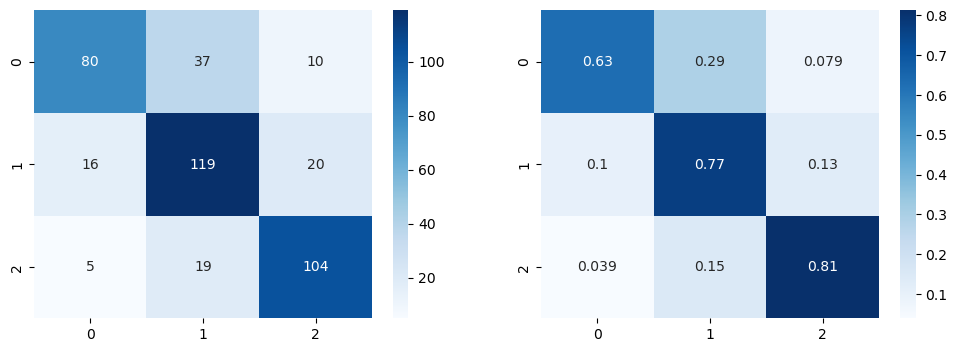

In [32]:
#X.shape(2048,789) Best trial was 32(Test-0.3)
start_time = time.perf_counter()
cl_optuna = xgb.XGBClassifier(
    #objective='multi:softprob',
    learning_rate =0.17331272253138102,
    max_depth=6,
    n_estimators=145,
    min_child_weight=1,
    gamma= 4.264584691053778,
    use_label_encoder=False,
    eval_metric="mlogloss")
cl_optuna.fit(X_train, y_train)
model=cl_optuna.fit(X_train, y_train)
print(confusion_matrix(y_test, cl_optuna.predict(X_test)))
print(classification_report(y_test, cl_optuna.predict(X_test)))
cm0 = confusion_matrix(y_test,cl_optuna.predict(X_test), normalize="true")
cm1 = confusion_matrix(y_test, cl_optuna.predict(X_test))

fig = plt.figure(figsize=(12,4))
plt.subplot(121)
sns.heatmap(cm1, annot=True, cmap='Blues',fmt='g')
plt.subplot(122)
sns.heatmap(cm0, annot=True, cmap='Blues')
end_time = time.perf_counter()
time_lapse = end_time - start_time
print (f"Finished in {time_lapse:.1f} sec.")
print(cl_optuna.objective)

In [85]:
import pickle

pickle.dump(model, open("fn_classifier.dat", "wb"))

In [21]:
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate, StratifiedKFold

  
def objective(trial):
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
    max_depth = trial.suggest_int('max_depth', 2, 11)
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    gamma = trial.suggest_uniform('gamma', 0.01, 5)
    subsample=trial.suggest_uniform('subsample', 0.01,1)
    clf1 = XGBClassifier(learning_rate=learning_rate,
                         max_depth=max_depth,
                         n_estimators=n_estimators,
                         min_child_weight=min_child_weight,
                         gamma=gamma,
                         use_label_encoder=False)
    for i in range(3):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=y, random_state=i)
        clf1.fit(X_train, y_train)
        y_pred = clf1.predict(X_test)
        cm = confusion_matrix(y_test, y_pred, normalize="true")
        score = cm[2,2]*0.4+(1-cm[1,2])*0.2+(1-cm[0,2])*0.4
    return score

#2.Create an Optuna Object
study = optuna.create_study(direction='maximize')
#3.Parameter search in Optuna
study.optimize(objective, n_trials=300)



[I 2022-12-11 13:16:05,036] A new study created in memory with name: no-name-3e12bb75-d52a-4159-a507-1e7d8abe6821
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:16:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:16:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:16:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:16:15,926] Trial 0 finished with value: 0.8478423684289725 and parameters: {'learning_rate': 0.137508537922008, 'max_depth': 8, 'n_estimators': 77, 'min_child_weight': 10, 'gamma': 1.9240584499280629, 'subsample': 0.025631957809423338}. Best is trial 0 with value: 0.8478423684289725.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:16:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:16:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:16:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:16:25,797] Trial 1 finished with value: 0.8323590993710044 and parameters: {'learning_rate': 0.46628728577654727, 'max_depth': 5, 'n_estimators': 75, 'min_child_weight': 3, 'gamma': 2.8087139373272305, 'subsample': 0.4211783764476431}. Best is trial 0 with value: 0.8478423684289725.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:16:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:16:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:16:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:17:05,246] Trial 2 finished with value: 0.8543644907628347 and parameters: {'learning_rate': 0.2790747430628344, 'max_depth': 10, 'n_estimators': 179, 'min_child_weight': 2, 'gamma': 1.4231645974643279, 'subsample': 0.42584527622361495}. Best is trial 2 with value: 0.8543644907628347.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:17:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:17:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:17:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:17:13,774] Trial 3 finished with value: 0.8524499877468368 and parameters: {'learning_rate': 0.4968927737119867, 'max_depth': 8, 'n_estimators': 55, 'min_child_weight': 9, 'gamma': 2.024464377453255, 'subsample': 0.0762387907096522}. Best is trial 2 with value: 0.8543644907628347.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:17:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:17:16] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:17:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:17:21,810] Trial 4 finished with value: 0.8431822969736837 and parameters: {'learning_rate': 0.6128767086265848, 'max_depth': 3, 'n_estimators': 103, 'min_child_weight': 6, 'gamma': 2.961235621172779, 'subsample': 0.7175414666257055}. Best is trial 2 with value: 0.8543644907628347.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:17:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:17:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:17:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:17:48,874] Trial 5 finished with value: 0.8527032197873539 and parameters: {'learning_rate': 0.5698702343842188, 'max_depth': 10, 'n_estimators': 167, 'min_child_weight': 10, 'gamma': 4.30808955173351, 'subsample': 0.030895085086698554}. Best is trial 2 with value: 0.8543644907628347.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:17:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:17:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:18:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:18:10,523] Trial 6 finished with value: 0.8252419462322598 and parameters: {'learning_rate': 0.6903142043880579, 'max_depth': 6, 'n_estimators': 176, 'min_child_weight': 6, 'gamma': 2.459908637191762, 'subsample': 0.470888249741723}. Best is trial 2 with value: 0.8543644907628347.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:18:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:18:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:18:16] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:18:18,878] Trial 7 finished with value: 0.8394409977944306 and parameters: {'learning_rate': 0.5293625741500504, 'max_depth': 2, 'n_estimators': 150, 'min_child_weight': 9, 'gamma': 0.48391100552005106, 'subsample': 0.686593157588633}. Best is trial 2 with value: 0.8543644907628347.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:18:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:18:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:18:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:18:24,838] Trial 8 finished with value: 0.8402006939159821 and parameters: {'learning_rate': 0.46334589146235133, 'max_depth': 4, 'n_estimators': 73, 'min_child_weight': 10, 'gamma': 0.9154091565674127, 'subsample': 0.451027892702547}. Best is trial 2 with value: 0.8543644907628347.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:18:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:18:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:18:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:18:40,296] Trial 9 finished with value: 0.8488914111774646 and parameters: {'learning_rate': 0.8130255982177942, 'max_depth': 8, 'n_estimators': 70, 'min_child_weight': 1, 'gamma': 0.4123437603830425, 'subsample': 0.2761488927479739}. Best is trial 2 with value: 0.8543644907628347.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:18:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:18:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:19:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:19:27,981] Trial 10 finished with value: 0.8574338006732791 and parameters: {'learning_rate': 0.1418683178563369, 'max_depth': 11, 'n_estimators': 194, 'min_child_weight': 3, 'gamma': 4.834147732824231, 'subsample': 0.983695318633095}. Best is trial 10 with value: 0.8574338006732791.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:19:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:19:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:19:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:20:11,206] Trial 11 finished with value: 0.8525557518927913 and parameters: {'learning_rate': 0.1280839734908201, 'max_depth': 11, 'n_estimators': 198, 'min_child_weight': 3, 'gamma': 4.848747622375207, 'subsample': 0.9048381370645322}. Best is trial 10 with value: 0.8574338006732791.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:20:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:20:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:20:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:20:50,489] Trial 12 finished with value: 0.8389164764201846 and parameters: {'learning_rate': 0.28192722745359794, 'max_depth': 11, 'n_estimators': 195, 'min_child_weight': 3, 'gamma': 4.080095365246638, 'subsample': 0.9820189512167041}. Best is trial 10 with value: 0.8574338006732791.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:20:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:20:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:21:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:21:16,103] Trial 13 finished with value: 0.8442132824289639 and parameters: {'learning_rate': 0.2866893471198664, 'max_depth': 9, 'n_estimators': 133, 'min_child_weight': 1, 'gamma': 1.3471082612737382, 'subsample': 0.7275900899144236}. Best is trial 10 with value: 0.8574338006732791.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:21:16] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:21:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:21:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:21:47,046] Trial 14 finished with value: 0.836765938785776 and parameters: {'learning_rate': 0.28829761802296683, 'max_depth': 10, 'n_estimators': 172, 'min_child_weight': 4, 'gamma': 3.813122954910728, 'subsample': 0.2773506898769758}. Best is trial 10 with value: 0.8574338006732791.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:21:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:21:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:22:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:22:17,652] Trial 15 finished with value: 0.8613341760070166 and parameters: {'learning_rate': 0.017840659608419795, 'max_depth': 11, 'n_estimators': 146, 'min_child_weight': 4, 'gamma': 3.3419698850141493, 'subsample': 0.5795239208260807}. Best is trial 15 with value: 0.8613341760070166.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:22:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:22:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:22:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:22:34,595] Trial 16 finished with value: 0.8611161986818177 and parameters: {'learning_rate': 0.016586998454036883, 'max_depth': 7, 'n_estimators': 113, 'min_child_weight': 4, 'gamma': 3.4553677997367807, 'subsample': 0.8753199565082636}. Best is trial 15 with value: 0.8613341760070166.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:22:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:22:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:22:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:22:49,095] Trial 17 finished with value: 0.860485913161617 and parameters: {'learning_rate': 0.033504667300153446, 'max_depth': 6, 'n_estimators': 112, 'min_child_weight': 5, 'gamma': 3.6571972791708705, 'subsample': 0.8246384256148079}. Best is trial 15 with value: 0.8613341760070166.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:22:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:22:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:23:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:23:08,118] Trial 18 finished with value: 0.8512182223884641 and parameters: {'learning_rate': 0.03899792313461074, 'max_depth': 7, 'n_estimators': 138, 'min_child_weight': 7, 'gamma': 3.294478254593845, 'subsample': 0.6039153137609107}. Best is trial 15 with value: 0.8613341760070166.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:23:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:23:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:23:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:23:19,123] Trial 19 finished with value: 0.8443895560055548 and parameters: {'learning_rate': 0.9780124793357616, 'max_depth': 5, 'n_estimators': 105, 'min_child_weight': 5, 'gamma': 3.4792474377253266, 'subsample': 0.8223836571503141}. Best is trial 15 with value: 0.8613341760070166.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:23:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:23:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:23:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:23:38,311] Trial 20 finished with value: 0.8343088571023205 and parameters: {'learning_rate': 0.3770441863512819, 'max_depth': 7, 'n_estimators': 149, 'min_child_weight': 7, 'gamma': 2.417207523470673, 'subsample': 0.583151753732476}. Best is trial 15 with value: 0.8613341760070166.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:23:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:23:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:23:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:23:53,047] Trial 21 finished with value: 0.8627069602266622 and parameters: {'learning_rate': 0.022502996748025854, 'max_depth': 6, 'n_estimators': 112, 'min_child_weight': 5, 'gamma': 3.534147956561352, 'subsample': 0.821383261591742}. Best is trial 21 with value: 0.8627069602266622.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:23:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:23:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:24:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:24:06,857] Trial 22 finished with value: 0.8456681843391676 and parameters: {'learning_rate': 0.011550466964301958, 'max_depth': 5, 'n_estimators': 117, 'min_child_weight': 4, 'gamma': 3.0978522763823717, 'subsample': 0.8410155947199774}. Best is trial 21 with value: 0.8627069602266622.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:24:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:24:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:24:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:24:14,970] Trial 23 finished with value: 0.8448788226644827 and parameters: {'learning_rate': 0.16957699949127095, 'max_depth': 4, 'n_estimators': 90, 'min_child_weight': 4, 'gamma': 4.33006523376887, 'subsample': 0.5585723222357559}. Best is trial 21 with value: 0.8627069602266622.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:24:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:24:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:24:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:24:36,783] Trial 24 finished with value: 0.8520312305185453 and parameters: {'learning_rate': 0.08759424373887556, 'max_depth': 9, 'n_estimators': 130, 'min_child_weight': 5, 'gamma': 3.817648549782972, 'subsample': 0.6507862027181466}. Best is trial 21 with value: 0.8627069602266622.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:24:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:24:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:24:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:24:49,559] Trial 25 finished with value: 0.8390574952814573 and parameters: {'learning_rate': 0.20212784006208995, 'max_depth': 7, 'n_estimators': 95, 'min_child_weight': 7, 'gamma': 3.238571372684391, 'subsample': 0.7816198387211261}. Best is trial 21 with value: 0.8627069602266622.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:24:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:24:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:25:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:25:09,528] Trial 26 finished with value: 0.860921867812015 and parameters: {'learning_rate': 0.20336734584535707, 'max_depth': 6, 'n_estimators': 147, 'min_child_weight': 2, 'gamma': 2.759001335888292, 'subsample': 0.32202126396181996}. Best is trial 21 with value: 0.8627069602266622.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:25:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:25:16] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:25:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:25:29,559] Trial 27 finished with value: 0.8528794933639448 and parameters: {'learning_rate': 0.07647006287729806, 'max_depth': 9, 'n_estimators': 120, 'min_child_weight': 6, 'gamma': 4.468708928628269, 'subsample': 0.9081893630174274}. Best is trial 21 with value: 0.8627069602266622.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:25:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:25:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:25:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:25:44,024] Trial 28 finished with value: 0.8521434436977897 and parameters: {'learning_rate': 0.3564725281697243, 'max_depth': 4, 'n_estimators': 162, 'min_child_weight': 4, 'gamma': 3.9984203550892676, 'subsample': 0.8998667847673889}. Best is trial 21 with value: 0.8627069602266622.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:25:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:25:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:25:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:25:48,323] Trial 29 finished with value: 0.788772233042267 and parameters: {'learning_rate': 0.01179367843285344, 'max_depth': 2, 'n_estimators': 89, 'min_child_weight': 5, 'gamma': 2.0794165343061484, 'subsample': 0.5254234399160329}. Best is trial 21 with value: 0.8627069602266622.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:25:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:25:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:26:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:26:12,362] Trial 30 finished with value: 0.8493209167945726 and parameters: {'learning_rate': 0.10867960790099582, 'max_depth': 8, 'n_estimators': 138, 'min_child_weight': 2, 'gamma': 3.516156754404977, 'subsample': 0.7595690008124667}. Best is trial 21 with value: 0.8627069602266622.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:26:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:26:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:26:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:26:36,153] Trial 31 finished with value: 0.8473178470547266 and parameters: {'learning_rate': 0.20293041784649157, 'max_depth': 7, 'n_estimators': 155, 'min_child_weight': 2, 'gamma': 2.7676717143246203, 'subsample': 0.27881668226381795}. Best is trial 21 with value: 0.8627069602266622.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:26:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:26:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:26:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:26:51,638] Trial 32 finished with value: 0.8462516068841281 and parameters: {'learning_rate': 0.18420825574428315, 'max_depth': 6, 'n_estimators': 123, 'min_child_weight': 4, 'gamma': 2.6375079887076462, 'subsample': 0.324441772281603}. Best is trial 21 with value: 0.8627069602266622.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:26:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:26:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:27:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:27:08,198] Trial 33 finished with value: 0.8468466376890105 and parameters: {'learning_rate': 0.08136681381947036, 'max_depth': 5, 'n_estimators': 143, 'min_child_weight': 2, 'gamma': 2.9326532330519934, 'subsample': 0.3677231875101253}. Best is trial 21 with value: 0.8627069602266622.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:27:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:27:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:27:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:27:22,627] Trial 34 finished with value: 0.8505174274376271 and parameters: {'learning_rate': 0.21969805711194235, 'max_depth': 6, 'n_estimators': 110, 'min_child_weight': 3, 'gamma': 3.359686672775839, 'subsample': 0.6344437852928337}. Best is trial 21 with value: 0.8627069602266622.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:27:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:27:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:27:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:27:31,558] Trial 35 finished with value: 0.8448435679491645 and parameters: {'learning_rate': 0.36143572984115147, 'max_depth': 3, 'n_estimators': 129, 'min_child_weight': 1, 'gamma': 2.192417437666878, 'subsample': 0.16554697782808922}. Best is trial 21 with value: 0.8627069602266622.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:27:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:27:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:27:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:27:56,967] Trial 36 finished with value: 0.8381387230054216 and parameters: {'learning_rate': 0.07450527411858376, 'max_depth': 8, 'n_estimators': 157, 'min_child_weight': 3, 'gamma': 1.7962108896851254, 'subsample': 0.15714967499763122}. Best is trial 21 with value: 0.8627069602266622.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:27:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:28:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:28:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:28:09,081] Trial 37 finished with value: 0.8493209167945726 and parameters: {'learning_rate': 0.11845432021780421, 'max_depth': 6, 'n_estimators': 98, 'min_child_weight': 6, 'gamma': 3.0727563769074675, 'subsample': 0.39236226116291606}. Best is trial 21 with value: 0.8627069602266622.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:28:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:28:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:28:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:28:28,426] Trial 38 finished with value: 0.8506231915835816 and parameters: {'learning_rate': 0.24688534479719926, 'max_depth': 5, 'n_estimators': 185, 'min_child_weight': 5, 'gamma': 2.3856826906019992, 'subsample': 0.15496216968907373}. Best is trial 21 with value: 0.8627069602266622.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:28:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:28:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:28:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:28:40,123] Trial 39 finished with value: 0.8441363239650377 and parameters: {'learning_rate': 0.1556943796379382, 'max_depth': 9, 'n_estimators': 82, 'min_child_weight': 8, 'gamma': 1.7550849875410863, 'subsample': 0.5235190037434911}. Best is trial 21 with value: 0.8627069602266622.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:28:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:28:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:28:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:28:49,264] Trial 40 finished with value: 0.8274277385819866 and parameters: {'learning_rate': 0.7283875403871939, 'max_depth': 10, 'n_estimators': 52, 'min_child_weight': 4, 'gamma': 2.751677005982734, 'subsample': 0.6795146062954387}. Best is trial 21 with value: 0.8627069602266622.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:28:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:28:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:28:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:29:03,961] Trial 41 finished with value: 0.8577403447223262 and parameters: {'learning_rate': 0.04395839723646197, 'max_depth': 6, 'n_estimators': 115, 'min_child_weight': 5, 'gamma': 3.665523104651441, 'subsample': 0.8490882872994031}. Best is trial 21 with value: 0.8627069602266622.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:29:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:29:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:29:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:29:19,834] Trial 42 finished with value: 0.8517779984780283 and parameters: {'learning_rate': 0.05281808397233758, 'max_depth': 7, 'n_estimators': 113, 'min_child_weight': 6, 'gamma': 4.0371508888287035, 'subsample': 0.7881427087845041}. Best is trial 21 with value: 0.8627069602266622.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:29:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:29:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:29:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:29:32,041] Trial 43 finished with value: 0.8550833430068834 and parameters: {'learning_rate': 0.0244243233150037, 'max_depth': 5, 'n_estimators': 107, 'min_child_weight': 5, 'gamma': 3.6461496991642264, 'subsample': 0.917645870925428}. Best is trial 21 with value: 0.8627069602266622.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:29:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:29:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:29:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:29:51,317] Trial 44 finished with value: 0.8495036394044533 and parameters: {'learning_rate': 0.12783431380214832, 'max_depth': 6, 'n_estimators': 145, 'min_child_weight': 3, 'gamma': 3.232702486670316, 'subsample': 0.9505308509568651}. Best is trial 21 with value: 0.8627069602266622.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:29:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:29:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:30:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:30:13,040] Trial 45 finished with value: 0.8468818924043287 and parameters: {'learning_rate': 0.444304926989741, 'max_depth': 8, 'n_estimators': 125, 'min_child_weight': 2, 'gamma': 4.488449143689108, 'subsample': 0.7258237065084836}. Best is trial 21 with value: 0.8627069602266622.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:30:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:30:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:30:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:30:25,710] Trial 46 finished with value: 0.8489202168594928 and parameters: {'learning_rate': 0.011090108988111533, 'max_depth': 4, 'n_estimators': 136, 'min_child_weight': 4, 'gamma': 3.755673854732868, 'subsample': 0.4649228984299842}. Best is trial 21 with value: 0.8627069602266622.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:30:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:30:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:30:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:30:45,925] Trial 47 finished with value: 0.851960721087909 and parameters: {'learning_rate': 0.1462413566237018, 'max_depth': 6, 'n_estimators': 166, 'min_child_weight': 6, 'gamma': 2.932159405732491, 'subsample': 0.8631273769862283}. Best is trial 21 with value: 0.8627069602266622.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:30:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:30:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:30:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:30:50,577] Trial 48 finished with value: 0.8345096370054129 and parameters: {'learning_rate': 0.2500692275197085, 'max_depth': 3, 'n_estimators': 67, 'min_child_weight': 5, 'gamma': 3.478817609806871, 'subsample': 0.7859878296456111}. Best is trial 21 with value: 0.8627069602266622.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:30:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:30:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:30:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:31:01,748] Trial 49 finished with value: 0.855484042941963 and parameters: {'learning_rate': 0.09882312477467176, 'max_depth': 5, 'n_estimators': 100, 'min_child_weight': 3, 'gamma': 4.166626897059683, 'subsample': 0.2108044716001397}. Best is trial 21 with value: 0.8627069602266622.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:31:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:31:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:31:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:31:19,651] Trial 50 finished with value: 0.8565855378278796 and parameters: {'learning_rate': 0.31798953559212456, 'max_depth': 7, 'n_estimators': 127, 'min_child_weight': 4, 'gamma': 2.5787510061532575, 'subsample': 0.9863187420419073}. Best is trial 21 with value: 0.8627069602266622.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:31:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:31:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:31:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:31:33,928] Trial 51 finished with value: 0.8549947762830352 and parameters: {'learning_rate': 0.061688549108444415, 'max_depth': 6, 'n_estimators': 115, 'min_child_weight': 5, 'gamma': 3.650659581870403, 'subsample': 0.8630107546215688}. Best is trial 21 with value: 0.8627069602266622.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:31:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:31:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:31:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:31:48,467] Trial 52 finished with value: 0.8504052142583827 and parameters: {'learning_rate': 0.05949419572956743, 'max_depth': 6, 'n_estimators': 118, 'min_child_weight': 6, 'gamma': 3.8984973066581428, 'subsample': 0.8411150921021908}. Best is trial 21 with value: 0.8627069602266622.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:31:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:31:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:31:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:32:03,110] Trial 53 finished with value: 0.8425455624201932 and parameters: {'learning_rate': 0.11567972691873064, 'max_depth': 7, 'n_estimators': 104, 'min_child_weight': 5, 'gamma': 3.0899808849451693, 'subsample': 0.8172160324244747}. Best is trial 21 with value: 0.8627069602266622.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:32:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:32:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:32:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:32:14,871] Trial 54 finished with value: 0.8555192976572813 and parameters: {'learning_rate': 0.04471049375587835, 'max_depth': 5, 'n_estimators': 110, 'min_child_weight': 7, 'gamma': 3.5736634521875263, 'subsample': 0.948423490467074}. Best is trial 21 with value: 0.8627069602266622.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:32:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:32:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:32:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:32:31,526] Trial 55 finished with value: 0.8517779984780283 and parameters: {'learning_rate': 0.16280189985725174, 'max_depth': 10, 'n_estimators': 93, 'min_child_weight': 4, 'gamma': 3.3789443042195666, 'subsample': 0.7067715391667921}. Best is trial 21 with value: 0.8627069602266622.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:32:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:32:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:32:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:32:58,291] Trial 56 finished with value: 0.8499159475994549 and parameters: {'learning_rate': 0.04451737369612771, 'max_depth': 11, 'n_estimators': 142, 'min_child_weight': 5, 'gamma': 4.234368369312593, 'subsample': 0.06827172915615831}. Best is trial 21 with value: 0.8627069602266622.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:32:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:33:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:33:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:33:09,687] Trial 57 finished with value: 0.8171995717841896 and parameters: {'learning_rate': 0.6245664540933518, 'max_depth': 6, 'n_estimators': 82, 'min_child_weight': 1, 'gamma': 4.6595349214089, 'subsample': 0.8702514270012882}. Best is trial 21 with value: 0.8627069602266622.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:33:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:33:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:33:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:33:31,128] Trial 58 finished with value: 0.8133525084589821 and parameters: {'learning_rate': 0.9566865117938861, 'max_depth': 7, 'n_estimators': 152, 'min_child_weight': 4, 'gamma': 3.161704808834619, 'subsample': 0.9357529021979589}. Best is trial 21 with value: 0.8627069602266622.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:33:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:33:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:33:42] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:33:47,572] Trial 59 finished with value: 0.8521017399491817 and parameters: {'learning_rate': 0.08659491895757186, 'max_depth': 8, 'n_estimators': 114, 'min_child_weight': 8, 'gamma': 3.870456830878596, 'subsample': 0.743363804555824}. Best is trial 21 with value: 0.8627069602266622.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:33:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:33:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:33:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:33:58,300] Trial 60 finished with value: 0.8427282850300741 and parameters: {'learning_rate': 0.235421421721365, 'max_depth': 4, 'n_estimators': 120, 'min_child_weight': 2, 'gamma': 2.902252257774064, 'subsample': 0.6439829040152406}. Best is trial 21 with value: 0.8627069602266622.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:33:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:34:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:34:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:34:35,796] Trial 61 finished with value: 0.8446255906239655 and parameters: {'learning_rate': 0.14521318516383086, 'max_depth': 11, 'n_estimators': 189, 'min_child_weight': 3, 'gamma': 4.41603587599748, 'subsample': 0.9654805516517325}. Best is trial 21 with value: 0.8627069602266622.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:34:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:34:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:34:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:35:09,257] Trial 62 finished with value: 0.8585533528524074 and parameters: {'learning_rate': 0.034269260248512665, 'max_depth': 10, 'n_estimators': 172, 'min_child_weight': 3, 'gamma': 4.990266679555172, 'subsample': 0.9019416900922759}. Best is trial 21 with value: 0.8627069602266622.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:35:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:35:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:35:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:35:42,143] Trial 63 finished with value: 0.8577755994376444 and parameters: {'learning_rate': 0.03382747052418536, 'max_depth': 10, 'n_estimators': 176, 'min_child_weight': 4, 'gamma': 4.747485798796246, 'subsample': 0.8091862182830873}. Best is trial 21 with value: 0.8627069602266622.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:35:42] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:35:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:36:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:36:16,507] Trial 64 finished with value: 0.8561143284621635 and parameters: {'learning_rate': 0.015195941089168021, 'max_depth': 10, 'n_estimators': 175, 'min_child_weight': 3, 'gamma': 4.702053559013839, 'subsample': 0.8905652527198916}. Best is trial 21 with value: 0.8627069602266622.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:36:16] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:36:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:36:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:36:51,863] Trial 65 finished with value: 0.8468818924043287 and parameters: {'learning_rate': 0.11044650906173388, 'max_depth': 11, 'n_estimators': 181, 'min_child_weight': 4, 'gamma': 4.996865931112537, 'subsample': 0.8136867521540275}. Best is trial 21 with value: 0.8627069602266622.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:36:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:37:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:37:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:37:25,189] Trial 66 finished with value: 0.8564028152179988 and parameters: {'learning_rate': 0.07387642539471972, 'max_depth': 10, 'n_estimators': 163, 'min_child_weight': 2, 'gamma': 4.996501278965982, 'subsample': 0.7659710743406989}. Best is trial 21 with value: 0.8627069602266622.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:37:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:37:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:37:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:38:00,320] Trial 67 finished with value: 0.838462464476575 and parameters: {'learning_rate': 0.4199538474497603, 'max_depth': 11, 'n_estimators': 200, 'min_child_weight': 4, 'gamma': 2.33647319027547, 'subsample': 0.678724990603357}. Best is trial 21 with value: 0.8627069602266622.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:38:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:38:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:38:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:38:33,287] Trial 68 finished with value: 0.8540760040069993 and parameters: {'learning_rate': 0.1887051206788402, 'max_depth': 10, 'n_estimators': 169, 'min_child_weight': 3, 'gamma': 4.7477035069531155, 'subsample': 0.41681220367252364}. Best is trial 21 with value: 0.8627069602266622.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:38:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:38:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:38:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:38:58,378] Trial 69 finished with value: 0.8637026909666241 and parameters: {'learning_rate': 0.03829511937496739, 'max_depth': 9, 'n_estimators': 148, 'min_child_weight': 3, 'gamma': 0.6618384151048373, 'subsample': 0.8073753104547853}. Best is trial 69 with value: 0.8637026909666241.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:38:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:39:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:39:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:39:20,014] Trial 70 finished with value: 0.8558077844131166 and parameters: {'learning_rate': 0.09493150445828435, 'max_depth': 9, 'n_estimators': 157, 'min_child_weight': 2, 'gamma': 0.0728258160232329, 'subsample': 0.6030775354042135}. Best is trial 69 with value: 0.8637026909666241.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:39:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:39:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:39:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:39:44,301] Trial 71 finished with value: 0.8598556276414167 and parameters: {'learning_rate': 0.033153790281285254, 'max_depth': 10, 'n_estimators': 131, 'min_child_weight': 3, 'gamma': 1.1647016523378722, 'subsample': 0.8021324333430683}. Best is trial 69 with value: 0.8637026909666241.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:39:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:39:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:40:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:40:08,544] Trial 72 finished with value: 0.8538932813971186 and parameters: {'learning_rate': 0.015884984604107467, 'max_depth': 9, 'n_estimators': 132, 'min_child_weight': 3, 'gamma': 0.8746380518782224, 'subsample': 0.8777836453326467}. Best is trial 69 with value: 0.8637026909666241.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:40:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:40:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:40:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:40:30,433] Trial 73 finished with value: 0.8214301376223705 and parameters: {'learning_rate': 0.5431518436410607, 'max_depth': 11, 'n_estimators': 145, 'min_child_weight': 3, 'gamma': 0.8570661546097891, 'subsample': 0.9113657715658696}. Best is trial 69 with value: 0.8637026909666241.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:40:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:40:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:40:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:40:56,695] Trial 74 finished with value: 0.8592605968365342 and parameters: {'learning_rate': 0.06608048722372126, 'max_depth': 9, 'n_estimators': 148, 'min_child_weight': 2, 'gamma': 1.1472880888481738, 'subsample': 0.7526809654231016}. Best is trial 69 with value: 0.8637026909666241.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:40:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:41:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:41:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:41:22,621] Trial 75 finished with value: 0.8475891363884555 and parameters: {'learning_rate': 0.06967959892356403, 'max_depth': 9, 'n_estimators': 149, 'min_child_weight': 2, 'gamma': 1.109938244099123, 'subsample': 0.7452270558016864}. Best is trial 69 with value: 0.8637026909666241.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:41:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:41:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:41:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:41:45,236] Trial 76 finished with value: 0.8470646150142094 and parameters: {'learning_rate': 0.1410781388967741, 'max_depth': 8, 'n_estimators': 135, 'min_child_weight': 1, 'gamma': 0.5927496378749435, 'subsample': 0.7055129899205066}. Best is trial 69 with value: 0.8637026909666241.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:41:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:41:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:41:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:42:06,057] Trial 77 finished with value: 0.8472825923394084 and parameters: {'learning_rate': 0.10092395976929912, 'max_depth': 7, 'n_estimators': 140, 'min_child_weight': 2, 'gamma': 1.4165368907128182, 'subsample': 0.5725429533927137}. Best is trial 69 with value: 0.8637026909666241.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:42:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:42:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:42:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:42:32,854] Trial 78 finished with value: 0.8536989505273159 and parameters: {'learning_rate': 0.17137264848320072, 'max_depth': 9, 'n_estimators': 153, 'min_child_weight': 2, 'gamma': 1.1782351300753269, 'subsample': 0.336619318397327}. Best is trial 69 with value: 0.8637026909666241.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:42:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:42:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:42:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:42:57,773] Trial 79 finished with value: 0.8463221163147645 and parameters: {'learning_rate': 0.05891637454054818, 'max_depth': 8, 'n_estimators': 149, 'min_child_weight': 1, 'gamma': 0.32819063056656184, 'subsample': 0.7962602695679144}. Best is trial 69 with value: 0.8637026909666241.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:42:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:43:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:43:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:43:16,817] Trial 80 finished with value: 0.8595843383076878 and parameters: {'learning_rate': 0.12362555623271304, 'max_depth': 9, 'n_estimators': 124, 'min_child_weight': 3, 'gamma': 0.6085737384769156, 'subsample': 0.8325715460511662}. Best is trial 69 with value: 0.8637026909666241.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:43:16] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:43:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:43:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:43:36,030] Trial 81 finished with value: 0.8440658145344013 and parameters: {'learning_rate': 0.09099505497555371, 'max_depth': 9, 'n_estimators': 123, 'min_child_weight': 3, 'gamma': 0.5522805227527836, 'subsample': 0.4970701223721897}. Best is trial 69 with value: 0.8637026909666241.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:43:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:43:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:43:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:43:58,561] Trial 82 finished with value: 0.8559905070229974 and parameters: {'learning_rate': 0.12754876221800016, 'max_depth': 9, 'n_estimators': 127, 'min_child_weight': 2, 'gamma': 1.5924333223152392, 'subsample': 0.8412908632242886}. Best is trial 69 with value: 0.8637026909666241.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:43:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:44:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:44:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:44:27,089] Trial 83 finished with value: 0.861228411861062 and parameters: {'learning_rate': 0.033688783681677305, 'max_depth': 10, 'n_estimators': 160, 'min_child_weight': 3, 'gamma': 0.29425909091606717, 'subsample': 0.7531678316212846}. Best is trial 69 with value: 0.8637026909666241.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:44:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:44:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:44:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:44:54,608] Trial 84 finished with value: 0.8561143284621635 and parameters: {'learning_rate': 0.034951730954102894, 'max_depth': 10, 'n_estimators': 160, 'min_child_weight': 4, 'gamma': 0.7259874820971709, 'subsample': 0.8232522127074638}. Best is trial 69 with value: 0.8637026909666241.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:44:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:45:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:45:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:45:16,442] Trial 85 finished with value: 0.8577755994376444 and parameters: {'learning_rate': 0.01607971675218414, 'max_depth': 10, 'n_estimators': 109, 'min_child_weight': 3, 'gamma': 0.1278150307220333, 'subsample': 0.778108424233517}. Best is trial 69 with value: 0.8637026909666241.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:45:16] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:45:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:45:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:45:40,847] Trial 86 finished with value: 0.8568920818769268 and parameters: {'learning_rate': 0.04736504030232801, 'max_depth': 11, 'n_estimators': 132, 'min_child_weight': 4, 'gamma': 0.31411341001747867, 'subsample': 0.8322606452675889}. Best is trial 69 with value: 0.8637026909666241.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:45:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:45:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:45:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:45:52,624] Trial 87 finished with value: 0.8530622159738255 and parameters: {'learning_rate': 0.21244280790685202, 'max_depth': 6, 'n_estimators': 101, 'min_child_weight': 5, 'gamma': 0.6949520906337047, 'subsample': 0.9323313680903333}. Best is trial 69 with value: 0.8637026909666241.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:45:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:45:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:46:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:46:06,950] Trial 88 finished with value: 0.8473178470547266 and parameters: {'learning_rate': 0.11852116905014898, 'max_depth': 6, 'n_estimators': 121, 'min_child_weight': 4, 'gamma': 0.23692675287217396, 'subsample': 0.22647046786406544}. Best is trial 69 with value: 0.8637026909666241.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:46:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:46:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:46:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:46:23,128] Trial 89 finished with value: 0.8521903066730299 and parameters: {'learning_rate': 0.011808219155944558, 'max_depth': 5, 'n_estimators': 138, 'min_child_weight': 3, 'gamma': 3.3429036667678176, 'subsample': 0.6718380640571243}. Best is trial 69 with value: 0.8637026909666241.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:46:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:46:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:46:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:46:43,415] Trial 90 finished with value: 0.8587360754622881 and parameters: {'learning_rate': 0.08242085790346355, 'max_depth': 10, 'n_estimators': 129, 'min_child_weight': 3, 'gamma': 0.395981114410619, 'subsample': 0.7969957000758162}. Best is trial 69 with value: 0.8637026909666241.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:46:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:46:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:47:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:47:09,387] Trial 91 finished with value: 0.8557725296977984 and parameters: {'learning_rate': 0.04959046691095695, 'max_depth': 9, 'n_estimators': 145, 'min_child_weight': 2, 'gamma': 1.0139890510948806, 'subsample': 0.8549400654074638}. Best is trial 69 with value: 0.8637026909666241.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:47:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:47:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:47:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:47:33,769] Trial 92 finished with value: 0.8530622159738255 and parameters: {'learning_rate': 0.06880696791935813, 'max_depth': 8, 'n_estimators': 155, 'min_child_weight': 3, 'gamma': 1.3054999576498942, 'subsample': 0.7509593004163265}. Best is trial 69 with value: 0.8637026909666241.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:47:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:47:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:47:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:47:53,373] Trial 93 finished with value: 0.8547234869493063 and parameters: {'learning_rate': 0.06446813420776487, 'max_depth': 7, 'n_estimators': 147, 'min_child_weight': 5, 'gamma': 0.7122345389903189, 'subsample': 0.7202845483605496}. Best is trial 69 with value: 0.8637026909666241.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:47:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:48:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:48:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:48:20,993] Trial 94 finished with value: 0.8549947762830352 and parameters: {'learning_rate': 0.03365923249485751, 'max_depth': 9, 'n_estimators': 160, 'min_child_weight': 4, 'gamma': 3.494680062371587, 'subsample': 0.7738125097880202}. Best is trial 69 with value: 0.8637026909666241.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:48:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:48:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:48:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:48:45,821] Trial 95 finished with value: 0.852738474502672 and parameters: {'learning_rate': 0.10472826218215148, 'max_depth': 11, 'n_estimators': 142, 'min_child_weight': 2, 'gamma': 0.5023719213551686, 'subsample': 0.6954766742810534}. Best is trial 69 with value: 0.8637026909666241.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:48:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:48:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:48:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:48:59,750] Trial 96 finished with value: 0.8481661099001261 and parameters: {'learning_rate': 0.12961249276482378, 'max_depth': 6, 'n_estimators': 111, 'min_child_weight': 3, 'gamma': 0.9857759399812893, 'subsample': 0.8837452594555256}. Best is trial 69 with value: 0.8637026909666241.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:48:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:49:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:49:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:49:19,202] Trial 97 finished with value: 0.8571453139174439 and parameters: {'learning_rate': 0.15196969326552123, 'max_depth': 8, 'n_estimators': 135, 'min_child_weight': 5, 'gamma': 1.5830288660668492, 'subsample': 0.732912049447927}. Best is trial 69 with value: 0.8637026909666241.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:49:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:49:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:49:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:49:45,667] Trial 98 finished with value: 0.8565150283972432 and parameters: {'learning_rate': 0.17875517822580386, 'max_depth': 10, 'n_estimators': 152, 'min_child_weight': 4, 'gamma': 1.9980352248678164, 'subsample': 0.805939960103882}. Best is trial 69 with value: 0.8637026909666241.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:49:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:49:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:49:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:49:59,994] Trial 99 finished with value: 0.8533687600228727 and parameters: {'learning_rate': 0.08222173591205337, 'max_depth': 6, 'n_estimators': 117, 'min_child_weight': 6, 'gamma': 2.6762715861560173, 'subsample': 0.7625478581486249}. Best is trial 69 with value: 0.8637026909666241.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:50:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:50:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:50:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:50:14,639] Trial 100 finished with value: 0.8201983722639976 and parameters: {'learning_rate': 0.8076552284039098, 'max_depth': 5, 'n_estimators': 124, 'min_child_weight': 1, 'gamma': 3.750450062610957, 'subsample': 0.6551104497060527}. Best is trial 69 with value: 0.8637026909666241.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:50:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:50:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:50:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:50:35,848] Trial 101 finished with value: 0.8476596458190917 and parameters: {'learning_rate': 0.08181870980530044, 'max_depth': 10, 'n_estimators': 130, 'min_child_weight': 3, 'gamma': 0.44876936156595304, 'subsample': 0.8358847501107227}. Best is trial 69 with value: 0.8637026909666241.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:50:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:50:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:50:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:50:59,101] Trial 102 finished with value: 0.8577755994376444 and parameters: {'learning_rate': 0.03989090765188997, 'max_depth': 10, 'n_estimators': 129, 'min_child_weight': 3, 'gamma': 0.355824006408069, 'subsample': 0.8034848932349069}. Best is trial 69 with value: 0.8637026909666241.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:50:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:51:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:51:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:51:18,402] Trial 103 finished with value: 0.8525204971774731 and parameters: {'learning_rate': 0.05829457298645973, 'max_depth': 10, 'n_estimators': 105, 'min_child_weight': 2, 'gamma': 0.18254621744863203, 'subsample': 0.8554022323927692}. Best is trial 69 with value: 0.8637026909666241.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:51:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:51:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:51:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:51:39,550] Trial 104 finished with value: 0.8621119294217797 and parameters: {'learning_rate': 0.03054199151509718, 'max_depth': 9, 'n_estimators': 118, 'min_child_weight': 3, 'gamma': 0.6130569275238886, 'subsample': 0.7892721322324678}. Best is trial 69 with value: 0.8637026909666241.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:51:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:51:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:51:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:51:57,655] Trial 105 finished with value: 0.8553365750474005 and parameters: {'learning_rate': 0.02863723711495538, 'max_depth': 9, 'n_estimators': 121, 'min_child_weight': 10, 'gamma': 0.8138873814647829, 'subsample': 0.7800083249384391}. Best is trial 69 with value: 0.8637026909666241.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:51:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:52:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:52:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:52:13,231] Trial 106 finished with value: 0.8623299067469787 and parameters: {'learning_rate': 0.10990637287719715, 'max_depth': 9, 'n_estimators': 112, 'min_child_weight': 4, 'gamma': 0.024761873478555962, 'subsample': 0.8785993035787364}. Best is trial 69 with value: 0.8637026909666241.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:52:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:52:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:52:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:52:31,875] Trial 107 finished with value: 0.8528794933639448 and parameters: {'learning_rate': 0.1073078619439701, 'max_depth': 9, 'n_estimators': 107, 'min_child_weight': 4, 'gamma': 3.9555066767668086, 'subsample': 0.8736400638281292}. Best is trial 69 with value: 0.8637026909666241.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:52:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:52:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:52:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:52:50,649] Trial 108 finished with value: 0.8564208725112106 and parameters: {'learning_rate': 0.02828186193890251, 'max_depth': 11, 'n_estimators': 97, 'min_child_weight': 4, 'gamma': 0.04749545935099132, 'subsample': 0.91719407664728}. Best is trial 69 with value: 0.8637026909666241.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:52:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:52:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:53:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:53:08,905] Trial 109 finished with value: 0.8591483836572897 and parameters: {'learning_rate': 0.012867155492184628, 'max_depth': 8, 'n_estimators': 112, 'min_child_weight': 5, 'gamma': 3.0278408168923328, 'subsample': 0.8825642056773088}. Best is trial 69 with value: 0.8637026909666241.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:53:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:53:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:53:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:53:21,323] Trial 110 finished with value: 0.8510591462339796 and parameters: {'learning_rate': 0.31932275474139327, 'max_depth': 7, 'n_estimators': 117, 'min_child_weight': 4, 'gamma': 0.2814739742562932, 'subsample': 0.9621509068231531}. Best is trial 69 with value: 0.8637026909666241.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:53:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:53:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:53:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:53:40,920] Trial 111 finished with value: 0.8690700064060398 and parameters: {'learning_rate': 0.0559981543187804, 'max_depth': 9, 'n_estimators': 116, 'min_child_weight': 3, 'gamma': 0.6203065635936256, 'subsample': 0.8247186585060979}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:53:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:53:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:53:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:53:59,710] Trial 112 finished with value: 0.8579583220475252 and parameters: {'learning_rate': 0.051188253912413634, 'max_depth': 9, 'n_estimators': 108, 'min_child_weight': 3, 'gamma': 0.6011996420554256, 'subsample': 0.8259841419679446}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:53:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:54:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:54:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:54:21,220] Trial 113 finished with value: 0.8615521533322155 and parameters: {'learning_rate': 0.0964888125271405, 'max_depth': 9, 'n_estimators': 119, 'min_child_weight': 3, 'gamma': 3.2028528202311866, 'subsample': 0.8562594393528772}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:54:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:54:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:54:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:54:42,035] Trial 114 finished with value: 0.8629601922671792 and parameters: {'learning_rate': 0.08563137609876681, 'max_depth': 9, 'n_estimators': 116, 'min_child_weight': 3, 'gamma': 3.278978025961071, 'subsample': 0.8573677319676227}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:54:42] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:54:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:54:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:55:01,679] Trial 115 finished with value: 0.8558430391284346 and parameters: {'learning_rate': 0.09415984796724612, 'max_depth': 9, 'n_estimators': 114, 'min_child_weight': 4, 'gamma': 3.239652497231431, 'subsample': 0.8974575115347694}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:55:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:55:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:55:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:55:21,445] Trial 116 finished with value: 0.8541817681529539 and parameters: {'learning_rate': 0.07090328629489939, 'max_depth': 8, 'n_estimators': 118, 'min_child_weight': 3, 'gamma': 3.558372976226576, 'subsample': 0.9365967443890238}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:55:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:55:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:55:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:55:38,760] Trial 117 finished with value: 0.8316518553868776 and parameters: {'learning_rate': 0.48710211295936456, 'max_depth': 9, 'n_estimators': 102, 'min_child_weight': 4, 'gamma': 3.364202947564647, 'subsample': 0.5398294980288876}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:55:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:55:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:55:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:55:56,082] Trial 118 finished with value: 0.8498454381688185 and parameters: {'learning_rate': 0.1527923598758699, 'max_depth': 8, 'n_estimators': 111, 'min_child_weight': 5, 'gamma': 3.1419996661264116, 'subsample': 0.8486633871780674}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:55:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:56:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:56:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:56:11,466] Trial 119 finished with value: 0.853657246778708 and parameters: {'learning_rate': 0.05065930399360423, 'max_depth': 6, 'n_estimators': 116, 'min_child_weight': 3, 'gamma': 3.4322762712183588, 'subsample': 0.11938538431958284}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:56:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:56:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:56:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:56:29,721] Trial 120 finished with value: 0.8545235669173191 and parameters: {'learning_rate': 0.010011921235898141, 'max_depth': 9, 'n_estimators': 105, 'min_child_weight': 5, 'gamma': 3.6471508789044385, 'subsample': 0.8651569443517928}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:56:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:56:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:56:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:56:52,710] Trial 121 finished with value: 0.8556250618032357 and parameters: {'learning_rate': 0.030461909621078198, 'max_depth': 10, 'n_estimators': 120, 'min_child_weight': 3, 'gamma': 2.869117005505967, 'subsample': 0.8108820584696409}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:56:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:57:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:57:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:57:15,371] Trial 122 finished with value: 0.8593663609824888 and parameters: {'learning_rate': 0.0986603247735918, 'max_depth': 9, 'n_estimators': 126, 'min_child_weight': 3, 'gamma': 3.2596139445632644, 'subsample': 0.7864812977676161}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:57:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:57:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:57:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:57:35,905] Trial 123 finished with value: 0.8490324300387373 and parameters: {'learning_rate': 0.04458385770236307, 'max_depth': 9, 'n_estimators': 113, 'min_child_weight': 3, 'gamma': 3.1940413586847827, 'subsample': 0.6171517899760182}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:57:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:57:42] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:57:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:57:55,461] Trial 124 finished with value: 0.8368364482164125 and parameters: {'learning_rate': 0.06666003082567112, 'max_depth': 9, 'n_estimators': 121, 'min_child_weight': 6, 'gamma': 3.724237044509542, 'subsample': 0.8897583990910063}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:57:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:58:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:58:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:58:09,489] Trial 125 finished with value: 0.8577403447223262 and parameters: {'learning_rate': 0.03146130113554844, 'max_depth': 6, 'n_estimators': 107, 'min_child_weight': 4, 'gamma': 0.1328615310068368, 'subsample': 0.8223544416950628}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:58:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:58:16] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:58:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:58:29,743] Trial 126 finished with value: 0.8535867373480716 and parameters: {'learning_rate': 0.086669330088739, 'max_depth': 10, 'n_estimators': 118, 'min_child_weight': 2, 'gamma': 0.45548805053143937, 'subsample': 0.43730278957878255}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:58:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:58:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:58:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:58:47,561] Trial 127 finished with value: 0.832813111314614 and parameters: {'learning_rate': 0.6068848524820769, 'max_depth': 5, 'n_estimators': 164, 'min_child_weight': 3, 'gamma': 3.0362301810063026, 'subsample': 0.8514605070633648}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:58:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:58:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:58:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:59:04,416] Trial 128 finished with value: 0.8500634154940174 and parameters: {'learning_rate': 0.13117334439354672, 'max_depth': 7, 'n_estimators': 115, 'min_child_weight': 3, 'gamma': 2.4888143321889973, 'subsample': 0.7684409495085198}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:59:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:59:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:59:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:59:21,767] Trial 129 finished with value: 0.8639559230071413 and parameters: {'learning_rate': 0.11243608174669054, 'max_depth': 11, 'n_estimators': 138, 'min_child_weight': 4, 'gamma': 0.031175063369134472, 'subsample': 0.4847834884851121}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:59:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:59:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:59:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 13:59:47,710] Trial 130 finished with value: 0.8433585705502746 and parameters: {'learning_rate': 0.11380744312410002, 'max_depth': 11, 'n_estimators': 140, 'min_child_weight': 4, 'gamma': 2.798604668009905, 'subsample': 0.4947081313108206}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:59:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:59:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:00:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:00:11,084] Trial 131 finished with value: 0.8593311062671707 and parameters: {'learning_rate': 0.044199904208299196, 'max_depth': 11, 'n_estimators': 134, 'min_child_weight': 4, 'gamma': 0.02190794058363562, 'subsample': 0.359247232974284}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:00:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:00:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:00:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:00:35,014] Trial 132 finished with value: 0.8500281607786994 and parameters: {'learning_rate': 0.06531837377700758, 'max_depth': 11, 'n_estimators': 144, 'min_child_weight': 4, 'gamma': 0.23596164185869745, 'subsample': 0.9157974060300221}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:00:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:00:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:00:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:01:03,585] Trial 133 finished with value: 0.8505879368682635 and parameters: {'learning_rate': 0.08256481481587327, 'max_depth': 11, 'n_estimators': 138, 'min_child_weight': 3, 'gamma': 2.211554393690828, 'subsample': 0.2964627623351408}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:01:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:01:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:01:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:01:26,064] Trial 134 finished with value: 0.8521017399491817 and parameters: {'learning_rate': 0.025304183685528447, 'max_depth': 10, 'n_estimators': 125, 'min_child_weight': 5, 'gamma': 3.4847538974870016, 'subsample': 0.3851502911515724}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:01:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:01:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:01:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:01:40,484] Trial 135 finished with value: 0.8479481325749271 and parameters: {'learning_rate': 0.05271960215237689, 'max_depth': 6, 'n_estimators': 110, 'min_child_weight': 3, 'gamma': 0.14049181101393354, 'subsample': 0.46693502701959577}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:01:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:01:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:01:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:02:07,695] Trial 136 finished with value: 0.8552127536082341 and parameters: {'learning_rate': 0.16388386267978663, 'max_depth': 9, 'n_estimators': 158, 'min_child_weight': 4, 'gamma': 3.566146555756157, 'subsample': 0.24371385310585786}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:02:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:02:16] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:02:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:02:34,636] Trial 137 finished with value: 0.8421865662337216 and parameters: {'learning_rate': 0.18774152672001843, 'max_depth': 10, 'n_estimators': 132, 'min_child_weight': 2, 'gamma': 3.8386942879245294, 'subsample': 0.8028854536931976}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:02:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:02:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:02:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:03:00,404] Trial 138 finished with value: 0.8540343002583912 and parameters: {'learning_rate': 0.010400992849771942, 'max_depth': 10, 'n_estimators': 152, 'min_child_weight': 9, 'gamma': 3.3467730897074395, 'subsample': 0.8680346589079914}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:03:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:03:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:03:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:03:18,952] Trial 139 finished with value: 0.8565502831125615 and parameters: {'learning_rate': 0.10614109342450584, 'max_depth': 9, 'n_estimators': 122, 'min_child_weight': 3, 'gamma': 0.4241274708482994, 'subsample': 0.7329885518990055}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:03:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:03:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:03:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:03:26,123] Trial 140 finished with value: 0.8397827965587958 and parameters: {'learning_rate': 0.13713686576590628, 'max_depth': 2, 'n_estimators': 141, 'min_child_weight': 4, 'gamma': 0.7222035903180842, 'subsample': 0.8427583258364355}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:03:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:03:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:03:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:03:45,907] Trial 141 finished with value: 0.8519254663725908 and parameters: {'learning_rate': 0.1191230822165129, 'max_depth': 9, 'n_estimators': 125, 'min_child_weight': 3, 'gamma': 0.5881336004451773, 'subsample': 0.8282913602905592}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:03:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:03:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:03:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:04:06,600] Trial 142 finished with value: 0.8479128778596088 and parameters: {'learning_rate': 0.0770066308777986, 'max_depth': 8, 'n_estimators': 119, 'min_child_weight': 3, 'gamma': 0.9707383509502676, 'subsample': 0.8311127098851401}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:04:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:04:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:04:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:04:32,951] Trial 143 finished with value: 0.857705090007008 and parameters: {'learning_rate': 0.033485081580775476, 'max_depth': 9, 'n_estimators': 147, 'min_child_weight': 3, 'gamma': 0.7871379665303879, 'subsample': 0.7971609309058542}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:04:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:04:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:04:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:04:45,306] Trial 144 finished with value: 0.8628544281212247 and parameters: {'learning_rate': 0.05651297861552895, 'max_depth': 9, 'n_estimators': 63, 'min_child_weight': 2, 'gamma': 0.2453942272482652, 'subsample': 0.8933315486658574}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:04:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:04:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:04:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:04:53,837] Trial 145 finished with value: 0.8566560472585161 and parameters: {'learning_rate': 0.061608541505320066, 'max_depth': 6, 'n_estimators': 62, 'min_child_weight': 2, 'gamma': 0.24820119817548658, 'subsample': 0.9002551065560688}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:04:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:04:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:05:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:05:05,834] Trial 146 finished with value: 0.8547062895272 and parameters: {'learning_rate': 0.08859451252674408, 'max_depth': 11, 'n_estimators': 61, 'min_child_weight': 2, 'gamma': 0.3540657735272425, 'subsample': 0.8651362444294084}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:05:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:05:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:05:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:05:18,284] Trial 147 finished with value: 0.8610456892511813 and parameters: {'learning_rate': 0.04629557975257891, 'max_depth': 9, 'n_estimators': 74, 'min_child_weight': 5, 'gamma': 0.12976540883423107, 'subsample': 0.934863055509812}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:05:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:05:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:05:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:05:31,388] Trial 148 finished with value: 0.8561143284621635 and parameters: {'learning_rate': 0.051399303334356654, 'max_depth': 9, 'n_estimators': 79, 'min_child_weight': 5, 'gamma': 0.023894421487075865, 'subsample': 0.9318364477809369}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:05:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:05:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:05:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:05:41,511] Trial 149 finished with value: 0.85174274376271 and parameters: {'learning_rate': 0.0989223270606795, 'max_depth': 8, 'n_estimators': 68, 'min_child_weight': 5, 'gamma': 0.22521240350022123, 'subsample': 0.9183066561986648}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:05:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:05:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:05:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:05:56,950] Trial 150 finished with value: 0.8507117583074297 and parameters: {'learning_rate': 0.0120893688759236, 'max_depth': 9, 'n_estimators': 88, 'min_child_weight': 5, 'gamma': 0.1336719961656362, 'subsample': 0.9573534835116502}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:05:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:06:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:06:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:06:06,318] Trial 151 finished with value: 0.8618586973812626 and parameters: {'learning_rate': 0.04253441587328998, 'max_depth': 9, 'n_estimators': 54, 'min_child_weight': 5, 'gamma': 0.3156476235490347, 'subsample': 0.8950446676883048}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:06:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:06:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:06:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:06:15,345] Trial 152 finished with value: 0.8544178027713647 and parameters: {'learning_rate': 0.07176461294402837, 'max_depth': 9, 'n_estimators': 54, 'min_child_weight': 5, 'gamma': 0.013671159405934719, 'subsample': 0.9924769149703231}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:06:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:06:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:06:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:06:27,682] Trial 153 finished with value: 0.8529328053724747 and parameters: {'learning_rate': 0.03837375451844305, 'max_depth': 9, 'n_estimators': 73, 'min_child_weight': 5, 'gamma': 0.500523781465195, 'subsample': 0.9768127389333653}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:06:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:06:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:06:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:06:34,602] Trial 154 finished with value: 0.8394409977944306 and parameters: {'learning_rate': 0.39960951030510616, 'max_depth': 9, 'n_estimators': 59, 'min_child_weight': 5, 'gamma': 0.3616294100174746, 'subsample': 0.8829597913254805}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:06:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:06:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:06:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:06:43,148] Trial 155 finished with value: 0.845562420193213 and parameters: {'learning_rate': 0.027693388536386254, 'max_depth': 9, 'n_estimators': 51, 'min_child_weight': 6, 'gamma': 0.13119175530153945, 'subsample': 0.9035648098101067}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:06:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:06:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:06:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:06:53,522] Trial 156 finished with value: 0.8555898070879175 and parameters: {'learning_rate': 0.05596392100727826, 'max_depth': 8, 'n_estimators': 64, 'min_child_weight': 4, 'gamma': 0.28072500819009544, 'subsample': 0.9376758863350813}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:06:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:06:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:06:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:07:02,587] Trial 157 finished with value: 0.8498454381688185 and parameters: {'learning_rate': 0.07488170480032458, 'max_depth': 6, 'n_estimators': 73, 'min_child_weight': 6, 'gamma': 3.4145281237694807, 'subsample': 0.8534440307380227}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:07:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:07:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:07:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:07:12,131] Trial 158 finished with value: 0.8588951516167727 and parameters: {'learning_rate': 0.048482391441367415, 'max_depth': 9, 'n_estimators': 55, 'min_child_weight': 5, 'gamma': 4.104896604576423, 'subsample': 0.8823443143343207}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:07:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:07:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:07:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:07:38,530] Trial 159 finished with value: 0.8490676847540555 and parameters: {'learning_rate': 0.09886066637991223, 'max_depth': 9, 'n_estimators': 155, 'min_child_weight': 4, 'gamma': 3.269510720565096, 'subsample': 0.5462133307710826}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:07:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:07:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:07:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:07:46,976] Trial 160 finished with value: 0.8410317593392751 and parameters: {'learning_rate': 0.7071393217676012, 'max_depth': 8, 'n_estimators': 56, 'min_child_weight': 5, 'gamma': 3.663077048512689, 'subsample': 0.41581258809542443}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:07:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:07:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:08:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:08:09,594] Trial 161 finished with value: 0.8552308109014459 and parameters: {'learning_rate': 0.02691593223964847, 'max_depth': 10, 'n_estimators': 113, 'min_child_weight': 2, 'gamma': 0.4365492123602629, 'subsample': 0.8137249404952734}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:08:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:08:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:08:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:08:41,278] Trial 162 finished with value: 0.8535867373480716 and parameters: {'learning_rate': 0.04077238777157765, 'max_depth': 9, 'n_estimators': 168, 'min_child_weight': 1, 'gamma': 0.6289377184332259, 'subsample': 0.5854268897464548}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:08:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:08:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:08:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:08:53,268] Trial 163 finished with value: 0.8553013203320823 and parameters: {'learning_rate': 0.06507231027373142, 'max_depth': 10, 'n_estimators': 65, 'min_child_weight': 3, 'gamma': 0.20217979627002763, 'subsample': 0.7808767898768015}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:08:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:08:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:08:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:09:03,006] Trial 164 finished with value: 0.8310568245819951 and parameters: {'learning_rate': 0.012077505813696363, 'max_depth': 9, 'n_estimators': 50, 'min_child_weight': 3, 'gamma': 0.30748406686721785, 'subsample': 0.866116113177122}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:09:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:09:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:09:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:09:29,878] Trial 165 finished with value: 0.8520312305185453 and parameters: {'learning_rate': 0.0409676778224181, 'max_depth': 11, 'n_estimators': 137, 'min_child_weight': 4, 'gamma': 3.0148264665846565, 'subsample': 0.8418797130641718}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:09:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:09:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:09:42] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:09:48,800] Trial 166 finished with value: 0.8601441143972519 and parameters: {'learning_rate': 0.08766197791994951, 'max_depth': 10, 'n_estimators': 116, 'min_child_weight': 3, 'gamma': 0.5158235370249902, 'subsample': 0.7603408874138606}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:09:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:09:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:09:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:09:56,687] Trial 167 finished with value: 0.8549947762830352 and parameters: {'learning_rate': 0.11654044271830022, 'max_depth': 6, 'n_estimators': 58, 'min_child_weight': 2, 'gamma': 3.125140315861481, 'subsample': 0.7633809952412907}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:09:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:10:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:10:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:10:14,260] Trial 168 finished with value: 0.8579935767628433 and parameters: {'learning_rate': 0.09085062027924097, 'max_depth': 9, 'n_estimators': 116, 'min_child_weight': 4, 'gamma': 0.5001024968345331, 'subsample': 0.9191464263945243}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:10:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:10:16] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:10:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:10:21,800] Trial 169 finished with value: 0.8407785272987579 and parameters: {'learning_rate': 0.14261298736245293, 'max_depth': 3, 'n_estimators': 108, 'min_child_weight': 4, 'gamma': 0.13441779985266233, 'subsample': 0.0348138262624309}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:10:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:10:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:10:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:10:40,235] Trial 170 finished with value: 0.8601441143972519 and parameters: {'learning_rate': 0.07504073425787987, 'max_depth': 9, 'n_estimators': 115, 'min_child_weight': 3, 'gamma': 0.3791536959215452, 'subsample': 0.8934129617574451}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:10:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:10:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:10:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:10:58,552] Trial 171 finished with value: 0.8593311062671707 and parameters: {'learning_rate': 0.07161980893293185, 'max_depth': 9, 'n_estimators': 113, 'min_child_weight': 3, 'gamma': 0.3972720407893788, 'subsample': 0.9016989466730434}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:10:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:11:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:11:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:11:11,989] Trial 172 finished with value: 0.8179420704836345 and parameters: {'learning_rate': 0.918719447718894, 'max_depth': 9, 'n_estimators': 111, 'min_child_weight': 3, 'gamma': 0.534942921622547, 'subsample': 0.8798286931397108}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:11:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:11:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:11:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:11:31,707] Trial 173 finished with value: 0.8598908823567348 and parameters: {'learning_rate': 0.053129290718207586, 'max_depth': 9, 'n_estimators': 116, 'min_child_weight': 3, 'gamma': 0.6566172107202225, 'subsample': 0.9424442890094554}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:11:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:11:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:11:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:11:50,819] Trial 174 finished with value: 0.8650754751862696 and parameters: {'learning_rate': 0.08530014373128396, 'max_depth': 9, 'n_estimators': 120, 'min_child_weight': 2, 'gamma': 0.21662887559489866, 'subsample': 0.8217935417756126}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:11:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:11:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:12:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:12:08,978] Trial 175 finished with value: 0.854959521567717 and parameters: {'learning_rate': 0.11030358216315153, 'max_depth': 9, 'n_estimators': 120, 'min_child_weight': 2, 'gamma': 0.21989332512270132, 'subsample': 0.850614606441974}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:12:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:12:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:12:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:12:28,818] Trial 176 finished with value: 0.8528089839333084 and parameters: {'learning_rate': 0.028093128485071117, 'max_depth': 9, 'n_estimators': 104, 'min_child_weight': 2, 'gamma': 3.571096761120147, 'subsample': 0.8202418039047228}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:12:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:12:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:12:42] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:12:49,494] Trial 177 finished with value: 0.857398545957961 and parameters: {'learning_rate': 0.06442965334068142, 'max_depth': 9, 'n_estimators': 122, 'min_child_weight': 2, 'gamma': 0.31714174576968024, 'subsample': 0.8901046715721591}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:12:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:12:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:12:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:13:03,559] Trial 178 finished with value: 0.861175099852532 and parameters: {'learning_rate': 0.08580174525585485, 'max_depth': 8, 'n_estimators': 99, 'min_child_weight': 5, 'gamma': 0.06498430498452071, 'subsample': 0.8321353074123659}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:13:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:13:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:13:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:13:15,982] Trial 179 finished with value: 0.8566207925431978 and parameters: {'learning_rate': 0.04946280171992577, 'max_depth': 7, 'n_estimators': 86, 'min_child_weight': 5, 'gamma': 0.04035405920302168, 'subsample': 0.7882331612146921}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:13:16] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:13:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:13:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:13:31,727] Trial 180 finished with value: 0.8531860374129918 and parameters: {'learning_rate': 0.011025202831180013, 'max_depth': 8, 'n_estimators': 94, 'min_child_weight': 5, 'gamma': 0.12310723668223333, 'subsample': 0.8305048488246308}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:13:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:13:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:13:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:13:48,833] Trial 181 finished with value: 0.8519959758032271 and parameters: {'learning_rate': 0.08970947616428977, 'max_depth': 8, 'n_estimators': 110, 'min_child_weight': 5, 'gamma': 3.4638028438954835, 'subsample': 0.7992524549142171}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:13:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:13:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:13:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:14:02,190] Trial 182 finished with value: 0.8574338006732791 and parameters: {'learning_rate': 0.12572106974196845, 'max_depth': 6, 'n_estimators': 118, 'min_child_weight': 5, 'gamma': 0.23014795993092482, 'subsample': 0.8602088213741261}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:14:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:14:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:14:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:14:21,585] Trial 183 finished with value: 0.8533335053075545 and parameters: {'learning_rate': 0.08464027521282533, 'max_depth': 10, 'n_estimators': 150, 'min_child_weight': 6, 'gamma': 0.012141227312443534, 'subsample': 0.7560041043142572}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:14:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:14:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:14:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:14:35,338] Trial 184 finished with value: 0.8525557518927913 and parameters: {'learning_rate': 0.03128880823262027, 'max_depth': 6, 'n_estimators': 99, 'min_child_weight': 2, 'gamma': 2.6305112986081456, 'subsample': 0.8153640284122036}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:14:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:14:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:14:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:14:48,091] Trial 185 finished with value: 0.8525910066081095 and parameters: {'learning_rate': 0.06875933057566082, 'max_depth': 9, 'n_estimators': 76, 'min_child_weight': 5, 'gamma': 0.17962500933376913, 'subsample': 0.8699178861891976}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:14:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:14:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:15:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:15:06,794] Trial 186 finished with value: 0.854959521567717 and parameters: {'learning_rate': 0.05421848266573787, 'max_depth': 9, 'n_estimators': 113, 'min_child_weight': 4, 'gamma': 0.3270503181610427, 'subsample': 0.516168176150328}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:15:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:15:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:15:16] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:15:21,236] Trial 187 finished with value: 0.8525376945995795 and parameters: {'learning_rate': 0.10911702118416172, 'max_depth': 7, 'n_estimators': 107, 'min_child_weight': 3, 'gamma': 0.37173139566433977, 'subsample': 0.9123477428512946}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:15:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:15:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:15:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:15:46,546] Trial 188 finished with value: 0.8539285361124368 and parameters: {'learning_rate': 0.02717618761664848, 'max_depth': 9, 'n_estimators': 128, 'min_child_weight': 1, 'gamma': 3.297009362317593, 'subsample': 0.8412912996095162}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:15:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:15:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:15:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:15:54,379] Trial 189 finished with value: 0.8557372749824801 and parameters: {'learning_rate': 0.2648197593473888, 'max_depth': 8, 'n_estimators': 70, 'min_child_weight': 5, 'gamma': 0.1828089017657058, 'subsample': 0.8962828246462128}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:15:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:16:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:16:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:16:12,929] Trial 190 finished with value: 0.8511477129578277 and parameters: {'learning_rate': 0.08368814355924996, 'max_depth': 11, 'n_estimators': 118, 'min_child_weight': 4, 'gamma': 0.5165888579125397, 'subsample': 0.7154947518304502}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:16:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:16:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:16:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:16:30,820] Trial 191 finished with value: 0.8563323057873625 and parameters: {'learning_rate': 0.07818138994070836, 'max_depth': 9, 'n_estimators': 115, 'min_child_weight': 3, 'gamma': 0.10975456850842852, 'subsample': 0.18905136052055005}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:16:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:16:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:16:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:16:51,507] Trial 192 finished with value: 0.8615168986168974 and parameters: {'learning_rate': 0.05203419754832982, 'max_depth': 9, 'n_estimators': 124, 'min_child_weight': 3, 'gamma': 0.47066251526610203, 'subsample': 0.8452434926530559}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:16:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:16:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:17:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:17:14,421] Trial 193 finished with value: 0.8563675605026807 and parameters: {'learning_rate': 0.04518359035889348, 'max_depth': 9, 'n_estimators': 124, 'min_child_weight': 3, 'gamma': 3.7684504975961284, 'subsample': 0.8169957376806356}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:17:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:17:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:17:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:17:34,341] Trial 194 finished with value: 0.8495216966976651 and parameters: {'learning_rate': 0.05938449598194204, 'max_depth': 9, 'n_estimators': 122, 'min_child_weight': 3, 'gamma': 0.4141889174050627, 'subsample': 0.8440443402453308}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:17:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:17:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:17:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:17:56,158] Trial 195 finished with value: 0.8572158233480802 and parameters: {'learning_rate': 0.035937933989972984, 'max_depth': 9, 'n_estimators': 120, 'min_child_weight': 2, 'gamma': 0.30304068129248807, 'subsample': 0.8619210395033281}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:17:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:18:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:18:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:18:11,531] Trial 196 finished with value: 0.84620990313552 and parameters: {'learning_rate': 0.010559532912932396, 'max_depth': 6, 'n_estimators': 111, 'min_child_weight': 3, 'gamma': 0.5477803516773982, 'subsample': 0.7850674923558472}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:18:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:18:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:18:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:18:32,127] Trial 197 finished with value: 0.8593663609824888 and parameters: {'learning_rate': 0.10150581204534101, 'max_depth': 9, 'n_estimators': 114, 'min_child_weight': 3, 'gamma': 3.4259703023021286, 'subsample': 0.8812160972832264}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:18:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:18:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:18:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:18:51,126] Trial 198 finished with value: 0.8519959758032271 and parameters: {'learning_rate': 0.12957721472786216, 'max_depth': 10, 'n_estimators': 125, 'min_child_weight': 4, 'gamma': 0.7464093437726269, 'subsample': 0.7412069880507106}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:18:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:18:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:18:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:19:04,501] Trial 199 finished with value: 0.8490324300387373 and parameters: {'learning_rate': 0.061421142217335065, 'max_depth': 9, 'n_estimators': 81, 'min_child_weight': 5, 'gamma': 0.21156515730727832, 'subsample': 0.8470102901237071}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:19:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:19:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:19:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:19:26,282] Trial 200 finished with value: 0.8541817681529539 and parameters: {'learning_rate': 0.09686909318910245, 'max_depth': 8, 'n_estimators': 146, 'min_child_weight': 2, 'gamma': 0.08905610188553367, 'subsample': 0.7996662841623949}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:19:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:19:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:19:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:19:48,170] Trial 201 finished with value: 0.8557725296977984 and parameters: {'learning_rate': 0.07496927106273381, 'max_depth': 9, 'n_estimators': 117, 'min_child_weight': 3, 'gamma': 0.6498226168211263, 'subsample': 0.8254749697819899}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:19:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:19:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:20:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:20:10,201] Trial 202 finished with value: 0.8648222431457525 and parameters: {'learning_rate': 0.035906599261688835, 'max_depth': 9, 'n_estimators': 115, 'min_child_weight': 3, 'gamma': 0.44585668726216793, 'subsample': 0.32695076226121395}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:20:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:20:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:20:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:20:33,017] Trial 203 finished with value: 0.8555545523725994 and parameters: {'learning_rate': 0.030332837027621736, 'max_depth': 9, 'n_estimators': 119, 'min_child_weight': 3, 'gamma': 3.6094208411543516, 'subsample': 0.24834437375877577}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:20:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:20:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:20:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:20:55,059] Trial 204 finished with value: 0.8607038904868161 and parameters: {'learning_rate': 0.05156048120508104, 'max_depth': 10, 'n_estimators': 109, 'min_child_weight': 3, 'gamma': 0.4642697743277888, 'subsample': 0.3529038644136324}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:20:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:21:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:21:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:21:13,654] Trial 205 finished with value: 0.8628544281212247 and parameters: {'learning_rate': 0.04543277214572819, 'max_depth': 9, 'n_estimators': 105, 'min_child_weight': 3, 'gamma': 0.4524906901903133, 'subsample': 0.4086817122045947}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:21:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:21:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:21:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:21:33,118] Trial 206 finished with value: 0.8590426195113353 and parameters: {'learning_rate': 0.04542700760895288, 'max_depth': 9, 'n_estimators': 108, 'min_child_weight': 3, 'gamma': 0.46804205775367824, 'subsample': 0.31663248273707034}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:21:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:21:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:21:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:21:52,448] Trial 207 finished with value: 0.8631257174549536 and parameters: {'learning_rate': 0.025633616559380117, 'max_depth': 9, 'n_estimators': 104, 'min_child_weight': 3, 'gamma': 0.27941722396503466, 'subsample': 0.3066914551284734}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:21:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:21:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:22:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:22:14,875] Trial 208 finished with value: 0.8603801490156626 and parameters: {'learning_rate': 0.023648881616902546, 'max_depth': 9, 'n_estimators': 103, 'min_child_weight': 3, 'gamma': 0.25797337768897227, 'subsample': 0.29422958822332695}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:22:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:22:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:22:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:22:34,446] Trial 209 finished with value: 0.860450658446299 and parameters: {'learning_rate': 0.027367909938364493, 'max_depth': 9, 'n_estimators': 100, 'min_child_weight': 3, 'gamma': 0.13345256722305743, 'subsample': 0.3843547653457887}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:22:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:22:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:22:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:22:54,255] Trial 210 finished with value: 0.8535867373480716 and parameters: {'learning_rate': 0.3174444918605319, 'max_depth': 9, 'n_estimators': 153, 'min_child_weight': 3, 'gamma': 0.30264711115754717, 'subsample': 0.3166868799159579}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:22:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:23:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:23:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:23:12,643] Trial 211 finished with value: 0.8555192976572813 and parameters: {'learning_rate': 0.05139502717875209, 'max_depth': 9, 'n_estimators': 107, 'min_child_weight': 3, 'gamma': 0.39820304514411287, 'subsample': 0.3589842161643936}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:23:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:23:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:23:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:23:32,241] Trial 212 finished with value: 0.8563675605026807 and parameters: {'learning_rate': 0.04348837645110623, 'max_depth': 9, 'n_estimators': 105, 'min_child_weight': 3, 'gamma': 0.622821230128389, 'subsample': 0.3434346738384356}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:23:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:23:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:23:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:23:52,619] Trial 213 finished with value: 0.8644804443813874 and parameters: {'learning_rate': 0.06057760127596673, 'max_depth': 9, 'n_estimators': 112, 'min_child_weight': 3, 'gamma': 0.8711542421204039, 'subsample': 0.3304806527155941}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:23:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:24:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:24:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:24:15,561] Trial 214 finished with value: 0.8560790737468454 and parameters: {'learning_rate': 0.010156071817526466, 'max_depth': 9, 'n_estimators': 112, 'min_child_weight': 2, 'gamma': 0.821169523589121, 'subsample': 0.309210693365163}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:24:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:24:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:24:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:24:33,128] Trial 215 finished with value: 0.8644804443813874 and parameters: {'learning_rate': 0.06469158828542304, 'max_depth': 9, 'n_estimators': 103, 'min_child_weight': 3, 'gamma': 0.26083188881664154, 'subsample': 0.26669650922820504}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:24:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:24:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:24:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:24:50,453] Trial 216 finished with value: 0.8535867373480716 and parameters: {'learning_rate': 0.06387512098977947, 'max_depth': 9, 'n_estimators': 101, 'min_child_weight': 3, 'gamma': 0.02571396509350688, 'subsample': 0.26916852797684626}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:24:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:24:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:25:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:25:07,889] Trial 217 finished with value: 0.8658532286010328 and parameters: {'learning_rate': 0.03658790496492598, 'max_depth': 9, 'n_estimators': 98, 'min_child_weight': 3, 'gamma': 0.335297666373354, 'subsample': 0.27552988597064376}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:25:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:25:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:25:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:25:24,414] Trial 218 finished with value: 0.8677505341949242 and parameters: {'learning_rate': 0.02864360650879056, 'max_depth': 9, 'n_estimators': 91, 'min_child_weight': 3, 'gamma': 0.5762744168459668, 'subsample': 0.27896982141306104}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:25:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:25:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:25:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:25:41,726] Trial 219 finished with value: 0.8658532286010328 and parameters: {'learning_rate': 0.03030145629199602, 'max_depth': 9, 'n_estimators': 96, 'min_child_weight': 3, 'gamma': 0.7273789787680138, 'subsample': 0.27314382587808034}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:25:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:25:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:25:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:25:58,535] Trial 220 finished with value: 0.8634142042107888 and parameters: {'learning_rate': 0.03156877450268442, 'max_depth': 9, 'n_estimators': 92, 'min_child_weight': 3, 'gamma': 0.6988159784868806, 'subsample': 0.2818127980536851}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:25:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:26:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:26:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:26:16,163] Trial 221 finished with value: 0.8661597726500798 and parameters: {'learning_rate': 0.026289466191796746, 'max_depth': 9, 'n_estimators': 96, 'min_child_weight': 3, 'gamma': 0.6985817912714295, 'subsample': 0.27594141497933056}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:26:16] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:26:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:26:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:26:33,238] Trial 222 finished with value: 0.8595671408855813 and parameters: {'learning_rate': 0.029585744151099047, 'max_depth': 9, 'n_estimators': 94, 'min_child_weight': 3, 'gamma': 0.7526286713704821, 'subsample': 0.26327747369960264}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:26:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:26:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:26:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:26:50,478] Trial 223 finished with value: 0.8524147330315186 and parameters: {'learning_rate': 0.01215415116837667, 'max_depth': 9, 'n_estimators': 91, 'min_child_weight': 3, 'gamma': 0.9024816636390334, 'subsample': 0.2883973928092543}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:26:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:26:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:27:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:27:07,595] Trial 224 finished with value: 0.8625659413653893 and parameters: {'learning_rate': 0.039188856315216056, 'max_depth': 9, 'n_estimators': 95, 'min_child_weight': 3, 'gamma': 0.6697605126225838, 'subsample': 0.27483469747943956}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:27:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:27:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:27:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:27:24,308] Trial 225 finished with value: 0.8495569514129832 and parameters: {'learning_rate': 0.06333211921396054, 'max_depth': 9, 'n_estimators': 96, 'min_child_weight': 3, 'gamma': 0.7189478444862409, 'subsample': 0.26163190493987937}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:27:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:27:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:27:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:27:40,609] Trial 226 finished with value: 0.8525204971774731 and parameters: {'learning_rate': 0.044006699924473126, 'max_depth': 9, 'n_estimators': 92, 'min_child_weight': 3, 'gamma': 0.8522145486964218, 'subsample': 0.24043796192298586}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:27:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:27:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:27:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:27:57,569] Trial 227 finished with value: 0.8664482594059152 and parameters: {'learning_rate': 0.030492123838021933, 'max_depth': 9, 'n_estimators': 94, 'min_child_weight': 3, 'gamma': 0.6585302634153728, 'subsample': 0.2764750611798112}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:27:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:28:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:28:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:28:13,606] Trial 228 finished with value: 0.8647517337151162 and parameters: {'learning_rate': 0.026770372650578713, 'max_depth': 9, 'n_estimators': 86, 'min_child_weight': 3, 'gamma': 0.6218173605328376, 'subsample': 0.28021171675567674}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:28:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:28:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:28:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:28:29,705] Trial 229 finished with value: 0.8574518579664909 and parameters: {'learning_rate': 0.026731486497075692, 'max_depth': 9, 'n_estimators': 87, 'min_child_weight': 3, 'gamma': 0.6564761120680921, 'subsample': 0.28136302067496294}. Best is trial 111 with value: 0.8690700064060398.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:28:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:28:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:28:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:28:47,358] Trial 230 finished with value: 0.878154974569312 and parameters: {'learning_rate': 0.031027615606594512, 'max_depth': 9, 'n_estimators': 97, 'min_child_weight': 3, 'gamma': 0.5786856661469191, 'subsample': 0.20642323443767308}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:28:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:28:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:28:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:29:05,127] Trial 231 finished with value: 0.8560790737468454 and parameters: {'learning_rate': 0.029010365199930888, 'max_depth': 9, 'n_estimators': 97, 'min_child_weight': 3, 'gamma': 0.7863435060964032, 'subsample': 0.22693246692257965}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:29:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:29:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:29:16] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:29:22,297] Trial 232 finished with value: 0.8652229430808323 and parameters: {'learning_rate': 0.010456546233527753, 'max_depth': 9, 'n_estimators': 91, 'min_child_weight': 3, 'gamma': 0.5933883085496214, 'subsample': 0.2942771825925057}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:29:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:29:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:29:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:29:39,226] Trial 233 finished with value: 0.851960721087909 and parameters: {'learning_rate': 0.011254788470762755, 'max_depth': 9, 'n_estimators': 90, 'min_child_weight': 3, 'gamma': 0.6320277315625205, 'subsample': 0.29904811359203004}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:29:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:29:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:29:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:29:56,253] Trial 234 finished with value: 0.8642272123408701 and parameters: {'learning_rate': 0.033565459473107184, 'max_depth': 9, 'n_estimators': 95, 'min_child_weight': 3, 'gamma': 0.5799627360657809, 'subsample': 0.2750960980691476}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:29:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:30:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:30:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:30:13,471] Trial 235 finished with value: 0.8653467645199986 and parameters: {'learning_rate': 0.034726500730104824, 'max_depth': 9, 'n_estimators': 96, 'min_child_weight': 3, 'gamma': 0.5737426999352916, 'subsample': 0.33441669519106526}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:30:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:30:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:30:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:30:30,907] Trial 236 finished with value: 0.8626011960807076 and parameters: {'learning_rate': 0.028316339908269584, 'max_depth': 9, 'n_estimators': 96, 'min_child_weight': 3, 'gamma': 0.5551855079334631, 'subsample': 0.32423840468942167}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:30:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:30:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:30:42] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:30:48,520] Trial 237 finished with value: 0.8540407492916813 and parameters: {'learning_rate': 0.01185621937613076, 'max_depth': 9, 'n_estimators': 93, 'min_child_weight': 3, 'gamma': 0.5846855851063123, 'subsample': 0.3326452233438422}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:30:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:30:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:31:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:31:06,214] Trial 238 finished with value: 0.8700068359752874 and parameters: {'learning_rate': 0.028974719631123243, 'max_depth': 9, 'n_estimators': 98, 'min_child_weight': 3, 'gamma': 0.5502224710260576, 'subsample': 0.20037862106553267}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:31:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:31:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:31:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:31:24,608] Trial 239 finished with value: 0.8576698352916898 and parameters: {'learning_rate': 0.010506098802527446, 'max_depth': 9, 'n_estimators': 98, 'min_child_weight': 3, 'gamma': 0.738376573906925, 'subsample': 0.1832931441635726}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:31:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:31:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:31:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:31:39,284] Trial 240 finished with value: 0.8498101834535003 and parameters: {'learning_rate': 0.05702508955866559, 'max_depth': 9, 'n_estimators': 84, 'min_child_weight': 3, 'gamma': 0.9299367493384962, 'subsample': 0.20541156916289047}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:31:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:31:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:31:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:31:55,825] Trial 241 finished with value: 0.869718349219452 and parameters: {'learning_rate': 0.03086350037556681, 'max_depth': 9, 'n_estimators': 91, 'min_child_weight': 3, 'gamma': 0.5818424736419566, 'subsample': 0.3295251386529081}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:31:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:32:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:32:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:32:12,034] Trial 242 finished with value: 0.8669375260648429 and parameters: {'learning_rate': 0.03520435163721814, 'max_depth': 9, 'n_estimators': 90, 'min_child_weight': 3, 'gamma': 0.5556501659002688, 'subsample': 0.2966949629876175}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:32:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:32:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:32:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:32:28,422] Trial 243 finished with value: 0.8642272123408701 and parameters: {'learning_rate': 0.038606304179741764, 'max_depth': 9, 'n_estimators': 92, 'min_child_weight': 3, 'gamma': 0.5570563659742571, 'subsample': 0.3001065378834471}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:32:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:32:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:32:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:32:44,681] Trial 244 finished with value: 0.8631609721702718 and parameters: {'learning_rate': 0.032070510945569744, 'max_depth': 9, 'n_estimators': 90, 'min_child_weight': 3, 'gamma': 0.580202897505043, 'subsample': 0.30006214272855614}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:32:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:32:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:32:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:33:01,222] Trial 245 finished with value: 0.861228411861062 and parameters: {'learning_rate': 0.02594863204442983, 'max_depth': 9, 'n_estimators': 89, 'min_child_weight': 3, 'gamma': 0.5960320844059082, 'subsample': 0.30008593094077735}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:33:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:33:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:33:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:33:18,078] Trial 246 finished with value: 0.8655999965605157 and parameters: {'learning_rate': 0.03487957021323898, 'max_depth': 9, 'n_estimators': 91, 'min_child_weight': 3, 'gamma': 0.7066689257403846, 'subsample': 0.25681505368442864}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:33:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:33:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:33:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:33:34,872] Trial 247 finished with value: 0.8674973021544071 and parameters: {'learning_rate': 0.033114754446885386, 'max_depth': 9, 'n_estimators': 92, 'min_child_weight': 3, 'gamma': 0.7004217649484467, 'subsample': 0.2573035643350204}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:33:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:33:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:33:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:33:51,256] Trial 248 finished with value: 0.8672260128206781 and parameters: {'learning_rate': 0.03852570408160338, 'max_depth': 9, 'n_estimators': 91, 'min_child_weight': 3, 'gamma': 0.7995006193950256, 'subsample': 0.2534976595933557}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:33:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:33:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:34:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:34:06,403] Trial 249 finished with value: 0.860450658446299 and parameters: {'learning_rate': 0.04186772446944634, 'max_depth': 9, 'n_estimators': 84, 'min_child_weight': 3, 'gamma': 0.8192837677552542, 'subsample': 0.2462216333319854}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:34:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:34:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:34:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:34:22,450] Trial 250 finished with value: 0.8639206682918232 and parameters: {'learning_rate': 0.06158382049125048, 'max_depth': 9, 'n_estimators': 93, 'min_child_weight': 3, 'gamma': 0.729476488236785, 'subsample': 0.21644734238967905}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:34:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:34:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:34:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:34:37,617] Trial 251 finished with value: 0.8418800221846745 and parameters: {'learning_rate': 0.0610531652631623, 'max_depth': 9, 'n_estimators': 87, 'min_child_weight': 3, 'gamma': 0.8624536698593142, 'subsample': 0.215027808234321}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:34:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:34:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:34:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:34:53,774] Trial 252 finished with value: 0.8497044193075458 and parameters: {'learning_rate': 0.06355767288307483, 'max_depth': 9, 'n_estimators': 93, 'min_child_weight': 3, 'gamma': 1.048526582811402, 'subsample': 0.2569380039042771}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:34:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:34:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:35:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:35:10,700] Trial 253 finished with value: 0.8481841671933377 and parameters: {'learning_rate': 0.043389569388830984, 'max_depth': 9, 'n_estimators': 95, 'min_child_weight': 3, 'gamma': 0.7103984072430225, 'subsample': 0.2700044009358722}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:35:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:35:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:35:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:35:26,217] Trial 254 finished with value: 0.8563323057873625 and parameters: {'learning_rate': 0.06881835879179819, 'max_depth': 9, 'n_estimators': 90, 'min_child_weight': 3, 'gamma': 0.7780590240247389, 'subsample': 0.2248278835113455}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:35:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:35:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:35:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:35:44,732] Trial 255 finished with value: 0.8532629958769181 and parameters: {'learning_rate': 0.012316090208055283, 'max_depth': 9, 'n_estimators': 97, 'min_child_weight': 3, 'gamma': 0.5510475946920805, 'subsample': 0.23522734081548274}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:35:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:35:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:35:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:35:59,952] Trial 256 finished with value: 0.8637379456819423 and parameters: {'learning_rate': 0.043142559250532675, 'max_depth': 9, 'n_estimators': 85, 'min_child_weight': 3, 'gamma': 0.6637870586102923, 'subsample': 0.18948591845258672}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:36:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:36:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:36:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:36:15,052] Trial 257 finished with value: 0.8539285361124368 and parameters: {'learning_rate': 0.04853514192583483, 'max_depth': 9, 'n_estimators': 85, 'min_child_weight': 3, 'gamma': 0.6677670286919233, 'subsample': 0.14782346994907947}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:36:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:36:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:36:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:36:31,163] Trial 258 finished with value: 0.8671907581053601 and parameters: {'learning_rate': 0.06822425650712241, 'max_depth': 9, 'n_estimators': 93, 'min_child_weight': 3, 'gamma': 0.9541594901341565, 'subsample': 0.1733778322056671}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:36:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:36:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:36:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:36:47,159] Trial 259 finished with value: 0.8582115540880423 and parameters: {'learning_rate': 0.07037794034939052, 'max_depth': 9, 'n_estimators': 93, 'min_child_weight': 3, 'gamma': 0.9745361935590691, 'subsample': 0.2021773722338549}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:36:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:36:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:36:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:37:03,666] Trial 260 finished with value: 0.8620766747064615 and parameters: {'learning_rate': 0.02786486258283058, 'max_depth': 9, 'n_estimators': 90, 'min_child_weight': 3, 'gamma': 0.8293583382299947, 'subsample': 0.2574066139708528}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:37:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:37:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:37:16] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:37:22,601] Trial 261 finished with value: 0.8562617963567262 and parameters: {'learning_rate': 0.010817140531889655, 'max_depth': 9, 'n_estimators': 99, 'min_child_weight': 3, 'gamma': 0.5224620989421975, 'subsample': 0.17132635246027794}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:37:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:37:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:37:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:37:37,792] Trial 262 finished with value: 0.8579583220475252 and parameters: {'learning_rate': 0.06913029613786828, 'max_depth': 9, 'n_estimators': 88, 'min_child_weight': 3, 'gamma': 0.9402133429793804, 'subsample': 0.28138493184564317}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:37:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:37:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:37:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:37:54,105] Trial 263 finished with value: 0.8585533528524074 and parameters: {'learning_rate': 0.052081905491870806, 'max_depth': 9, 'n_estimators': 94, 'min_child_weight': 3, 'gamma': 0.5568180188548773, 'subsample': 0.3366188938587478}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:37:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:37:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:38:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:38:07,884] Trial 264 finished with value: 0.8424750529895568 and parameters: {'learning_rate': 0.5269080276498481, 'max_depth': 9, 'n_estimators': 97, 'min_child_weight': 3, 'gamma': 0.7482250967673713, 'subsample': 0.24783683090104297}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:38:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:38:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:38:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:38:24,807] Trial 265 finished with value: 0.8571453139174439 and parameters: {'learning_rate': 0.03472502556514486, 'max_depth': 9, 'n_estimators': 92, 'min_child_weight': 3, 'gamma': 0.8705623648420064, 'subsample': 0.2796845655240662}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:38:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:38:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:38:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:38:41,762] Trial 266 finished with value: 0.854959521567717 and parameters: {'learning_rate': 0.07327361108588457, 'max_depth': 9, 'n_estimators': 101, 'min_child_weight': 3, 'gamma': 0.5134984289422011, 'subsample': 0.14523791457678473}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:38:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:38:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:38:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:38:57,379] Trial 267 finished with value: 0.860921867812015 and parameters: {'learning_rate': 0.05390452257960031, 'max_depth': 9, 'n_estimators': 89, 'min_child_weight': 3, 'gamma': 0.6658083844491155, 'subsample': 0.31487712496502057}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:38:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:39:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:39:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:39:10,934] Trial 268 finished with value: 0.8293955536065144 and parameters: {'learning_rate': 0.7673173641704032, 'max_depth': 9, 'n_estimators': 95, 'min_child_weight': 3, 'gamma': 0.7601882742811114, 'subsample': 0.2287496519802685}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:39:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:39:16] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:39:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:39:27,003] Trial 269 finished with value: 0.8631076601617418 and parameters: {'learning_rate': 0.010752262004085302, 'max_depth': 8, 'n_estimators': 92, 'min_child_weight': 3, 'gamma': 0.4429416385824999, 'subsample': 0.25778046954207284}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:39:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:39:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:39:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:39:44,753] Trial 270 finished with value: 0.8680390209507596 and parameters: {'learning_rate': 0.031031468927964333, 'max_depth': 9, 'n_estimators': 98, 'min_child_weight': 3, 'gamma': 0.5957285532821925, 'subsample': 0.28895915553564855}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:39:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:39:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:39:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:40:02,561] Trial 271 finished with value: 0.869193827845206 and parameters: {'learning_rate': 0.030260151522805864, 'max_depth': 9, 'n_estimators': 99, 'min_child_weight': 3, 'gamma': 0.6129111791121943, 'subsample': 0.2932249366163937}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:40:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:40:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:40:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:40:20,405] Trial 272 finished with value: 0.8715623428048136 and parameters: {'learning_rate': 0.02876363415429227, 'max_depth': 9, 'n_estimators': 99, 'min_child_weight': 3, 'gamma': 0.595888057246043, 'subsample': 0.28624152858197527}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:40:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:40:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:40:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:40:38,688] Trial 273 finished with value: 0.8590778742266535 and parameters: {'learning_rate': 0.02655950268735885, 'max_depth': 9, 'n_estimators': 100, 'min_child_weight': 3, 'gamma': 0.624119260419499, 'subsample': 0.28159652061502116}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:40:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:40:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:40:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:40:56,428] Trial 274 finished with value: 0.8715975975201318 and parameters: {'learning_rate': 0.030609492011856265, 'max_depth': 9, 'n_estimators': 98, 'min_child_weight': 3, 'gamma': 0.4499626955670889, 'subsample': 0.32200199499718996}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:40:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:41:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:41:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:41:12,695] Trial 275 finished with value: 0.847476923209211 and parameters: {'learning_rate': 0.010088651057387231, 'max_depth': 9, 'n_estimators': 101, 'min_child_weight': 8, 'gamma': 0.44270722952158753, 'subsample': 0.3295502942720213}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:41:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:41:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:41:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:41:30,240] Trial 276 finished with value: 0.8677857889102425 and parameters: {'learning_rate': 0.02903920537601693, 'max_depth': 9, 'n_estimators': 97, 'min_child_weight': 3, 'gamma': 0.48579658155210836, 'subsample': 0.3168818659700351}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:41:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:41:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:41:42] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:41:48,155] Trial 277 finished with value: 0.8538932813971186 and parameters: {'learning_rate': 0.028283680791019408, 'max_depth': 9, 'n_estimators': 98, 'min_child_weight': 3, 'gamma': 0.4231594636016054, 'subsample': 0.31224408819015304}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:41:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:41:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:41:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:42:05,645] Trial 278 finished with value: 0.8620061652758252 and parameters: {'learning_rate': 0.026927537810734564, 'max_depth': 9, 'n_estimators': 96, 'min_child_weight': 3, 'gamma': 0.5341328649273782, 'subsample': 0.2939514426689465}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:42:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:42:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:42:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:42:24,305] Trial 279 finished with value: 0.8535514826327535 and parameters: {'learning_rate': 0.010080462909550524, 'max_depth': 9, 'n_estimators': 99, 'min_child_weight': 3, 'gamma': 0.6269075135464476, 'subsample': 0.37153889913737237}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:42:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:42:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:42:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:42:42,140] Trial 280 finished with value: 0.8577403447223262 and parameters: {'learning_rate': 0.04079020654745715, 'max_depth': 9, 'n_estimators': 101, 'min_child_weight': 3, 'gamma': 0.4883279783450044, 'subsample': 0.26494932676491645}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:42:42] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:42:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:42:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:42:57,863] Trial 281 finished with value: 0.8549947762830352 and parameters: {'learning_rate': 0.045823337333507484, 'max_depth': 9, 'n_estimators': 89, 'min_child_weight': 3, 'gamma': 1.0491314285023514, 'subsample': 0.3382186192998816}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:42:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:43:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:43:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:43:15,445] Trial 282 finished with value: 0.863449458926107 and parameters: {'learning_rate': 0.026680264778683783, 'max_depth': 9, 'n_estimators': 97, 'min_child_weight': 3, 'gamma': 0.8122671698810436, 'subsample': 0.11659876316944762}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:43:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:43:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:43:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:43:33,113] Trial 283 finished with value: 0.8574166032511727 and parameters: {'learning_rate': 0.04972374342684541, 'max_depth': 9, 'n_estimators': 102, 'min_child_weight': 3, 'gamma': 0.4212773188199044, 'subsample': 0.2858696788200194}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:43:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:43:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:43:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:43:48,480] Trial 284 finished with value: 0.8633789494954707 and parameters: {'learning_rate': 0.0402893772737908, 'max_depth': 9, 'n_estimators': 86, 'min_child_weight': 3, 'gamma': 0.7076138468159197, 'subsample': 0.31699130244462703}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:43:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:43:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:43:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:44:04,167] Trial 285 finished with value: 0.8465400936399634 and parameters: {'learning_rate': 0.01063058520602361, 'max_depth': 9, 'n_estimators': 83, 'min_child_weight': 3, 'gamma': 0.6212838519511004, 'subsample': 0.32423878595916295}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:44:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:44:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:44:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:44:20,662] Trial 286 finished with value: 0.857705090007008 and parameters: {'learning_rate': 0.052265959443403995, 'max_depth': 9, 'n_estimators': 95, 'min_child_weight': 3, 'gamma': 0.854820871207209, 'subsample': 0.29663370473296463}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:44:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:44:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:44:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:44:34,882] Trial 287 finished with value: 0.8514361997136629 and parameters: {'learning_rate': 0.07631704545836052, 'max_depth': 9, 'n_estimators': 80, 'min_child_weight': 3, 'gamma': 0.49336661548853156, 'subsample': 0.2579421037392311}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:44:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:44:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:44:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:44:53,763] Trial 288 finished with value: 0.8625659413653893 and parameters: {'learning_rate': 0.0258081646067914, 'max_depth': 9, 'n_estimators': 97, 'min_child_weight': 3, 'gamma': 0.3890956755083146, 'subsample': 0.2383965973542855}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:44:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:44:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:45:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:45:14,799] Trial 289 finished with value: 0.8555192976572813 and parameters: {'learning_rate': 0.01001085842080391, 'max_depth': 8, 'n_estimators': 91, 'min_child_weight': 3, 'gamma': 0.6785234504550808, 'subsample': 0.2774416725080534}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:45:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:45:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:45:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:45:31,370] Trial 290 finished with value: 0.8506584462988998 and parameters: {'learning_rate': 0.05460392412866212, 'max_depth': 9, 'n_estimators': 88, 'min_child_weight': 3, 'gamma': 0.7643636154952116, 'subsample': 0.34804648015356754}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:45:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:45:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:45:42] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:45:48,353] Trial 291 finished with value: 0.8626364507960257 and parameters: {'learning_rate': 0.03240202874927829, 'max_depth': 9, 'n_estimators': 94, 'min_child_weight': 3, 'gamma': 0.9134500105908268, 'subsample': 0.30635365548341525}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:45:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:45:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:45:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:46:04,521] Trial 292 finished with value: 0.8666309820157959 and parameters: {'learning_rate': 0.07707411315332377, 'max_depth': 9, 'n_estimators': 99, 'min_child_weight': 3, 'gamma': 0.561272242622917, 'subsample': 0.24395197064812352}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:46:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:46:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:46:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:46:18,209] Trial 293 finished with value: 0.8347981237612483 and parameters: {'learning_rate': 0.595044146969174, 'max_depth': 9, 'n_estimators': 99, 'min_child_weight': 3, 'gamma': 0.5367436784831859, 'subsample': 0.21020042805307299}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:46:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:46:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:46:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:46:30,096] Trial 294 finished with value: 0.8400884807367377 and parameters: {'learning_rate': 0.6724105786742319, 'max_depth': 9, 'n_estimators': 91, 'min_child_weight': 3, 'gamma': 0.6006086919977681, 'subsample': 0.23707021791055072}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:46:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:46:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:46:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:46:42,655] Trial 295 finished with value: 0.8302085617365957 and parameters: {'learning_rate': 0.9029549067178355, 'max_depth': 9, 'n_estimators': 96, 'min_child_weight': 3, 'gamma': 0.6768498823319313, 'subsample': 0.2506510439413912}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:46:42] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:46:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:46:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:46:57,171] Trial 296 finished with value: 0.8543997454781529 and parameters: {'learning_rate': 0.0813552227719529, 'max_depth': 9, 'n_estimators': 88, 'min_child_weight': 3, 'gamma': 0.5039727944926948, 'subsample': 0.2891369551770664}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:46:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:47:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:47:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:47:13,138] Trial 297 finished with value: 0.8545235669173191 and parameters: {'learning_rate': 0.030730913580710787, 'max_depth': 9, 'n_estimators': 99, 'min_child_weight': 7, 'gamma': 0.39546406842643056, 'subsample': 0.19330964907003595}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:47:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:47:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:47:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:47:29,614] Trial 298 finished with value: 0.8541465134376357 and parameters: {'learning_rate': 0.04496095562409442, 'max_depth': 9, 'n_estimators': 93, 'min_child_weight': 3, 'gamma': 0.6057544985010435, 'subsample': 0.2590813439988575}. Best is trial 230 with value: 0.878154974569312.
C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:47:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:47:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:47:42] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-12-11 14:47:48,831] Trial 299 finished with value: 0.8612636665763802 and parameters: {'learning_rate': 0.02721315875926375, 'max_depth': 9, 'n_estimators': 102, 'min_child_weight': 2, 'gamma': 0.7325085905433995, 'subsample': 0.16708183103624996}. Best is trial 230 with value: 0.878154974569312.


C:\Users\Fahim\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[[ 77  34  15]
 [ 23 119  26]
 [  6   8 102]]
              precision    recall  f1-score   support

           0       0.73      0.61      0.66       126
           1       0.74      0.71      0.72       168
           2       0.71      0.88      0.79       116

    accuracy                           0.73       410
   macro avg       0.73      0.73      0.72       410
weighted avg       0.73      0.73      0.72       410

Finished in 6.3 sec.


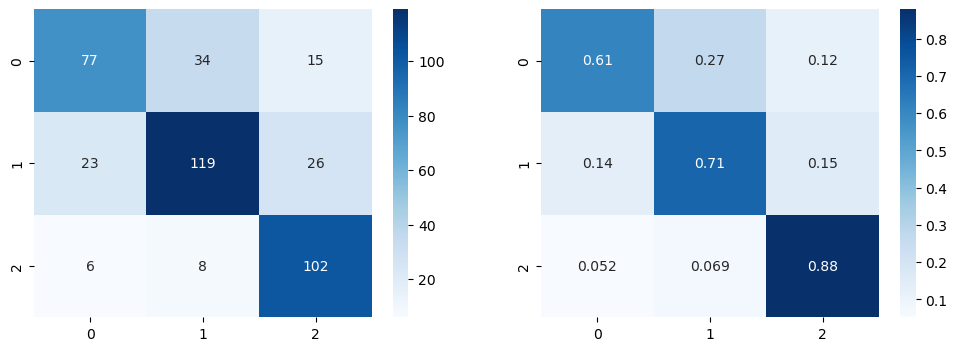

In [24]:
#X.shape(2048,225) Best trial was 09(Test-0.3)
start_time = time.perf_counter()
cl_optuna = xgb.XGBClassifier(
    learning_rate = 0.031027615606594512,
    max_depth=9,
    n_estimators=97,
    min_child_weight=3,
    gamma=0.5786856661469191,
    subsample=1,
    use_label_encoder=False,
    eval_metric="mlogloss")
cl_optuna.fit(X_train, y_train)
print(confusion_matrix(y_test, cl_optuna.predict(X_test)))
print(classification_report(y_test, cl_optuna.predict(X_test)))
cm0 = confusion_matrix(y_test,cl_optuna.predict(X_test), normalize="true")
cm1 = confusion_matrix(y_test, cl_optuna.predict(X_test))

fig = plt.figure(figsize=(12,4))
plt.subplot(121)
sns.heatmap(cm1, annot=True, cmap='Blues',fmt='g')
plt.subplot(122)
sns.heatmap(cm0, annot=True, cmap='Blues')
end_time = time.perf_counter()
time_lapse = end_time - start_time
print (f"Finished in {time_lapse:.1f} sec.")

# Lgbm

==Confusion Matrix==
[[ 81  37   9]
 [ 13 124  18]
 [  8  18 102]]
==Classification Report==
              precision    recall  f1-score   support

           0       0.79      0.64      0.71       127
           1       0.69      0.80      0.74       155
           2       0.79      0.80      0.79       128

    accuracy                           0.75       410
   macro avg       0.76      0.74      0.75       410
weighted avg       0.75      0.75      0.75       410

Finished in 8.9 sec.


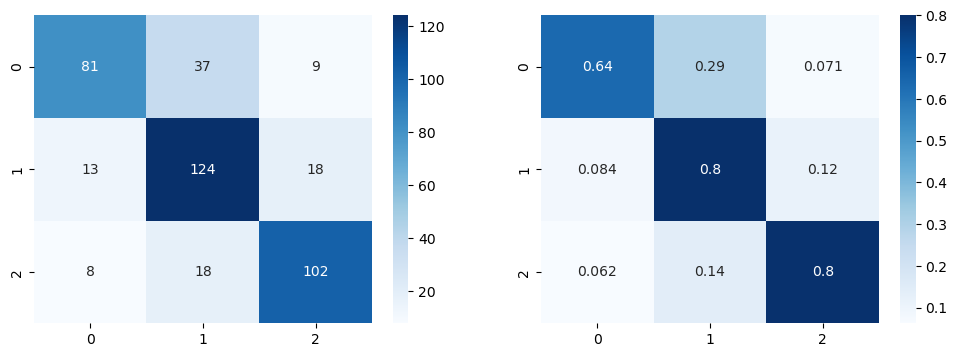

In [30]:
import lightgbm as lgb
#X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

start_time = time.perf_counter()

model = lgb.LGBMClassifier()
model.fit(X_train,y_train)

lgb_pred_train=model.predict(X_train)
lgb_pred_test=model.predict(X_test)
cm0 = confusion_matrix(y_test, lgb_pred_test, normalize="true")
cm1 = confusion_matrix(y_test, lgb_pred_test)


end_time = time.perf_counter()
time_lapse = end_time - start_time

fig = plt.figure(figsize=(12,4))
plt.subplot(121)
sns.heatmap(cm1, annot=True, cmap='Blues',fmt='g')
plt.subplot(122)
sns.heatmap(cm0, annot=True, cmap='Blues')


print('==Confusion Matrix==')

print(confusion_matrix(y_test,lgb_pred_test))

print('==Classification Report==')

print(classification_report(y_test,lgb_pred_test))

print (f"Finished in {time_lapse:.1f} sec.")

In [26]:
# To remove json special charachter from Freatures Name
X.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X.columns]
X.columns


Index(['0__variance_larger_than_standard_deviation', '0__has_duplicate_max',
       '0__has_duplicate_min', '0__has_duplicate', '0__sum_values',
       '0__abs_energy', '0__mean_abs_change', '0__mean_change',
       '0__mean_second_derivative_central', '0__median',
       ...
       '0__permutation_entropy__dimension_6__tau_1',
       '0__permutation_entropy__dimension_7__tau_1',
       '0__query_similarity_count__query_None__threshold_0_0',
       '0__matrix_profile__feature__min___threshold_0_98',
       '0__matrix_profile__feature__max___threshold_0_98',
       '0__matrix_profile__feature__mean___threshold_0_98',
       '0__matrix_profile__feature__median___threshold_0_98',
       '0__matrix_profile__feature__25___threshold_0_98',
       '0__matrix_profile__feature__75___threshold_0_98',
       '0__mean_n_absolute_max__number_of_maxima_7'],
      dtype='object', length=789)

In [118]:
import itertools
A=[]
for x in X.columns:
    for c in str(x):
        if c.isalnum():
            A.append("".join(c))
        else:
            A.append("_".join(c))
#A

==Confusion Matrix==
[[ 71  38  11]
 [ 14 123  24]
 [  5  18 106]]
==Classification Report==
              precision    recall  f1-score   support

           0       0.79      0.59      0.68       120
           1       0.69      0.76      0.72       161
           2       0.75      0.82      0.79       129

    accuracy                           0.73       410
   macro avg       0.74      0.73      0.73       410
weighted avg       0.74      0.73      0.73       410

Finished in 6.1 sec.


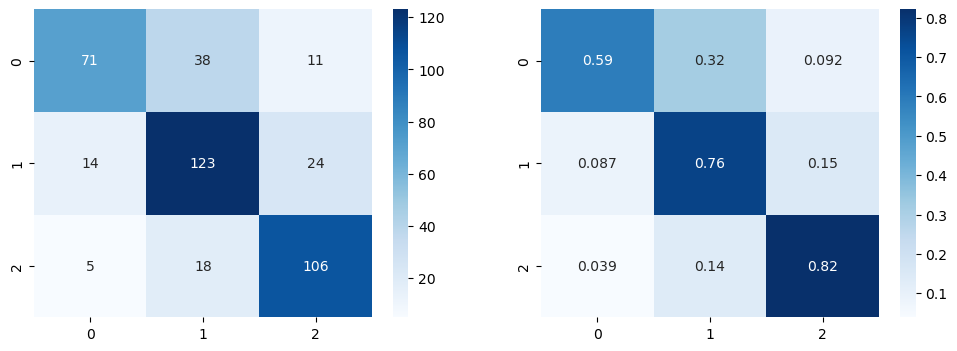

In [94]:
import lightgbm as lgb
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

start_time = time.perf_counter()

model = lgb.LGBMClassifier()
model.fit(X_train,y_train)

lgb_pred_train=model.predict(X_train)
lgb_pred_test=model.predict(X_test)
cm0 = confusion_matrix(y_test, lgb_pred_test, normalize="true")
cm1 = confusion_matrix(y_test, lgb_pred_test)


end_time = time.perf_counter()
time_lapse = end_time - start_time

fig = plt.figure(figsize=(12,4))
plt.subplot(121)
sns.heatmap(cm1, annot=True, cmap='Blues',fmt='g')
plt.subplot(122)
sns.heatmap(cm0, annot=True, cmap='Blues')


print('==Confusion Matrix==')

print(confusion_matrix(y_test,lgb_pred_test))

print('==Classification Report==')

print(classification_report(y_test,lgb_pred_test))

print (f"Finished in {time_lapse:.1f} sec.")

In [95]:
X.columns

Index(['0__fourier_entropy__bins_100', '0__spkt_welch_density__coeff_5',
       '0__spkt_welch_density__coeff_8',
       '0__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"min"',
       '0__symmetry_looking__r_0.1',
       '0__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0',
       '0__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0',
       '0__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"var"',
       '0__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0',
       '0__fourier_entropy__bins_10',
       ...
       '0__matrix_profile__feature_"median"__threshold_0.98',
       '0__large_standard_deviation__r_0.15000000000000002',
       '0__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6',
       '0__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4',
       '0__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4',
       '0__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6',
       '0__fft_coefficient__att

==Confusion Matrix==
[[ 70  39  11]
 [ 15 126  20]
 [  2  19 108]]
==Classification Report==
              precision    recall  f1-score   support

           0       0.80      0.58      0.68       120
           1       0.68      0.78      0.73       161
           2       0.78      0.84      0.81       129

    accuracy                           0.74       410
   macro avg       0.76      0.73      0.74       410
weighted avg       0.75      0.74      0.74       410

Finished in 2.4 sec.


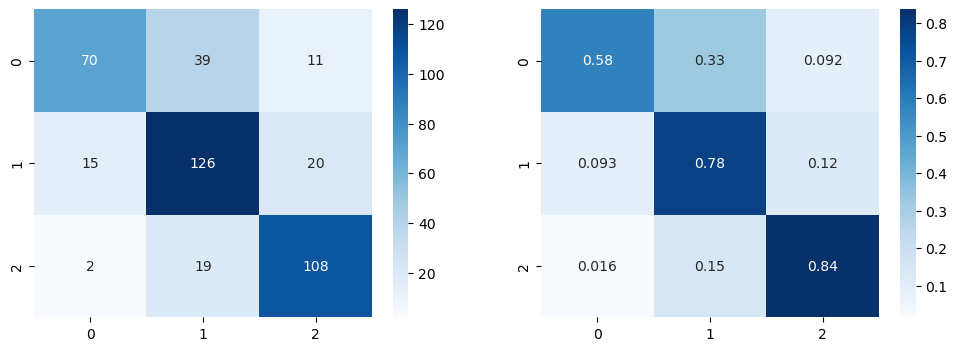

In [97]:
import lightgbm as lgb
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

start_time = time.perf_counter()

model = lgb.LGBMClassifier()
model.fit(X_train,y_train)

lgb_pred_train=model.predict(X_train)
lgb_pred_test=model.predict(X_test)
cm0 = confusion_matrix(y_test, lgb_pred_test, normalize="true")
cm1 = confusion_matrix(y_test, lgb_pred_test)


end_time = time.perf_counter()
time_lapse = end_time - start_time

fig = plt.figure(figsize=(12,4))
plt.subplot(121)
sns.heatmap(cm1, annot=True, cmap='Blues',fmt='g')
plt.subplot(122)
sns.heatmap(cm0, annot=True, cmap='Blues')


print('==Confusion Matrix==')

print(confusion_matrix(y_test,lgb_pred_test))

print('==Classification Report==')

print(classification_report(y_test,lgb_pred_test))

print (f"Finished in {time_lapse:.1f} sec.")

In [72]:
import optuna
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate, StratifiedKFold


def objective(trial):
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
    max_depth = trial.suggest_int('max_depth', 2, 11)
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    clf1 = LGBMClassifier(learning_rate=learning_rate,
                         max_depth=max_depth,
                         n_estimators=n_estimators,
                         min_child_weight=min_child_weight)
    for i in range(3):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=y, random_state=i)
        clf1.fit(X_train, y_train)
        y_pred = clf1.predict(X_test)
        cm = confusion_matrix(y_test, y_pred, normalize="true")
        score = cm[2,2]*0.4+(1-cm[1,2])*0.2+(1-cm[0,2])*0.4
    return score

#2.Create an Optuna Object
study = optuna.create_study(direction='maximize')
#3.Parameter search in Optuna
study.optimize(objective, n_trials=300)

[I 2022-12-12 11:54:50,554] A new study created in memory with name: no-name-56934588-0296-4ccf-a67f-b14cd1a3d3bf
[I 2022-12-12 11:54:53,174] Trial 0 finished with value: 0.8513656902830267 and parameters: {'learning_rate': 0.16752007541232725, 'max_depth': 6, 'n_estimators': 121, 'min_child_weight': 5}. Best is trial 0 with value: 0.8513656902830267.
[I 2022-12-12 11:54:54,982] Trial 1 finished with value: 0.846994105583573 and parameters: {'learning_rate': 0.37615092048705207, 'max_depth': 11, 'n_estimators': 193, 'min_child_weight': 7}. Best is trial 0 with value: 0.8513656902830267.
[I 2022-12-12 11:54:56,142] Trial 2 finished with value: 0.8420627447945553 and parameters: {'learning_rate': 0.5814087092234625, 'max_depth': 6, 'n_estimators': 170, 'min_child_weight': 10}. Best is trial 0 with value: 0.8513656902830267.
[I 2022-12-12 11:54:57,376] Trial 3 finished with value: 0.8366421173466098 and parameters: {'learning_rate': 0.5801745408205007, 'max_depth': 6, 'n_estimators': 178,

[I 2022-12-12 11:55:51,497] Trial 32 finished with value: 0.8458926106976564 and parameters: {'learning_rate': 0.08001582395895157, 'max_depth': 6, 'n_estimators': 181, 'min_child_weight': 7}. Best is trial 19 with value: 0.859225342121216.
[I 2022-12-12 11:55:52,918] Trial 33 finished with value: 0.840725215290228 and parameters: {'learning_rate': 0.35675114477869657, 'max_depth': 4, 'n_estimators': 161, 'min_child_weight': 5}. Best is trial 19 with value: 0.859225342121216.
[I 2022-12-12 11:55:55,533] Trial 34 finished with value: 0.8420274900792372 and parameters: {'learning_rate': 0.20584453677561232, 'max_depth': 6, 'n_estimators': 173, 'min_child_weight': 8}. Best is trial 19 with value: 0.859225342121216.
[I 2022-12-12 11:55:56,936] Trial 35 finished with value: 0.8473006496326201 and parameters: {'learning_rate': 0.08727604683204786, 'max_depth': 3, 'n_estimators': 188, 'min_child_weight': 6}. Best is trial 19 with value: 0.859225342121216.
[I 2022-12-12 11:55:59,388] Trial 36 

[I 2022-12-12 11:56:51,767] Trial 65 finished with value: 0.8570395497714893 and parameters: {'learning_rate': 0.1900715430037695, 'max_depth': 4, 'n_estimators': 177, 'min_child_weight': 4}. Best is trial 55 with value: 0.8622241426010242.
[I 2022-12-12 11:56:53,097] Trial 66 finished with value: 0.852738474502672 and parameters: {'learning_rate': 0.18090513544462183, 'max_depth': 3, 'n_estimators': 180, 'min_child_weight': 5}. Best is trial 55 with value: 0.8622241426010242.
[I 2022-12-12 11:56:55,225] Trial 67 finished with value: 0.8469588508682548 and parameters: {'learning_rate': 0.219050678186698, 'max_depth': 5, 'n_estimators': 159, 'min_child_weight': 4}. Best is trial 55 with value: 0.8622241426010242.
[I 2022-12-12 11:56:57,791] Trial 68 finished with value: 0.8500634154940174 and parameters: {'learning_rate': 0.02562815515251854, 'max_depth': 4, 'n_estimators': 185, 'min_child_weight': 5}. Best is trial 55 with value: 0.8622241426010242.
[I 2022-12-12 11:56:59,967] Trial 69

[I 2022-12-12 11:57:39,965] Trial 98 finished with value: 0.8517074890473918 and parameters: {'learning_rate': 0.07542850432570332, 'max_depth': 3, 'n_estimators': 144, 'min_child_weight': 4}. Best is trial 79 with value: 0.8674087354305591.
[I 2022-12-12 11:57:41,406] Trial 99 finished with value: 0.829807861801516 and parameters: {'learning_rate': 0.01005254384023098, 'max_depth': 3, 'n_estimators': 167, 'min_child_weight': 6}. Best is trial 79 with value: 0.8674087354305591.
[I 2022-12-12 11:57:43,361] Trial 100 finished with value: 0.8499223966327447 and parameters: {'learning_rate': 0.1842780395881981, 'max_depth': 5, 'n_estimators': 161, 'min_child_weight': 10}. Best is trial 79 with value: 0.8674087354305591.
[I 2022-12-12 11:57:46,326] Trial 101 finished with value: 0.8543292360475165 and parameters: {'learning_rate': 0.1227805847555293, 'max_depth': 5, 'n_estimators': 179, 'min_child_weight': 6}. Best is trial 79 with value: 0.8674087354305591.
[I 2022-12-12 11:57:48,432] Tria

[I 2022-12-12 11:58:48,520] Trial 131 finished with value: 0.8488561564621464 and parameters: {'learning_rate': 0.24311782264522105, 'max_depth': 3, 'n_estimators': 158, 'min_child_weight': 6}. Best is trial 79 with value: 0.8674087354305591.
[I 2022-12-12 11:58:49,767] Trial 132 finished with value: 0.8559905070229974 and parameters: {'learning_rate': 0.20592924047834169, 'max_depth': 3, 'n_estimators': 152, 'min_child_weight': 6}. Best is trial 79 with value: 0.8674087354305591.
[I 2022-12-12 11:58:51,371] Trial 133 finished with value: 0.8469588508682548 and parameters: {'learning_rate': 0.2199472468566829, 'max_depth': 3, 'n_estimators': 153, 'min_child_weight': 6}. Best is trial 79 with value: 0.8674087354305591.
[I 2022-12-12 11:58:52,077] Trial 134 finished with value: 0.8424397982742388 and parameters: {'learning_rate': 0.19913457163262105, 'max_depth': 2, 'n_estimators': 136, 'min_child_weight': 6}. Best is trial 79 with value: 0.8674087354305591.
[I 2022-12-12 11:58:53,595] T

[I 2022-12-12 11:59:56,824] Trial 164 finished with value: 0.851259926137072 and parameters: {'learning_rate': 0.12612673739072344, 'max_depth': 5, 'n_estimators': 168, 'min_child_weight': 6}. Best is trial 79 with value: 0.8674087354305591.
[I 2022-12-12 12:00:00,107] Trial 165 finished with value: 0.8600736049666156 and parameters: {'learning_rate': 0.14509765214689363, 'max_depth': 6, 'n_estimators': 161, 'min_child_weight': 6}. Best is trial 79 with value: 0.8674087354305591.
[I 2022-12-12 12:00:04,064] Trial 166 finished with value: 0.85465297751867 and parameters: {'learning_rate': 0.15083452180210277, 'max_depth': 6, 'n_estimators': 163, 'min_child_weight': 3}. Best is trial 79 with value: 0.8674087354305591.
[I 2022-12-12 12:00:07,337] Trial 167 finished with value: 0.8352873904201761 and parameters: {'learning_rate': 0.1745049696799145, 'max_depth': 6, 'n_estimators': 160, 'min_child_weight': 6}. Best is trial 79 with value: 0.8674087354305591.
[I 2022-12-12 12:00:11,502] Tria

[I 2022-12-12 12:01:16,484] Trial 197 finished with value: 0.8501936859664736 and parameters: {'learning_rate': 0.12467745925059931, 'max_depth': 4, 'n_estimators': 123, 'min_child_weight': 8}. Best is trial 79 with value: 0.8674087354305591.
[I 2022-12-12 12:01:17,898] Trial 198 finished with value: 0.8415915354288392 and parameters: {'learning_rate': 0.08356311838429348, 'max_depth': 3, 'n_estimators': 165, 'min_child_weight': 6}. Best is trial 79 with value: 0.8674087354305591.
[I 2022-12-12 12:01:20,498] Trial 199 finished with value: 0.8437592704853543 and parameters: {'learning_rate': 0.23487686150647755, 'max_depth': 6, 'n_estimators': 159, 'min_child_weight': 6}. Best is trial 79 with value: 0.8674087354305591.
[I 2022-12-12 12:01:21,383] Trial 200 finished with value: 0.8423692888436023 and parameters: {'learning_rate': 0.14776244422678633, 'max_depth': 2, 'n_estimators': 169, 'min_child_weight': 6}. Best is trial 79 with value: 0.8674087354305591.
[I 2022-12-12 12:01:22,409] 

[I 2022-12-12 12:02:36,961] Trial 230 finished with value: 0.8399474618754649 and parameters: {'learning_rate': 0.17416693958632817, 'max_depth': 4, 'n_estimators': 154, 'min_child_weight': 6}. Best is trial 79 with value: 0.8674087354305591.
[I 2022-12-12 12:02:39,698] Trial 231 finished with value: 0.8484021445185368 and parameters: {'learning_rate': 0.10636573741357273, 'max_depth': 5, 'n_estimators': 167, 'min_child_weight': 6}. Best is trial 79 with value: 0.8674087354305591.
[I 2022-12-12 12:02:43,037] Trial 232 finished with value: 0.847518626957819 and parameters: {'learning_rate': 0.09315842690253995, 'max_depth': 5, 'n_estimators': 174, 'min_child_weight': 6}. Best is trial 79 with value: 0.8674087354305591.
[I 2022-12-12 12:02:45,721] Trial 233 finished with value: 0.8515484128929074 and parameters: {'learning_rate': 0.22447855766337804, 'max_depth': 6, 'n_estimators': 164, 'min_child_weight': 6}. Best is trial 79 with value: 0.8674087354305591.
[I 2022-12-12 12:02:48,472] T

[I 2022-12-12 12:04:45,155] Trial 263 finished with value: 0.851960721087909 and parameters: {'learning_rate': 0.1127917902724462, 'max_depth': 6, 'n_estimators': 185, 'min_child_weight': 4}. Best is trial 79 with value: 0.8674087354305591.
[I 2022-12-12 12:04:48,463] Trial 264 finished with value: 0.864138645617022 and parameters: {'learning_rate': 0.15769881753653395, 'max_depth': 6, 'n_estimators': 187, 'min_child_weight': 4}. Best is trial 79 with value: 0.8674087354305591.
[I 2022-12-12 12:04:52,220] Trial 265 finished with value: 0.8578878126168887 and parameters: {'learning_rate': 0.16161317162920058, 'max_depth': 7, 'n_estimators': 188, 'min_child_weight': 4}. Best is trial 79 with value: 0.8674087354305591.
[I 2022-12-12 12:04:56,196] Trial 266 finished with value: 0.8594080647310969 and parameters: {'learning_rate': 0.14728940768230514, 'max_depth': 7, 'n_estimators': 189, 'min_child_weight': 4}. Best is trial 79 with value: 0.8674087354305591.
[I 2022-12-12 12:05:00,565] Tri

[I 2022-12-12 12:07:11,546] Trial 296 finished with value: 0.8497749287381822 and parameters: {'learning_rate': 0.17832348846853116, 'max_depth': 7, 'n_estimators': 199, 'min_child_weight': 2}. Best is trial 79 with value: 0.8674087354305591.
[I 2022-12-12 12:07:17,385] Trial 297 finished with value: 0.8559380548855726 and parameters: {'learning_rate': 0.09714107511146644, 'max_depth': 7, 'n_estimators': 197, 'min_child_weight': 4}. Best is trial 79 with value: 0.8674087354305591.
[I 2022-12-12 12:07:21,589] Trial 298 finished with value: 0.855702020267162 and parameters: {'learning_rate': 0.0909227779595767, 'max_depth': 7, 'n_estimators': 86, 'min_child_weight': 4}. Best is trial 79 with value: 0.8674087354305591.
[I 2022-12-12 12:07:23,516] Trial 299 finished with value: 0.8250239689070609 and parameters: {'learning_rate': 0.9414498555682348, 'max_depth': 6, 'n_estimators': 185, 'min_child_weight': 3}. Best is trial 79 with value: 0.8674087354305591.


[LightGBM] [Warning] Unknown parameter: eval_metric
[[ 67  40  13]
 [ 16 122  23]
 [  6  18 105]]
              precision    recall  f1-score   support

           0       0.75      0.56      0.64       120
           1       0.68      0.76      0.72       161
           2       0.74      0.81      0.78       129

    accuracy                           0.72       410
   macro avg       0.73      0.71      0.71       410
weighted avg       0.72      0.72      0.71       410

Finished in 2.3 sec.


<AxesSubplot:>

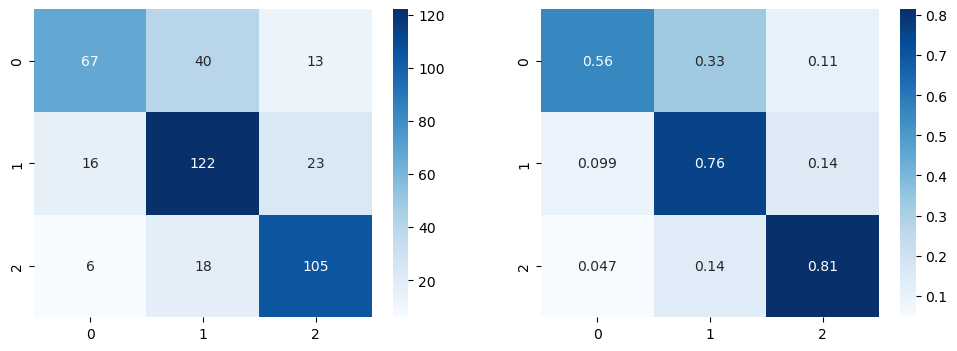

In [75]:
start_time = time.perf_counter()
cl_optuna = lgb.LGBMClassifier(
    learning_rate =0.19268631918431967,
    max_depth=11,
    n_estimators=138,
    min_child_weight=10,
    #verbose=5,
    eval_metric='logloss',
    boosting_type= 'gbdt')
cl_optuna.fit(X_train, y_train)
print(confusion_matrix(y_test, cl_optuna.predict(X_test)))
print(classification_report(y_test, cl_optuna.predict(X_test)))
end_time = time.perf_counter()
time_lapse = end_time - start_time
print (f"Finished in {time_lapse:.1f} sec.")
cm0 = confusion_matrix(y_test,cl_optuna.predict(X_test), normalize="true")
cm1 = confusion_matrix(y_test,cl_optuna.predict(X_test))
fig = plt.figure(figsize=(12,4))
plt.subplot(121)
sns.heatmap(cm1, annot=True, cmap='Blues',fmt='g')
plt.subplot(122)
sns.heatmap(cm0, annot=True, cmap='Blues')

In [136]:
#from sklearn.datasets import make_classification
#from xgboost import XGBClassifier
# define dataset
#X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1, n_classes=3)
# define the model
model = cl_optuna(objective="multi:softprob")
# fit the model
model.fit(X, y)
# summarize the model loss function
print(model.objective)

TypeError: 'XGBClassifier' object is not callable

In [66]:
X.shape

(2048, 789)

In [15]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import seaborn as sns

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 2)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Training the K-NN model on the Training set
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test, y_pred)
cm0 = confusion_matrix(y_test, y_pred, normalize="true")
cm1 = confusion_matrix(y_test, y_pred)
print('==confusion Matrix==')

print(confusion_matrix(y_test,y_pred))

print('==classification Report==')

print(classification_report(y_test, y_pred))

fig = plt.figure(figsize=(12,4))
plt.subplot(121)
sns.heatmap(cm1, annot=True, cmap='Blues',fmt='g')
plt.subplot(122)
sns.heatmap(cm0, annot=True, cmap='Blues')

C:\Users\Fahim\anaconda3\lib\site-packages\sklearn\utils\extmath.py:985: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\Fahim\anaconda3\lib\site-packages\sklearn\utils\extmath.py:990: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
C:\Users\Fahim\anaconda3\lib\site-packages\sklearn\utils\extmath.py:1020: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction ** 2 / new_sample_count


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [9]:
import pandas as pd
print(pd.__version__)

2.0.1
